In [23]:
%pip install catboost optuna

Note: you may need to restart the kernel to use updated packages.


In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
import copy


from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GroupKFold, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
import lightgbm as lgb
import catboost
from catboost import CatBoostClassifier

from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.svm import SVC as cuSVC
from cuml.neighbors import KNeighborsClassifier as cuKNN
from cuml.linear_model import LogisticRegression as cuLogReg
import cudf
import cupy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import optuna
from google.cloud import storage
import io


# Versions
print("Core:")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"joblib: {joblib.__version__}")
print(f"pickle: built-in module")

print("\nSklearn:")
import sklearn
print(f"scikit-learn: {sklearn.__version__}")

print("\nGradient Boosting:")
print(f"xgboost: {xgb.__version__}")
print(f"lightgbm: {lgb.__version__}")
print(f"catboost: {catboost.__version__}")

print("\nRAPIDS:")
import cuml
import cupy
import cudf
print(f"cuml: {cuml.__version__}")
print(f"cudf: {cudf.__version__}")
print(f"cupy: {cupy.__version__}")

print("\nPyTorch:")
print(f"torch: {torch.__version__}")

print("\nOptuna:")
print(f"optuna: {optuna.__version__}")

print("\nGoogle Cloud Storage:")
print(f"google-cloud-storage: {storage.__version__}")


Core:
pandas: 2.2.3
numpy: 1.26.4
matplotlib: 3.7.2
seaborn: 0.12.2
joblib: 1.5.1
pickle: built-in module

Sklearn:
scikit-learn: 1.2.2

Gradient Boosting:
xgboost: 2.0.3
lightgbm: 4.5.0
catboost: 1.2.8

RAPIDS:
cuml: 25.02.01
cudf: 25.02.02
cupy: 13.4.1

PyTorch:
torch: 2.6.0+cu124

Optuna:
optuna: 4.4.0

Google Cloud Storage:
google-cloud-storage: 2.19.0


In [25]:
# GPU check
try:
    GPU_AVAILABLE = cupy.is_available()
except ImportError:
    GPU_AVAILABLE = False

In [26]:
DEVICE = "cuda" if GPU_AVAILABLE else "cpu"
# DATA_PATH = '/content/drive/MyDrive/Projects/Dissertation/final_features_dataset.csv'
# ARTIFACTS_DIR = '/content/drive/MyDrive/Projects/Dissertation/artifacts2'
# os.makedirs(ARTIFACTS_DIR, exist_ok=True)
print(f"Using device: {DEVICE}")
SEQ_LEN = 20

Using device: cuda


In [27]:
def setup_gcs(project_id):
    """
    Returns a GCS storage client.
    Handles Colab login, Kaggle GCP, and local service account/gcloud.
    """
    if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
        # Kaggle: enable GCP in settings, uses service account behind the scenes
        client = storage.Client(project=project_id)

    elif "COLAB_GPU" in os.environ:
        # Colab: authenticate with your Google account
        from google.colab import auth
        auth.authenticate_user()
        client = storage.Client(project=project_id)

    else:
        # Local: either gcloud auth or set service account JSON
        os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "service_account.json"
        client = storage.Client(project=project_id)

    return client

In [28]:
# ---- Save artifacts to GCS ----
def save_cascading_model(model, selected_features, model_name):
    stage_dir = f"{ARTIFACTS_DIR}/stage3_cascading"

    try:
        # Save model + features
        model_blob = bucket.blob(f"{stage_dir}/{model_name}_model.joblib")
        with model_blob.open("wb") as f:
            joblib.dump((model, selected_features), f)

        print(f"✅ Saved cascading model: {model_name}")
    except Exception as e:
        print(f"❌ Failed to save cascading model {model_name}: {e}")

def save_artifacts(model, selected_features, study, model_name, stage):
    stage_dir = f"{ARTIFACTS_DIR}/{stage}"

    try:
        # Save model + feature names together
        model_blob = bucket.blob(f"{stage_dir}/{model_name}_model.joblib")
        with model_blob.open("wb") as f:
            joblib.dump((model, selected_features), f)

        # Save study separately
        study_blob = bucket.blob(f"{stage_dir}/{model_name}_study.pkl")
        with study_blob.open("wb") as f:
            pickle.dump(study, f)

        print(f"✅ Saved artifacts for {model_name} at stage '{stage}'.")
    except Exception as e:
        print(f"❌ Failed to save artifacts for {model_name} at stage '{stage}': {e}")


def load_artifacts(model_name, stage):
    stage_dir = f"{ARTIFACTS_DIR}/{stage}"
    model_blob = bucket.blob(f"{stage_dir}/{model_name}_model.joblib")
    study_blob = bucket.blob(f"{stage_dir}/{model_name}_study.pkl")

    if not model_blob.exists() or not study_blob.exists():
        return None, None

    try:
        with model_blob.open("rb") as f:
            model = joblib.load(f)
        with study_blob.open("rb") as f:
            study = pickle.load(f)
        return model, study
    except Exception as e:
        print(f"Failed to load artifacts for {model_name} at stage '{stage}': {e}")
        return None, None

def save_results_per_model(results_dict, stage):
    """
    Save each model's evaluation results separately to the cloud bucket.
    """
    stage_dir = f"{ARTIFACTS_DIR}/{stage}"
    for model_name, result in results_dict.items():
        results_blob = bucket.blob(f"{stage_dir}/{model_name}_result.pkl")
        try:
            with results_blob.open("wb") as f:
                pickle.dump(result, f)
            print(f"Saved results for {model_name} at stage '{stage}'.")
        except Exception as e:
            print(f"Failed to save results for {model_name} at stage '{stage}': {e}")


def load_results_per_model(models_to_try, stage):
    """
    Load evaluation results per model from the cloud bucket.
    Returns a dict containing results for the models that exist.
    """
    stage_dir = f"{ARTIFACTS_DIR}/{stage}"
    results_dict = {}
    for model_name in models_to_try:
        results_blob = bucket.blob(f"{stage_dir}/{model_name}_result.pkl")
        try:
            results_blob.reload()  # check if exists
            data = results_blob.download_as_bytes()
            results_dict[model_name] = pickle.loads(data)
        except Exception:
            # Model result does not exist, skip
            continue
    return results_dict


def save_checkpoint(model, optimizer, epoch, model_name, stage):
    stage_dir = f"{ARTIFACTS_DIR}/{stage}"
    checkpoint_blob = bucket.blob(f"{stage_dir}/{model_name}_checkpoint.pth")
    checkpoint_data = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    try:
        with checkpoint_blob.open("wb", ignore_flush=True) as f:
            torch.save(checkpoint_data, f)
        print(f"Checkpoint saved for {model_name} at stage '{stage}', epoch {epoch}.")
    except Exception as e:
        print(f"Failed to save checkpoint for {model_name} at stage '{stage}': {e}")

def load_checkpoint(model, optimizer, model_name, stage):
    stage_dir = f"{ARTIFACTS_DIR}/{stage}"
    checkpoint_blob = bucket.blob(f"{stage_dir}/{model_name}_checkpoint.pth")
    if not checkpoint_blob.exists():
        return None
    try:
        with checkpoint_blob.open("rb") as f:
            checkpoint_data = torch.load(f, map_location="cpu")
            model.load_state_dict(checkpoint_data['model_state_dict'])
            optimizer.load_state_dict(checkpoint_data['optimizer_state_dict'])
        print(f"Checkpoint loaded for {model_name} at stage '{stage}', epoch {checkpoint_data['epoch']}.")
        return checkpoint_data['epoch']
    except Exception as e:
        print(f"Failed to load checkpoint for {model_name} at stage '{stage}': {e}")
        return None

def save_study_checkpoint(study, model_name, stage):
    stage_dir = f"{ARTIFACTS_DIR}/{stage}"
    study_blob = bucket.blob(f"{stage_dir}/{model_name}_study_checkpoint.pkl")
    try:
        with study_blob.open("wb") as f:
            pickle.dump(study, f)
        print(f"Optuna study checkpoint saved for {model_name} at stage '{stage}'.")
    except Exception as e:
        print(f"Failed to save study checkpoint for {model_name} at stage '{stage}': {e}")

def load_study_checkpoint(model_name, stage):
    stage_dir = f"{ARTIFACTS_DIR}/{stage}"
    study_blob = bucket.blob(f"{stage_dir}/{model_name}_study_checkpoint.pkl")
    if not study_blob.exists():
        return None
    try:
        with study_blob.open("rb") as f:
            study = pickle.load(f)
        print(f"Optuna study checkpoint loaded for {model_name} at stage '{stage}'.")
        return study
    except Exception as e:
        print(f"Failed to load study checkpoint for {model_name} at stage '{stage}': {e}")
        return None


In [29]:
def to_cudf(X, y=None):
    if not isinstance(X, cudf.DataFrame):
        X = cudf.DataFrame.from_pandas(X)
    if y is not None and not isinstance(y, cudf.Series):
        y = cudf.Series(y)
    return (X, y) if y is not None else X

In [30]:
PROJECT_ID = "trusty-splice-466613-m1"
BUCKET_NAME = "dissertation-network-models"
ARTIFACTS_DIR = "artifacts_temporal2"
DATA_PATH = "final_features_dataset.csv"

# Initialize GCS client & bucket
storage_client = setup_gcs(PROJECT_ID)
bucket = storage_client.bucket(BUCKET_NAME)

In [31]:
def evaluate_classification(model, model_name, X_test=None, y_test=None, target_names=None,
                            y_pred=None, y_prob=None, stage="eval", save_graphs=True):
    """
    Evaluate classification model with multiple plots (including micro/macro averages) and optionally save to GCS.
    """
    print(f"\n--- Evaluating {model_name} ---")

    if y_pred is None:
        y_pred = model.predict(X_test)

    if y_prob is None:
        try:
            y_prob = model.predict_proba(X_test)
        except:
            y_prob = None

    # Print classification report
    report = classification_report(y_test, y_pred, target_names=target_names)
    print(report)

    # Helper to save plots to GCS
    def save_plot(fig, filename):
        if save_graphs:
            buf = io.BytesIO()
            fig.savefig(buf, format='png', bbox_inches='tight')
            buf.seek(0)
            blob = bucket.blob(f"{ARTIFACTS_DIR}/{stage}/{filename}")
            blob.upload_from_file(buf, content_type='image/png')
            buf.close()
        plt.close(fig)

    # 1️⃣ Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    save_plot(fig, f"{model_name}_confusion_matrix.png")

    # 2️⃣ Normalized Confusion Matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig = plt.figure(figsize=(8,6))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Normalized Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    save_plot(fig, f"{model_name}_confusion_matrix_normalized.png")

    # Only compute curves if probabilities are available
    if y_prob is not None:
        classes = np.unique(y_test)
        y_test_bin = label_binarize(y_test, classes=classes)

        # 3️⃣ ROC Curves (per class)
        fig = plt.figure(figsize=(8,6))
        all_fpr = np.linspace(0, 1, 100)
        tpr_macro_list = []
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_prob[:,i])
            auc_score = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{target_names[i]} (AUC={auc_score:.2f})')
            # interpolate for macro avg
            tpr_macro_list.append(np.interp(all_fpr, fpr, tpr))
        # Macro-average
        tpr_macro = np.mean(tpr_macro_list, axis=0)
        auc_macro = auc(all_fpr, tpr_macro)
        plt.plot(all_fpr, tpr_macro, 'k--', label=f'Macro-average ROC (AUC={auc_macro:.2f})', linewidth=2)
        plt.plot([0,1],[0,1],'k:')
        plt.title(f'ROC Curve for {model_name}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()
        save_plot(fig, f"{model_name}_roc_curve.png")

        # 4️⃣ Precision-Recall Curves (per class)
        fig = plt.figure(figsize=(8,6))
        tpr_macro_list = []
        for i in range(len(classes)):
            precision, recall, _ = precision_recall_curve(y_test_bin[:,i], y_prob[:,i])
            plt.plot(recall, precision, label=f'{target_names[i]}')
            # interpolate for macro avg
            recall_interp = np.linspace(0, 1, 100)
            precision_interp = np.interp(recall_interp, recall[::-1], precision[::-1])
            tpr_macro_list.append(precision_interp)
        precision_macro = np.mean(tpr_macro_list, axis=0)
        plt.plot(np.linspace(0,1,100), precision_macro, 'k--', label='Macro-average PR', linewidth=2)
        plt.title(f'Precision-Recall Curve for {model_name}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.show()
        save_plot(fig, f"{model_name}_precision_recall_curve.png")

    # 5️⃣ Class Distributions
    fig = plt.figure(figsize=(8,5))
    sns.countplot(x=y_test, palette="Set2")
    plt.title(f'True Class Distribution ({model_name})')
    plt.show()
    save_plot(fig, f"{model_name}_true_class_distribution.png")

    fig = plt.figure(figsize=(8,5))
    sns.countplot(x=y_pred, palette="Set1")
    plt.title(f'Predicted Class Distribution ({model_name})')
    plt.show()
    save_plot(fig, f"{model_name}_predicted_class_distribution.png")

    return classification_report(y_test, y_pred, output_dict=True)


In [32]:
# -------------------- DATA PREPARATION --------------------
def load_and_prepare_data(data_path):
    blob = bucket.blob(DATA_PATH)
    with blob.open("rb") as f:
        df = pd.read_csv(f)
    return df
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier as skRF

def split_by_training_run(df, test_size=0.2, random_state=42):
    """Split dataframe so test runs are fully separate from train runs."""
    runs = df['training_run'].unique()
    train_runs, test_runs = train_test_split(runs, test_size=test_size, random_state=random_state)
    
    train_df = df[df['training_run'].isin(train_runs)].copy()
    test_df = df[df['training_run'].isin(test_runs)].copy()
    
    return train_df, test_df

def select_top_features_rf(X, y, top_k=30, plot=True):
    """
    Select top_k features using Random Forest importance.

    Args:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target labels.
        top_k (int): Number of top features to select.
        plot (bool): Whether to plot feature importances.

    Returns:
        selected_features (list): Names of selected features.
    """
    # Impute missing values
    X_imputed = SimpleImputer(strategy="mean").fit_transform(X)

    # Fit RF
    rf = skRF(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_imputed, y)

    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Top-k features
    top_indices = indices[:top_k]
    selected_features = [X.columns[i] for i in top_indices]

    if plot:
        plt.figure(figsize=(12,6))
        sns.barplot(x=importances[top_indices], y=selected_features, palette="viridis")
        plt.title(f"Top {top_k} Feature Importances (Random Forest)")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()

    return selected_features


def prepare_stage1_data(df, seq_len=20, top_k_features=30):
    """
    Prepares data for Stage 1 binary classification.
    - Selects top features using Random Forest
    - Splits by training_run
    - Scales features
    - Converts data into sequences for RNN/CNN models
    """
    df_bin = df.copy()
    df_bin["target"] = df_bin["malicious"]
    df_bin['Timestamp'] = pd.to_datetime(df_bin['Timestamp'], errors='coerce')
    df_bin['Timestamp_epoch'] = df_bin['Timestamp'].astype('int64') // 10**9

    # Exclude columns we don't want as features
    exclude = [
        'DRB.RlcPacketDropRateDl_mean','DRB.RlcPacketDropRateDl_std',
        'DL_DropRate_Per_Throughput_mean','DL_DropRate_Per_Throughput_std',
        'DropRate_to_CQI_mean','DropRate_to_CQI_std','High_Drop_Flag_mean','High_Drop_Flag_std',
        'PacketDropRateDiff_mean','PacketDropRateDiff_std','RRU.PrbUsedDl_mean','RRU.PrbUsedDl_std',
        'DRB.UEThpDl_Spike_mean','DRB.UEThpDl_Spike_std','DRB.UEThpUl_Spike_mean','DRB.UEThpUl_Spike_std',
        'RSRQ_mean','RSRQ_std','Coverage_Quality_mean','Coverage_Quality_std',
        'Throughput_per_PRB_Dl_mean','Throughput_per_PRB_Dl_std','Throughput_per_PRB_Ul_mean','Throughput_per_PRB_Ul_std',
        'Volume_Efficiency_mean','Volume_Efficiency_std','label','malicious','target', 'Timestamp'
    ]
    feature_cols = [c for c in df_bin.columns if c not in exclude and 'Spike' not in c]

    X = df_bin[feature_cols]
    y = df_bin['target']

    # -------------------- Feature selection --------------------
    selected_features = select_top_features_rf(X, y, top_k=top_k_features)

    # -------------------- Split train/test by run --------------------
    train_df, test_df = split_by_training_run(df_bin, test_size=0.2)

    # -------------------- Scaling --------------------
    preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    train_df[selected_features] = preprocessor.fit_transform(train_df[selected_features])
    test_df[selected_features]  = preprocessor.transform(test_df[selected_features])

    # -------------------- Make sequences --------------------
    X_train_seq, y_train_seq = make_sequences(train_df, selected_features, target_col='target', seq_len=seq_len)
    X_test_seq, y_test_seq   = make_sequences(test_df, selected_features, target_col='target', seq_len=seq_len)

    return X_train_seq, X_test_seq, y_train_seq, y_test_seq, selected_features, preprocessor

def prepare_stage2_data(df, selected_features, preprocessor, target_col='label', filter_col='malicious', filter_val=1):
    df_multi = df.copy()
    df_multi = df_multi[df_multi[filter_col] == filter_val]
    le_label = LabelEncoder()
    df_multi["target"] = le_label.fit_transform(df_multi[target_col])
    df_multi['Timestamp'] = pd.to_datetime(df_multi['Timestamp'], errors='coerce')  # convert to datetime
    df_multi['Timestamp_epoch'] = df_multi['Timestamp'].astype('int64') // 10**9
    
    train_df, test_df = split_by_training_run(df_multi, test_size=0.2)
    X_train = train_df[selected_features]
    y_train = train_df['target']
    X_test = test_df[selected_features]
    y_test = test_df['target']
    
    X_train_scaled = preprocessor.transform(X_train)
    X_test_scaled = preprocessor.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, le_label

def make_sequences(df, selected_features, target_col, seq_len=20):
    """
    Groups data per training_run → UE and creates sliding windows.
    """
    X, y = [], []
    
    for run_id, run_group in df.groupby("training_run"):
        for ue_id, group in run_group.groupby("UE_ID"):
            group = group.sort_values("Timestamp_epoch")
            features = group[selected_features].values
            labels = group[target_col].values

            for i in range(len(group) - seq_len + 1):
                X.append(features[i:i+seq_len])
                y.append(labels[i+seq_len-1])  # label = last timestep

    return np.array(X), np.array(y)

In [33]:
def prepare_stage2_data_sequences(df, selected_features, preprocessor, target_col='label', 
                                filter_col='malicious', filter_val=1, seq_len=20):
    """Modified version that can return both flat and sequence data"""
    df_multi = df.copy()
    df_multi = df_multi[df_multi[filter_col] == filter_val]
    le_label = LabelEncoder()
    df_multi["target"] = le_label.fit_transform(df_multi[target_col])
    df_multi['Timestamp'] = pd.to_datetime(df_multi['Timestamp'], errors='coerce')
    df_multi['Timestamp_epoch'] = df_multi['Timestamp'].astype('int64') // 10**9
    
    train_df, test_df = split_by_training_run(df_multi, test_size=0.2)
    
    # Scale the features
    train_df[selected_features] = preprocessor.transform(train_df[selected_features])
    test_df[selected_features] = preprocessor.transform(test_df[selected_features])
    
    # For sequence models, create sequences
    X_train_seq, y_train_seq = make_sequences(train_df, selected_features, target_col='target', seq_len=seq_len)
    X_test_seq, y_test_seq = make_sequences(test_df, selected_features, target_col='target', seq_len=seq_len)
    
    # For classical models, return flat data
    X_train_flat = train_df[selected_features].values
    X_test_flat = test_df[selected_features].values
    y_train_flat = train_df['target'].values
    y_test_flat = test_df['target'].values
    
    return {
        'sequences': (X_train_seq, X_test_seq, y_train_seq, y_test_seq),
        'flat': (X_train_flat, X_test_flat, y_train_flat, y_test_flat),
        'label_encoder': le_label
    }

In [34]:
df = load_and_prepare_data(DATA_PATH)

In [35]:
import torch
import torch.nn as nn

# ----------------- Deep Learning Models -----------------

class MLP(nn.Module):
    def __init__(self, seq_len, input_dim, hidden_dim=64, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(seq_len * input_dim, hidden_dim)  # flatten sequence
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        if x.dim() == 3:  # [batch, seq_len, features]
            x = x.view(x.size(0), -1)  # flatten
        x = self.relu(self.fc1(x))
        return self.fc2(x)


class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x: [batch, seq_len, features] → [batch, features, seq_len]
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.pool(x).squeeze(-1)  # flatten last dim
        return self.fc(x)


class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_classes=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: [batch, seq_len, features]
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])


class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_classes=2):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        _, h = self.gru(x)
        return self.fc(h[-1])


class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_classes=2):
        super().__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        _, (h, _) = self.bilstm(x)
        h = torch.cat((h[-2], h[-1]), dim=1)
        return self.fc(h)


class CNN_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.lstm = nn.LSTM(64, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [batch, features, seq_len]
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)  # back to [batch, seq_len, features=64]
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])


class CNN_GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.gru = nn.GRU(64, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        _, h = self.gru(x)
        return self.fc(h[-1])


class AttentionLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_classes=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attn(out), dim=1)
        context = torch.sum(attn_weights * out, dim=1)
        return self.fc(context)


class AttentionGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_classes=2):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        out, _ = self.gru(x)
        attn_weights = torch.softmax(self.attn(out), dim=1)
        context = torch.sum(attn_weights * out, dim=1)
        return self.fc(context)


class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads=4, hidden_dim=64, num_classes=2, num_layers=1):
        super().__init__()
        
        # Ensure num_heads divides input_dim
        # Find the largest divisor of input_dim that is <= num_heads
        valid_heads = []
        for h in range(1, min(num_heads + 1, input_dim + 1)):
            if input_dim % h == 0:
                valid_heads.append(h)
        
        # Use the largest valid number of heads
        actual_num_heads = max(valid_heads) if valid_heads else 1
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim, nhead=actual_num_heads, dim_feedforward=hidden_dim
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        # x: [batch, seq_len, features] → [seq_len, batch, features]
        x = x.permute(1, 0, 2)
        out = self.transformer(x)
        out = out.mean(dim=0)
        return self.fc(out)


In [36]:
def _get_pytorch_model(model_name, input_dim, num_classes, seq_len=None, hidden_dim=64):
    if model_name == "MLP":
        return MLP(seq_len, input_dim, hidden_dim=hidden_dim, num_classes=num_classes)
    elif model_name == "CNN1D":
        return CNN1D(input_dim, num_classes=num_classes)
    elif model_name == "LSTM":
        return LSTMModel(input_dim, hidden_dim=hidden_dim, num_classes=num_classes)
    elif model_name == "CNN_LSTM":
        return CNN_LSTM(input_dim, hidden_dim=hidden_dim, num_classes=num_classes)
    elif model_name == "GRU":
        return GRUModel(input_dim, hidden_dim=hidden_dim, num_classes=num_classes)
    elif model_name == "BiLSTM":
        return BiLSTM(input_dim, hidden_dim=hidden_dim, num_classes=num_classes)
    elif model_name == "CNN_GRU":
        return CNN_GRU(input_dim, hidden_dim=hidden_dim, num_classes=num_classes)
    elif model_name == "AttentionLSTM":
        return AttentionLSTM(input_dim, hidden_dim=hidden_dim, num_classes=num_classes)
    elif model_name == "AttentionGRU":
        return AttentionGRU(input_dim, hidden_dim=hidden_dim, num_classes=num_classes)
    elif model_name == "Transformer":
        return TransformerModel(input_dim, num_classes=num_classes)
    else:
        raise ValueError(f"Model {model_name} not supported")


# ----------------- Pre-training -----------------
def pretrain_pytorch_model(model_name, X, y, num_classes=None, seq_len=None, epochs=50, reset_head=True):
    """
    Pre-trains a PyTorch model for Stage 1/2.
    """
    if X.ndim == 2:
        X = X[:, np.newaxis, :]  # [batch, 1, features] for CNN/RNN

    input_dim = X.shape[2]
    y_tensor = torch.tensor(y, dtype=torch.long).to(DEVICE)
    X_tensor = torch.tensor(X, dtype=torch.float32).to(DEVICE)

    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    model = _get_pytorch_model(model_name, input_dim, num_classes, seq_len).to(DEVICE)

    # Reset head if necessary
    if reset_head and num_classes is not None:
        if hasattr(model, "fc"):
            in_features = model.fc.in_features
            model.fc = nn.Linear(in_features, num_classes).to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Try loading checkpoint
    start_epoch = load_checkpoint(model, optimizer, model_name, stage="pretraining") or 0

    model.train()
    print(f"--- Starting Pre-training for {model_name} ---")
    for epoch in range(start_epoch, epochs):
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

        print(f"[{model_name}] Pretrain Epoch {epoch+1}/{epochs} done.")

        save_checkpoint(model, optimizer, epoch + 1, model_name, stage="pretraining")

    print(f"--- Pre-training for {model_name} finished ---")
    return model

# ----------------- Optuna Objective -----------------
def create_objective(model_name, X, y, num_classes=None, seq_len=None, stage_name='binary', pretrained_model=None):
    """
    Creates an Optuna objective function for PyTorch models.
    """
    def objective(trial):
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = []

        X_np = np.array(X) if not isinstance(X, np.ndarray) else X
        y_np = np.array(y) if not isinstance(y, np.ndarray) else y

        for train_idx, val_idx in cv.split(X_np, y_np):
            X_train_fold, y_train_fold = X_np[train_idx], y_np[train_idx]
            X_val_fold, y_val_fold = X_np[val_idx], y_np[val_idx]

            if X_train_fold.ndim == 2:
                X_train_fold = X_train_fold[:, np.newaxis, :]
                X_val_fold   = X_val_fold[:, np.newaxis, :]

            X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32).to(DEVICE)
            y_train_tensor = torch.tensor(y_train_fold, dtype=torch.long).to(DEVICE)
            X_val_tensor   = torch.tensor(X_val_fold, dtype=torch.float32).to(DEVICE)
            y_val_tensor   = torch.tensor(y_val_fold, dtype=torch.long).to(DEVICE)

            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
            train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

            # Use pretrained model if provided
            model = copy.deepcopy(pretrained_model) if pretrained_model is not None else _get_pytorch_model(
                model_name, X_np.shape[2], num_classes, seq_len,
                hidden_dim=trial.suggest_int("hidden_dim", 32, 128)
            )
            model = model.to(DEVICE)
            optimizer = optim.Adam(model.parameters(), lr=trial.suggest_float("lr", 1e-4, 1e-2, log=True))
            criterion = nn.CrossEntropyLoss()

            model.train()
            for epoch in range(20):
                for xb, yb in train_loader:
                    xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                    optimizer.zero_grad()
                    out = model(xb)
                    loss = criterion(out, yb)
                    loss.backward()
                    optimizer.step()

            # Validation
            model.eval()
            with torch.no_grad():
                out = model(X_val_tensor)
                preds = torch.argmax(out, dim=1)
                score = f1_score(y_val_tensor.cpu().numpy(), preds.cpu().numpy(), average="macro")
                scores.append(score)

        trial.set_user_attr("trained_model", copy.deepcopy(model))
        return np.mean(scores)

    return objective

# ----------------- Run Tuning & Train -----------------
def run_tuning_and_train(model_name, X_train, y_train, n_trials=20, num_classes=None, seq_len=None, resume_stage='binary', pretrained_model=None):
    """
    Runs Optuna tuning and returns best trial and study object.
    Keeps checkpoints, stage_name, and pretrained_model support.
    """
    objective_func = create_objective(
        model_name, X_train, y_train, num_classes=num_classes, seq_len=seq_len,
        stage_name=resume_stage, pretrained_model=pretrained_model
    )

    study = load_study_checkpoint(model_name, resume_stage)
    if study is None:
        study = optuna.create_study(direction='maximize')

    remaining_trials = n_trials - len(study.trials)
    if remaining_trials > 0:
        study.optimize(objective_func, n_trials=remaining_trials)

    save_study_checkpoint(study, model_name, resume_stage or "optuna_training")
    
    print(f"\n🏆 Best trial for {model_name} ({resume_stage}):")
    print(f"  Value: {study.best_value:.4f}")
    print(f"  Params: {study.best_params}")

    return study.best_trial, study


In [37]:
def get_predictions(model, model_name, X):
    if model_name in [ "MLP","CNN1D","LSTM","CNN_LSTM","GRU","BiLSTM","CNN_GRU","AttentionLSTM","AttentionGRU","Transformer"]:
        model.eval()
        X_tensor = torch.tensor(X if isinstance(X, pd.DataFrame) else X, dtype=torch.float32).to(DEVICE)
        preds = []
        batch_size = 64
        with torch.no_grad():
            for i in range(0, len(X_tensor), batch_size):
                xb = X_tensor[i:i+batch_size]
                out = model(xb)
                preds.append(out.argmax(dim=1).cpu().numpy())
        return np.concatenate(preds)
    else:
        return model.predict(X)


In [38]:
def evaluate(model, X_tensor, y_tensor, batch_size=256):
    """
    Evaluate a PyTorch model in batches and return predictions as a tensor.
    """
    model.eval()
    preds_list = []

    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for (xb,) in loader:
            xb = xb.to(DEVICE)
            out = model(xb)
            preds = torch.argmax(out, dim=1)
            preds_list.append(preds.cpu())

    # Concatenate all batch predictions
    all_preds = torch.cat(preds_list, dim=0).numpy()
    return all_preds


In [39]:
def _create_classical_model(model_name, params):
    """Create classical ML models with given parameters"""
    if model_name == "XGBoost":
        return xgb.XGBClassifier(**params)
    elif model_name == "LightGBM":
        return lgb.LGBMClassifier(**params)
    elif model_name == "RandomForest":
        return skRF(**params)
    elif model_name == "CatBoost":
        return CatBoostClassifier(**params, verbose=0)
    elif model_name == "SVM":
        return SVC(**params)
    elif model_name == "KNN":
        return KNeighborsClassifier(**params)
    elif model_name == "LogisticRegression":
        return LogisticRegression(**params, max_iter=500)
    else:
        raise ValueError(f"Model {model_name} not supported")

def evaluate_model_predictions(model, model_name, X_test, y_test):
    """
    Get predictions from a model, handling both PyTorch and sklearn models
    """
    if model_name in ["MLP", "CNN1D", "LSTM", "CNN_LSTM", "GRU", "BiLSTM",
                      "CNN_GRU", "AttentionLSTM", "AttentionGRU", "Transformer"]:
        model.eval()
        if not isinstance(X_test, torch.Tensor):
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
        else:
            X_test_tensor = X_test.to(DEVICE)
        
        preds_list = []
        batch_size = 64
        
        with torch.no_grad():
            for i in range(0, len(X_test_tensor), batch_size):
                xb = X_test_tensor[i:i+batch_size]
                out = model(xb)
                preds = torch.argmax(out, dim=1)
                preds_list.append(preds.cpu())
        
        return torch.cat(preds_list, dim=0).numpy()
    else:
        # For sklearn models, flatten if needed
        if X_test.ndim == 3:
            X_test = X_test.reshape(X_test.shape[0], -1)
        return model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


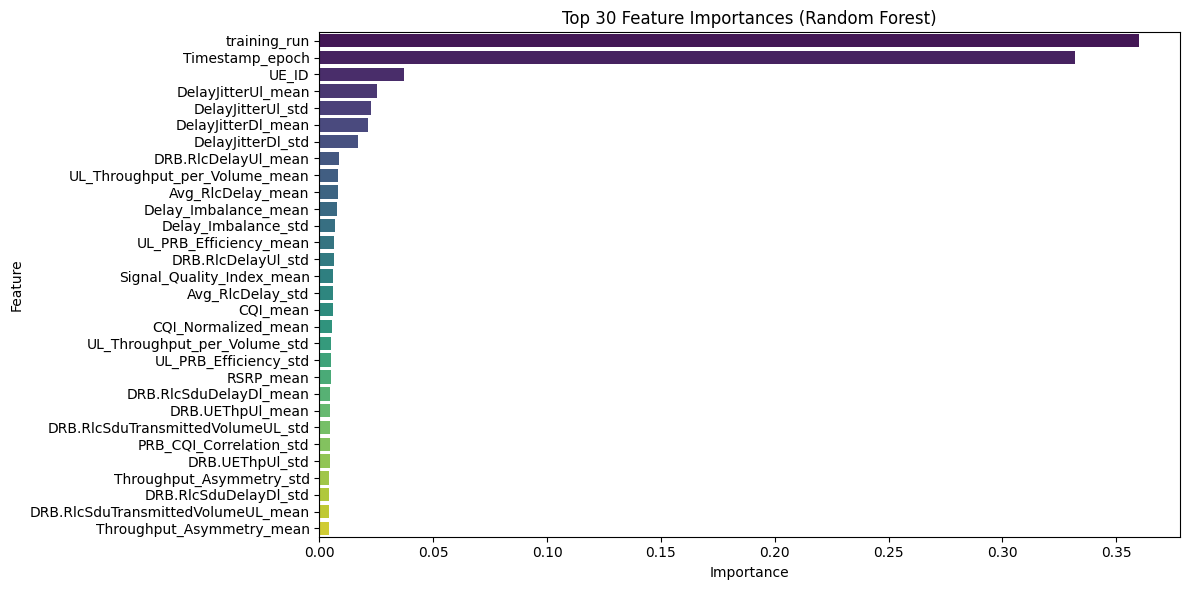

In [40]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin, selected_features, preprocessor = prepare_stage1_data(df, seq_len=SEQ_LEN)

Already have results for: ['AttentionGRU', 'AttentionLSTM', 'BiLSTM', 'CNN1D', 'CNN_GRU', 'CNN_LSTM', 'GRU', 'LSTM', 'MLP', 'Transformer']
Still need to run: []

--- Running evaluate_model_predictions for ALL models ---

--- Evaluating MLP for Stage 1 Binary ---

--- Evaluating Stage1_Binary_MLP ---
              precision    recall  f1-score   support

      benign       0.75      0.74      0.74      7401
   malicious       0.65      0.67      0.66      5430

    accuracy                           0.71     12831
   macro avg       0.70      0.70      0.70     12831
weighted avg       0.71      0.71      0.71     12831



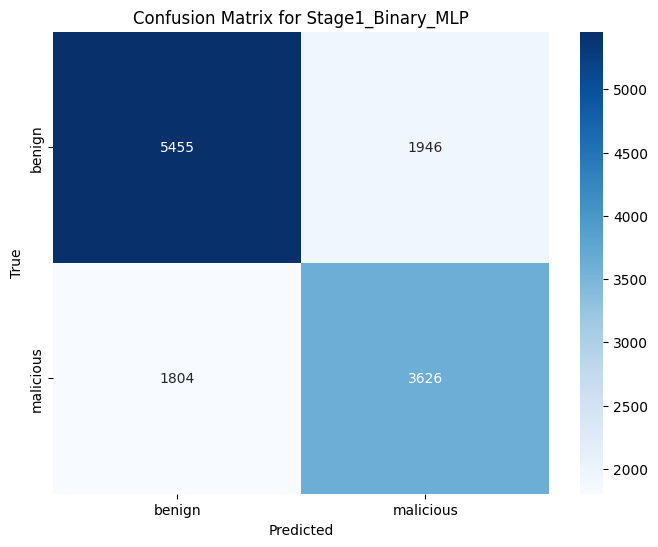

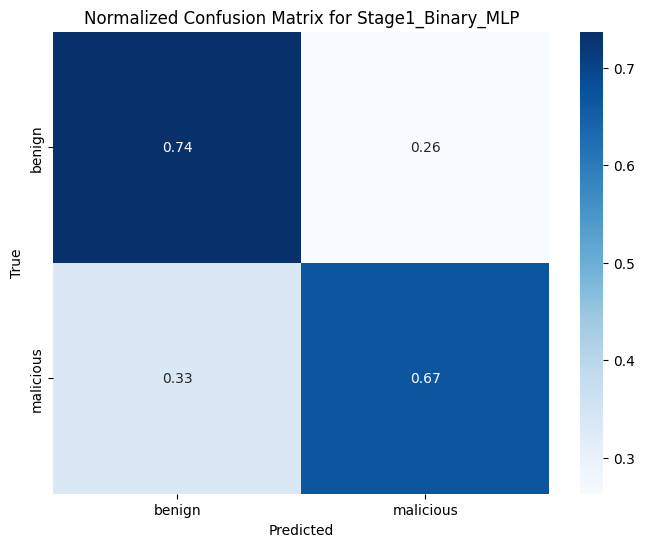

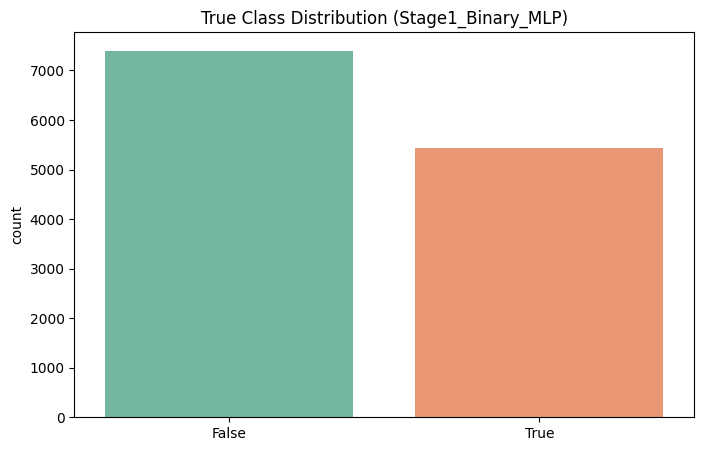

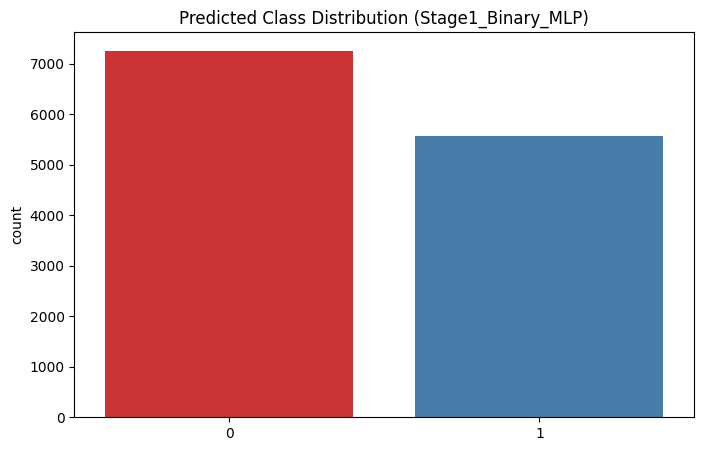

  Accuracy: 0.7077
  F1-Macro: 0.7017
  F1-Weighted: 0.7082

--- Evaluating CNN1D for Stage 1 Binary ---

--- Evaluating Stage1_Binary_CNN1D ---
              precision    recall  f1-score   support

      benign       0.74      0.77      0.75      7401
   malicious       0.67      0.63      0.65      5430

    accuracy                           0.71     12831
   macro avg       0.70      0.70      0.70     12831
weighted avg       0.71      0.71      0.71     12831



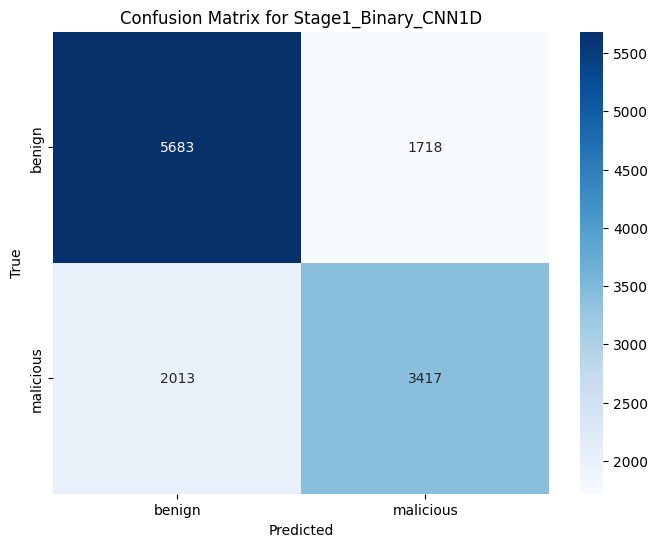

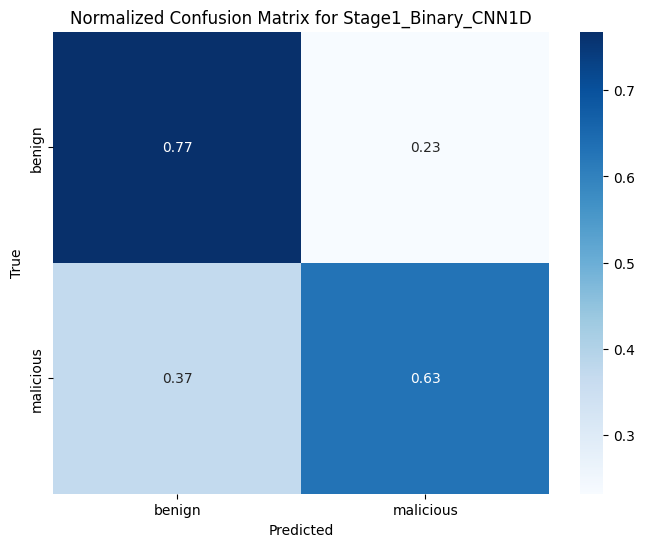

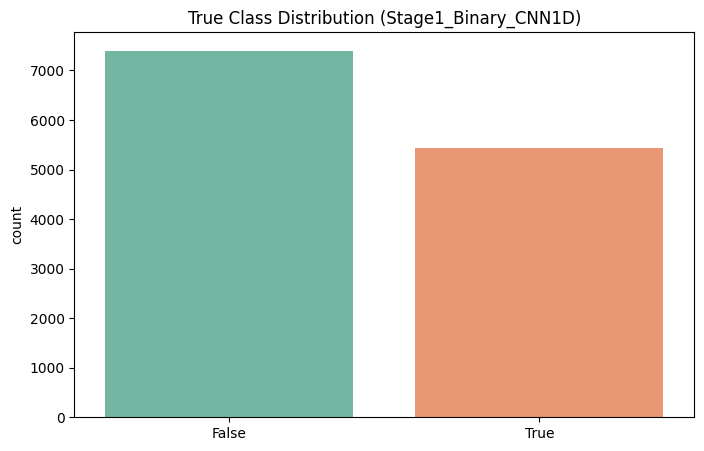

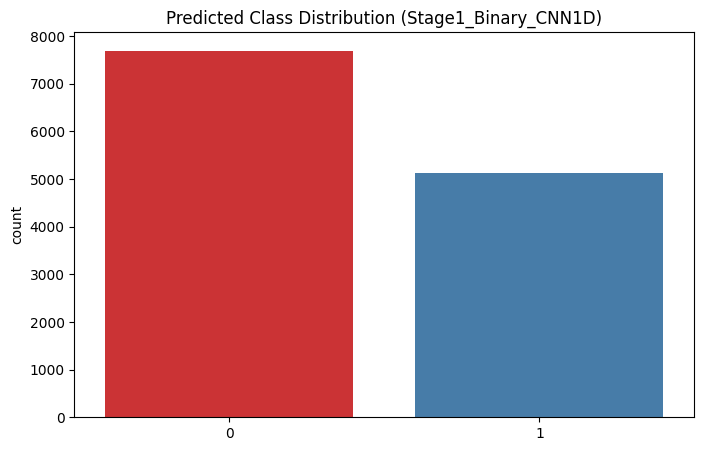

  Accuracy: 0.7092
  F1-Macro: 0.6999
  F1-Weighted: 0.7080

--- Evaluating LSTM for Stage 1 Binary ---

--- Evaluating Stage1_Binary_LSTM ---
              precision    recall  f1-score   support

      benign       0.75      0.70      0.72      7401
   malicious       0.63      0.69      0.66      5430

    accuracy                           0.69     12831
   macro avg       0.69      0.69      0.69     12831
weighted avg       0.70      0.69      0.70     12831



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.lstm(


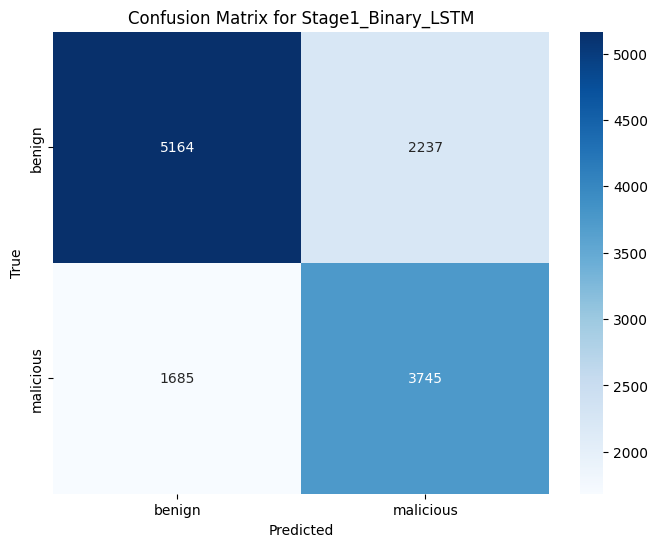

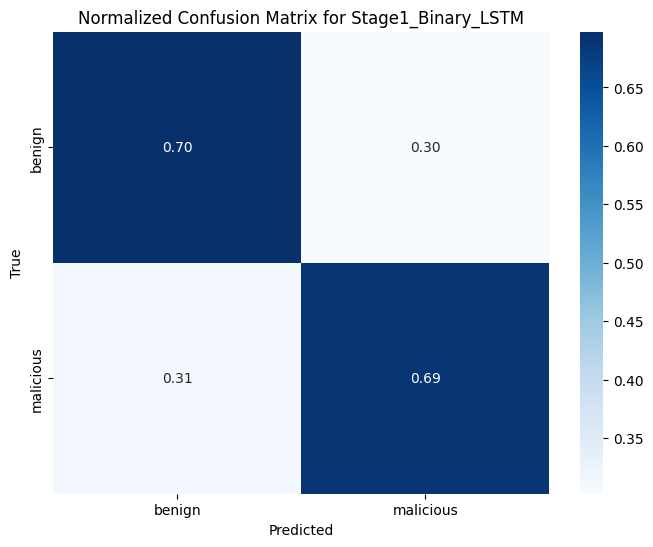

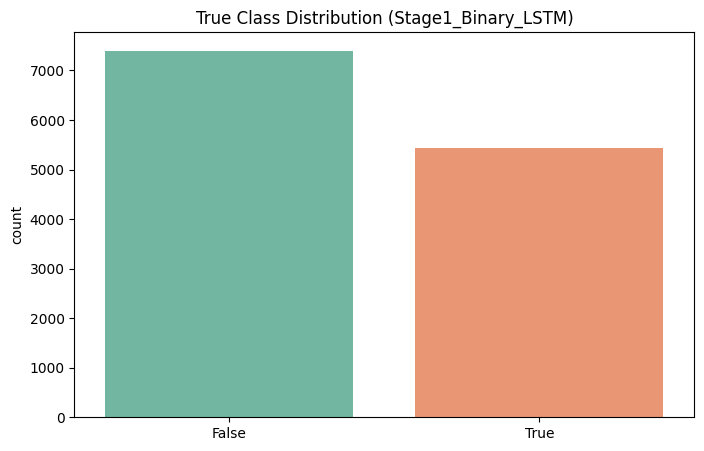

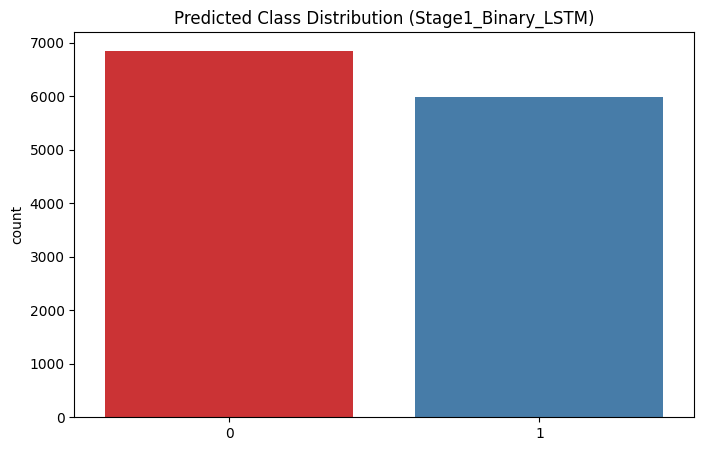

  Accuracy: 0.6943
  F1-Macro: 0.6905
  F1-Weighted: 0.6958

--- Evaluating CNN_LSTM for Stage 1 Binary ---

--- Evaluating Stage1_Binary_CNN_LSTM ---
              precision    recall  f1-score   support

      benign       0.73      0.75      0.74      7401
   malicious       0.65      0.63      0.64      5430

    accuracy                           0.70     12831
   macro avg       0.69      0.69      0.69     12831
weighted avg       0.70      0.70      0.70     12831



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.lstm(


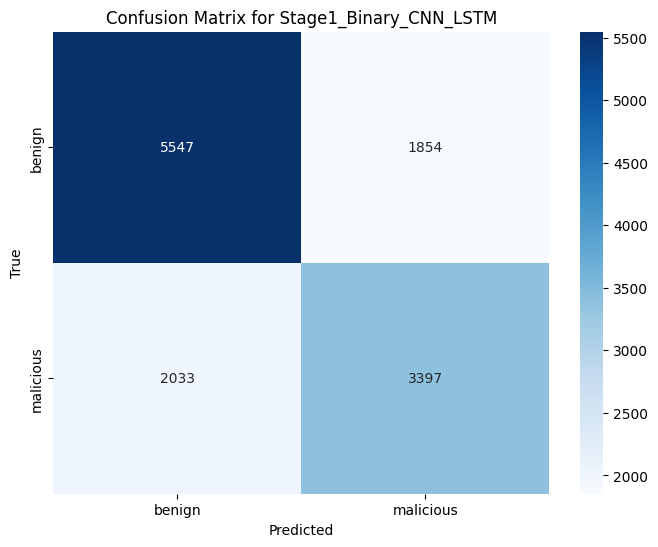

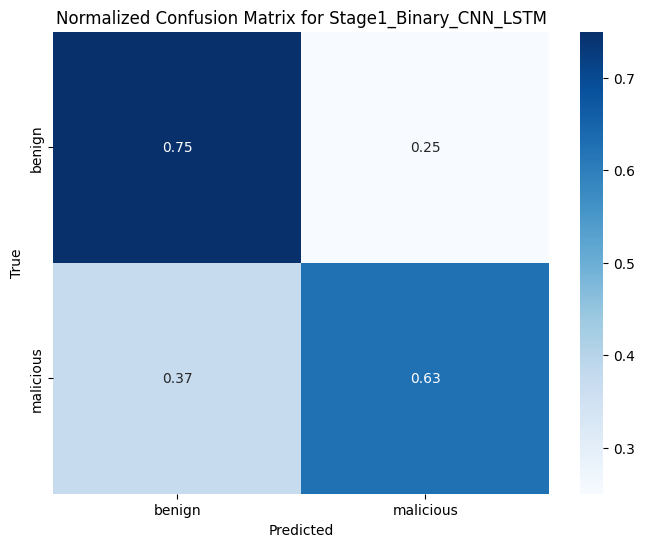

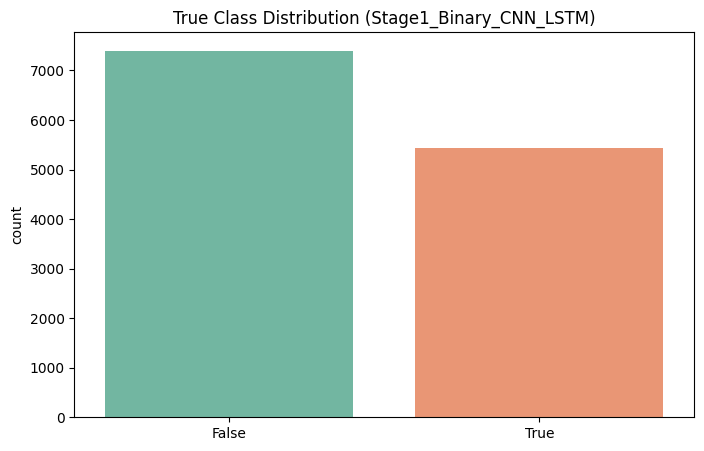

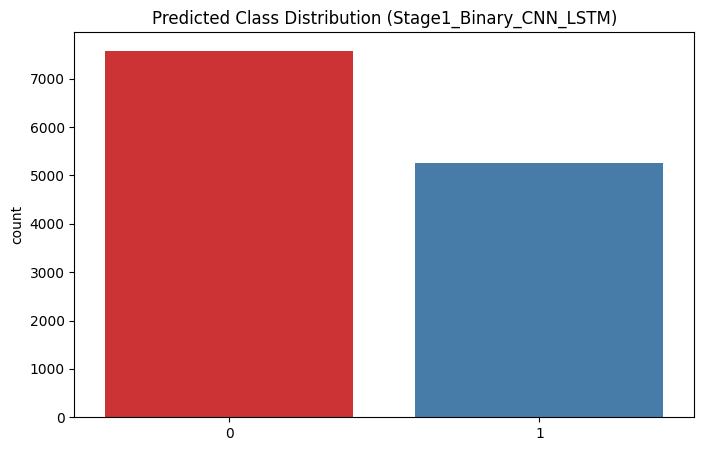

  Accuracy: 0.6971
  F1-Macro: 0.6883
  F1-Weighted: 0.6963

--- Evaluating GRU for Stage 1 Binary ---

--- Evaluating Stage1_Binary_GRU ---
              precision    recall  f1-score   support

      benign       0.76      0.70      0.73      7401
   malicious       0.63      0.70      0.67      5430

    accuracy                           0.70     12831
   macro avg       0.70      0.70      0.70     12831
weighted avg       0.71      0.70      0.70     12831



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1393: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.gru(


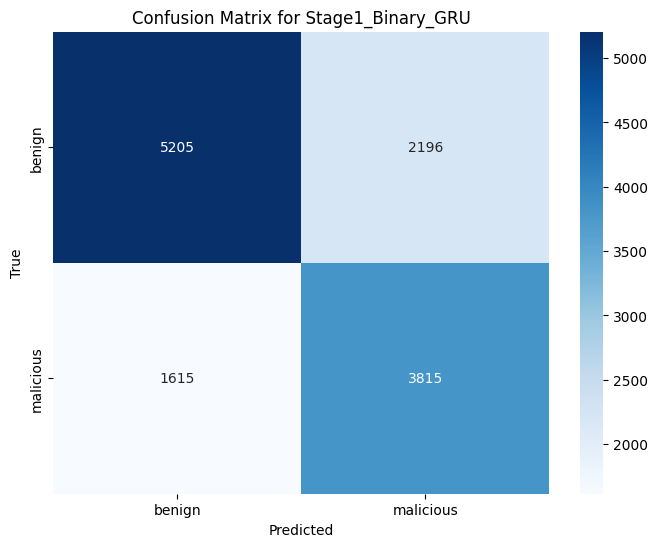

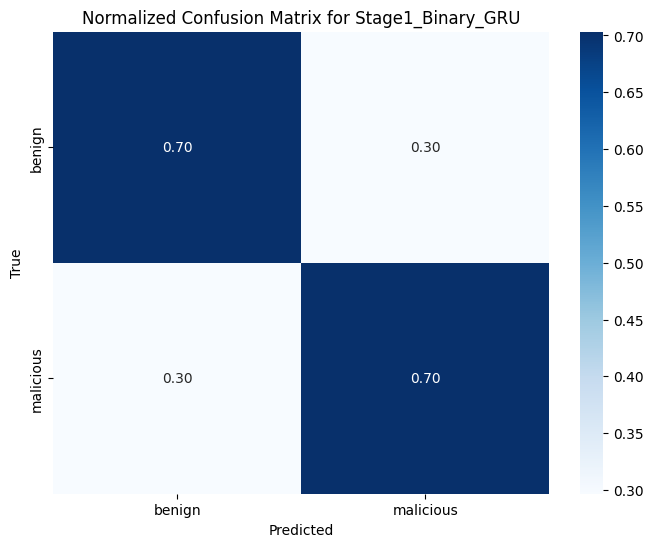

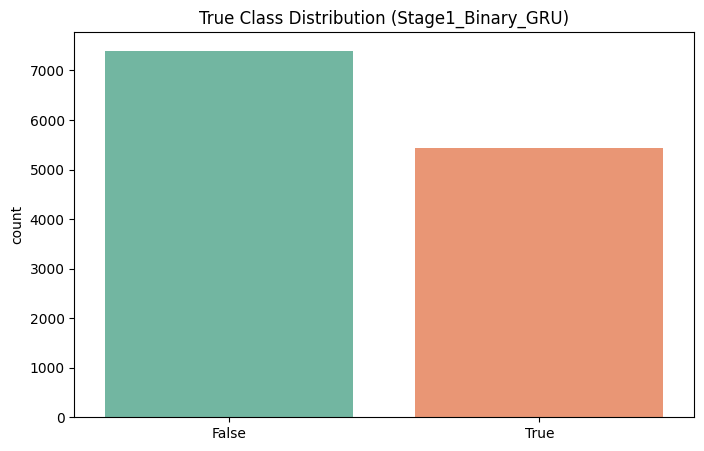

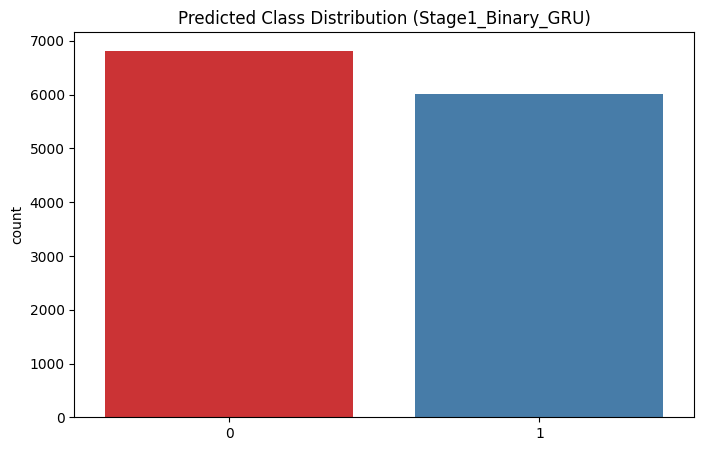

  Accuracy: 0.7030
  F1-Macro: 0.6995
  F1-Weighted: 0.7045

--- Evaluating BiLSTM for Stage 1 Binary ---


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.lstm(



--- Evaluating Stage1_Binary_BiLSTM ---
              precision    recall  f1-score   support

      benign       0.74      0.70      0.72      7401
   malicious       0.62      0.66      0.64      5430

    accuracy                           0.68     12831
   macro avg       0.68      0.68      0.68     12831
weighted avg       0.69      0.68      0.68     12831



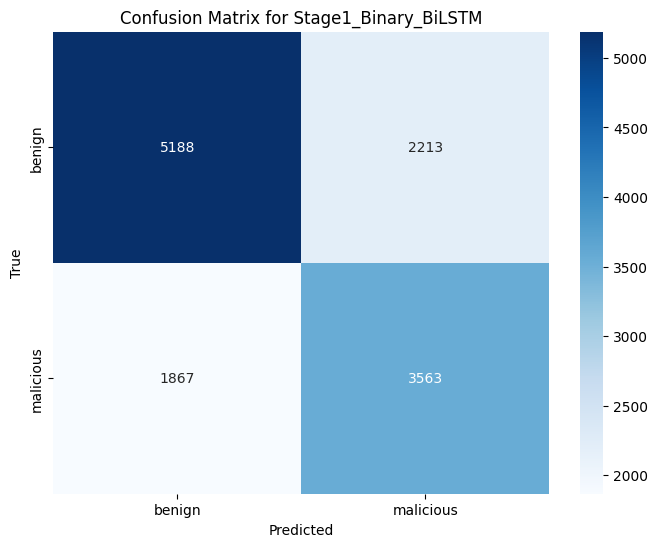

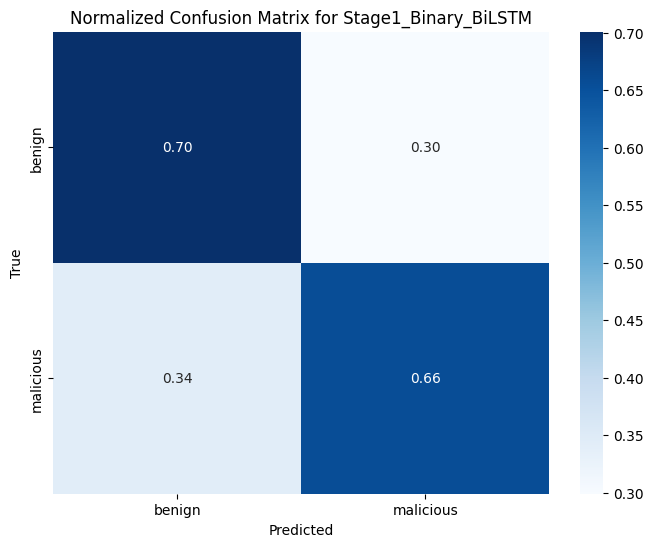

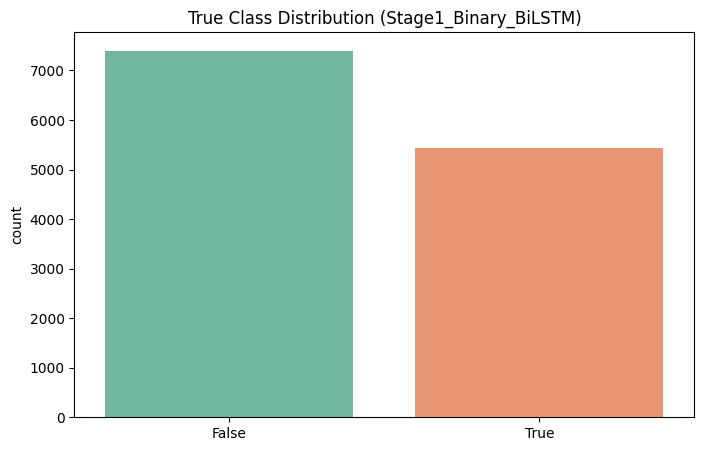

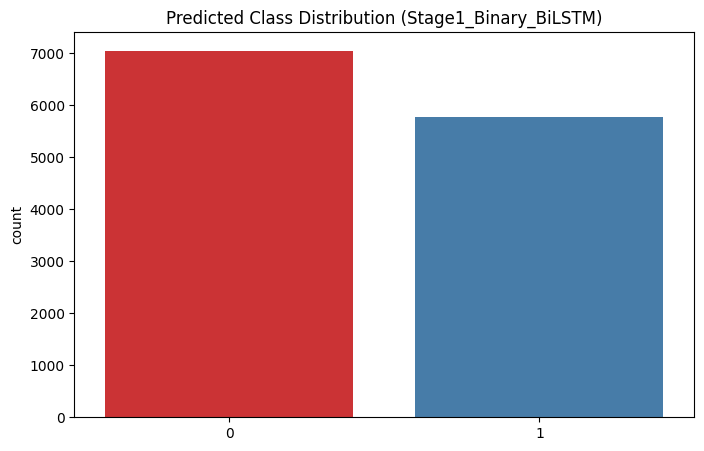

  Accuracy: 0.6820
  F1-Macro: 0.6768
  F1-Weighted: 0.6831

--- Evaluating CNN_GRU for Stage 1 Binary ---

--- Evaluating Stage1_Binary_CNN_GRU ---
              precision    recall  f1-score   support

      benign       0.74      0.69      0.71      7401
   malicious       0.61      0.66      0.64      5430

    accuracy                           0.68     12831
   macro avg       0.67      0.68      0.67     12831
weighted avg       0.68      0.68      0.68     12831



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1393: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.gru(


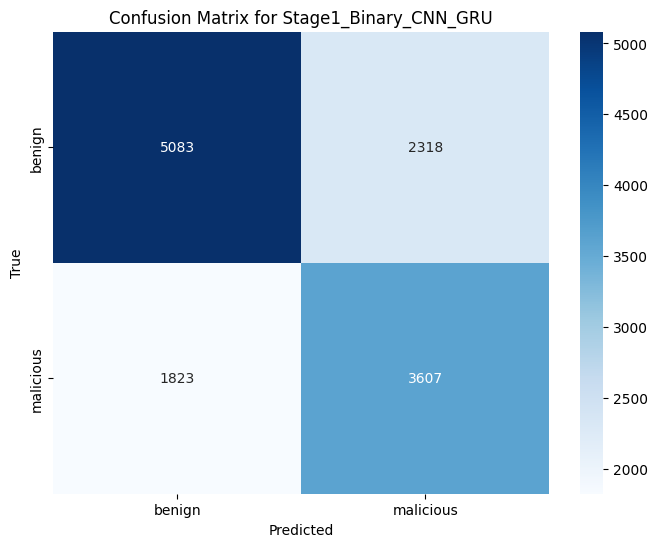

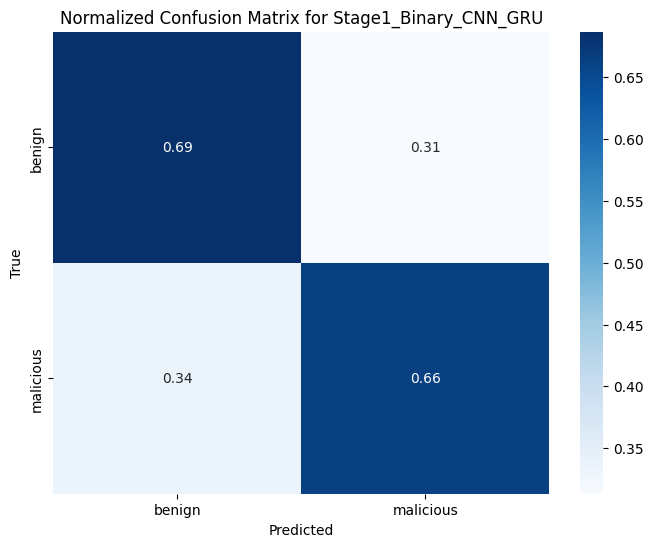

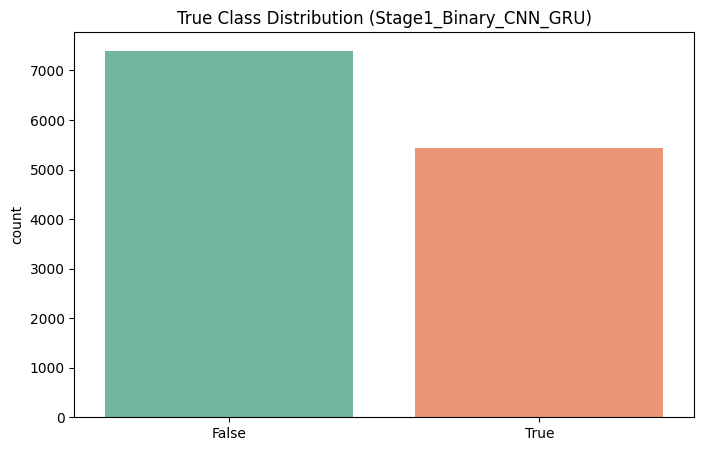

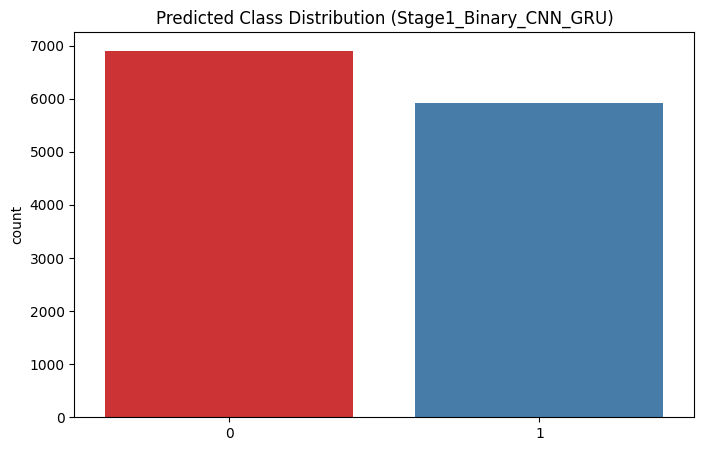

  Accuracy: 0.6773
  F1-Macro: 0.6729
  F1-Weighted: 0.6787

--- Evaluating AttentionLSTM for Stage 1 Binary ---

--- Evaluating Stage1_Binary_AttentionLSTM ---
              precision    recall  f1-score   support

      benign       0.76      0.76      0.76      7401
   malicious       0.67      0.68      0.68      5430

    accuracy                           0.72     12831
   macro avg       0.72      0.72      0.72     12831
weighted avg       0.72      0.72      0.72     12831



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.lstm(


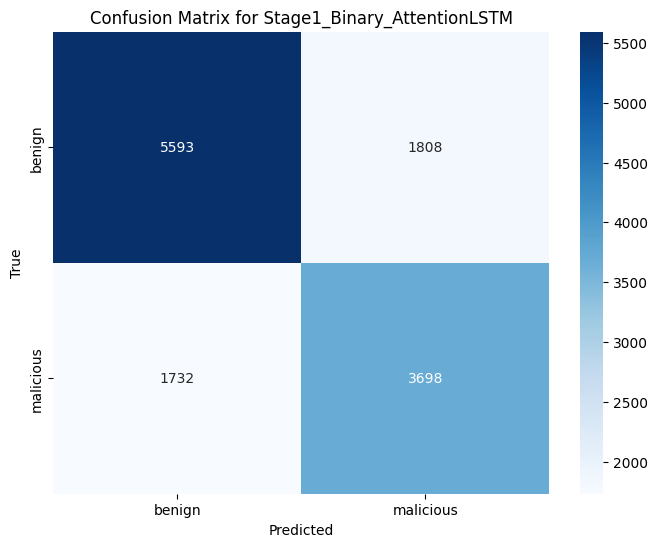

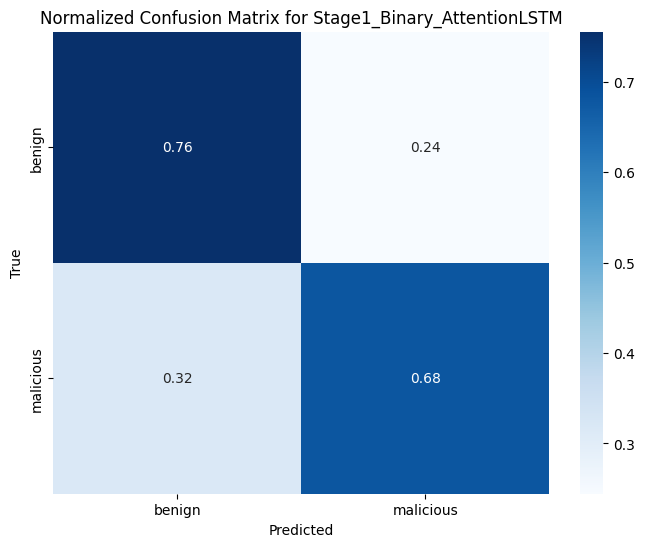

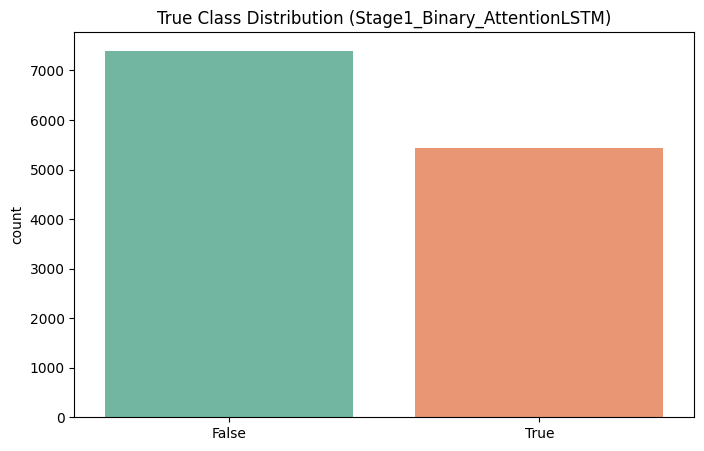

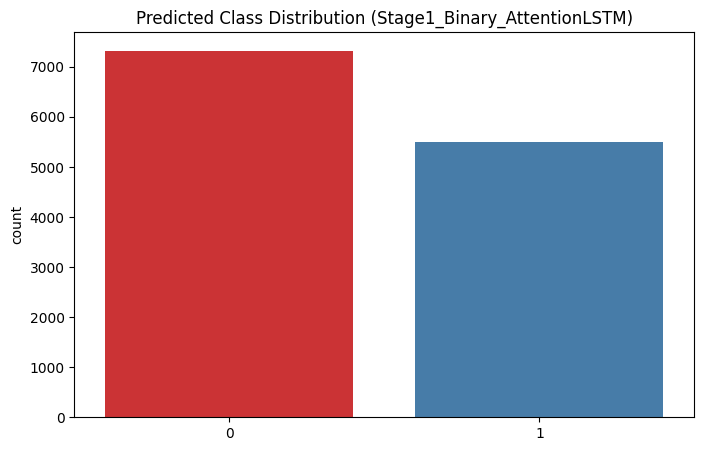

  Accuracy: 0.7241
  F1-Macro: 0.7180
  F1-Weighted: 0.7244

--- Evaluating AttentionGRU for Stage 1 Binary ---

--- Evaluating Stage1_Binary_AttentionGRU ---
              precision    recall  f1-score   support

      benign       0.75      0.76      0.75      7401
   malicious       0.67      0.66      0.66      5430

    accuracy                           0.72     12831
   macro avg       0.71      0.71      0.71     12831
weighted avg       0.72      0.72      0.72     12831



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1393: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.gru(


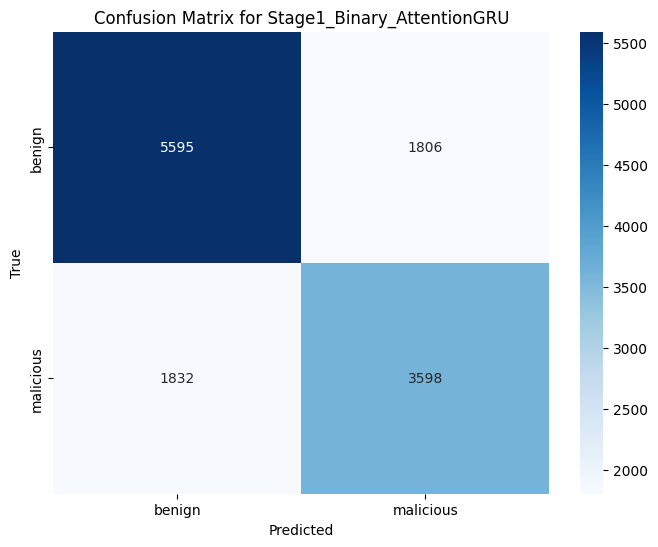

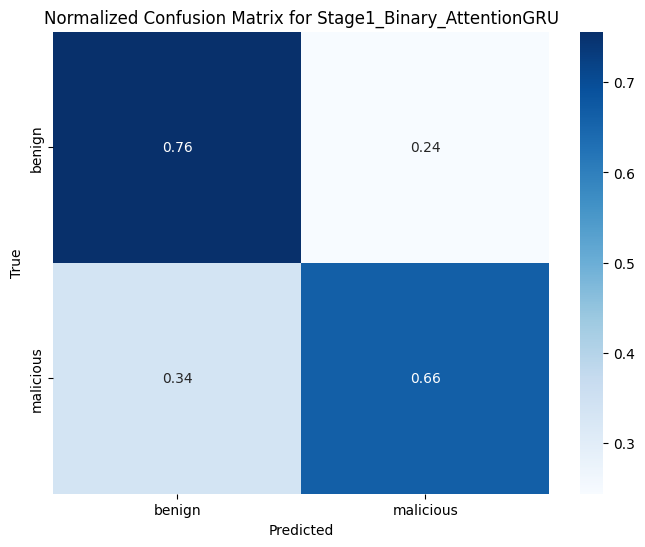

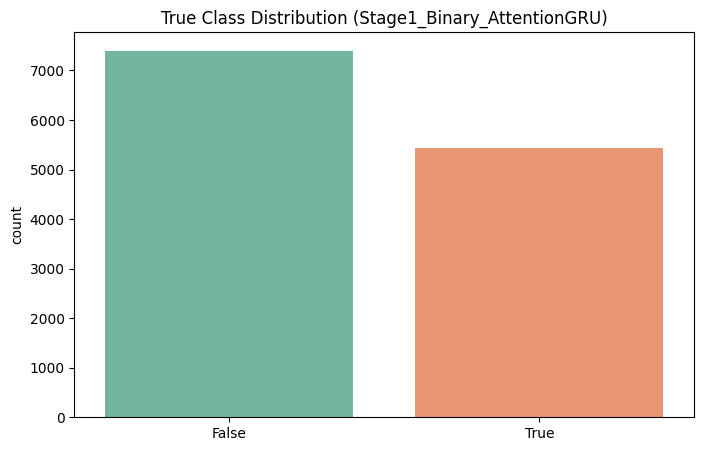

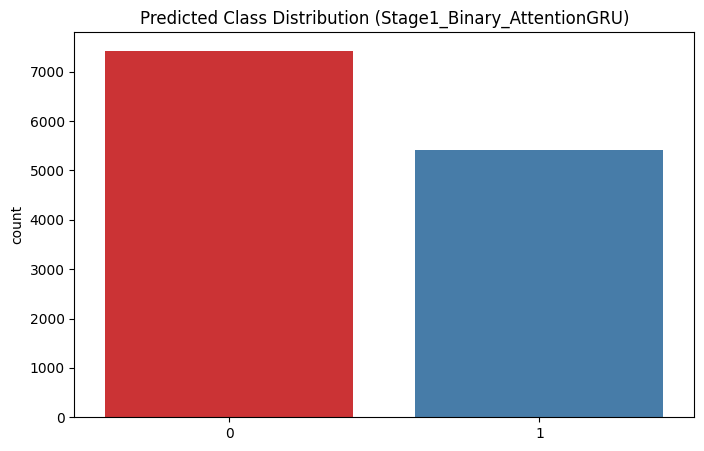

  Accuracy: 0.7165
  F1-Macro: 0.7094
  F1-Weighted: 0.7164

--- Evaluating Transformer for Stage 1 Binary ---

--- Evaluating Stage1_Binary_Transformer ---
              precision    recall  f1-score   support

      benign       0.76      0.77      0.77      7401
   malicious       0.69      0.67      0.68      5430

    accuracy                           0.73     12831
   macro avg       0.72      0.72      0.72     12831
weighted avg       0.73      0.73      0.73     12831



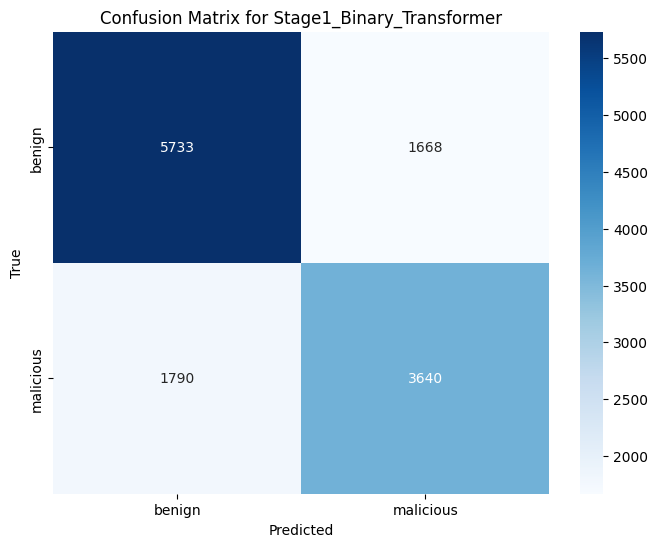

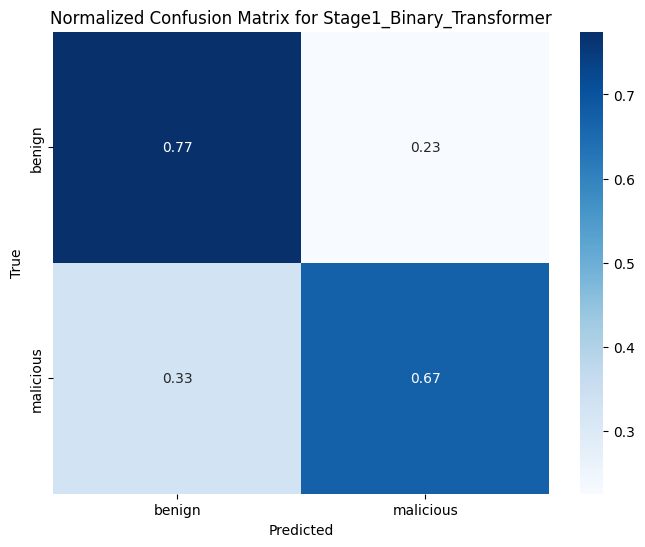

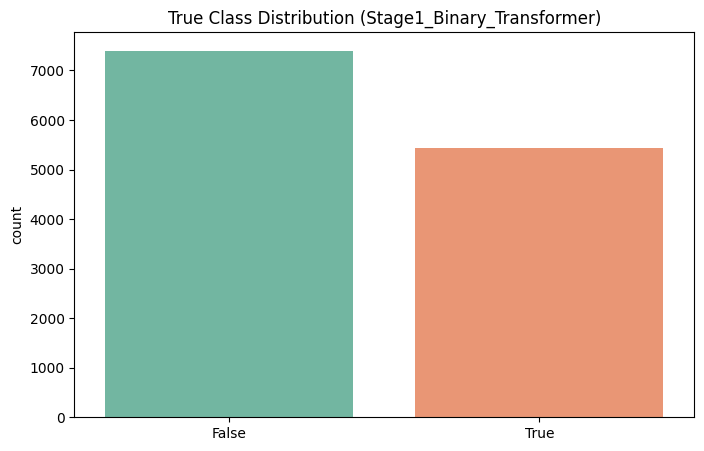

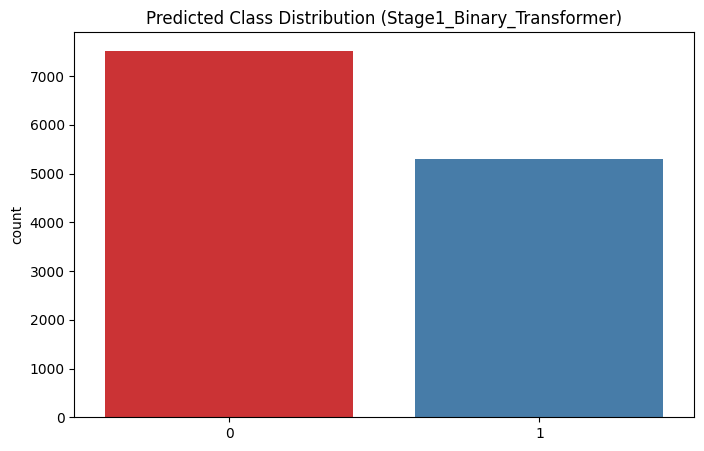

  Accuracy: 0.7305
  F1-Macro: 0.7231
  F1-Weighted: 0.7301

Best Stage 1 Binary model: Transformer with F1-macro=0.723


In [41]:

models_to_try = ["MLP","CNN1D","LSTM","CNN_LSTM","GRU","BiLSTM","CNN_GRU","AttentionLSTM","AttentionGRU","Transformer"]
results_binary = load_results_per_model(models_to_try, "stage1_binary")
already_done = set(results_binary.keys())
to_run = [m for m in models_to_try if m not in already_done]

print(f"Already have results for: {sorted(already_done)}")
print(f"Still need to run: {sorted(to_run)}")

for model_name in to_run:
    print(f"\n--- Training {model_name} for Stage 1 Binary ---")
    
    try:
        pretrained_model = None
        if model_name in ["MLP", "CNN1D", "LSTM", "CNN_LSTM", "GRU", "BiLSTM",
                          "CNN_GRU", "AttentionLSTM", "AttentionGRU", "Transformer"]:
            pretrained_model = pretrain_pytorch_model(
                model_name=model_name,
                X=X_train_bin,
                y=y_train_bin,
                num_classes=2,
                seq_len=SEQ_LEN,
                epochs=10
            )

        best_trial, study = run_tuning_and_train(
            model_name=model_name,
            X_train=X_train_bin,
            y_train=y_train_bin,
            n_trials=10,
            num_classes=2,
            seq_len=SEQ_LEN,
            pretrained_model=pretrained_model
        )

        # Retrieve final trained model
        if model_name in ["MLP", "CNN1D", "LSTM", "CNN_LSTM", "GRU", "BiLSTM",
                          "CNN_GRU", "AttentionLSTM", "AttentionGRU", "Transformer"]:
            model = best_trial.user_attrs.get("trained_model")
            if model is None:
                print(f"Warning: trained_model not found for {model_name}, skipping.")
                continue
        else:
            model = _create_classical_model(model_name, best_trial.params)
            # Flatten for classical models
            X_train_flat = X_train_bin.reshape(X_train_bin.shape[0], -1)
            model.fit(X_train_flat, y_train_bin)

        # Evaluate using corrected function
        print("DEBUG model:", model, type(model))
        y_pred = evaluate_model_predictions(model, model_name, X_test_bin, y_test_bin)

        metrics_dict = evaluate_classification(
            model, f"Stage1_Binary_{model_name}",
            X_test=X_test_bin, y_test=y_test_bin,
            target_names=['benign','malicious'],
            y_pred=y_pred
        )

        model_result = {
            "model": model,
            "optuna_study": study,
            "accuracy": accuracy_score(y_test_bin, y_pred),
            "f1_macro": metrics_dict['macro avg']['f1-score'],
            "f1_weighted": metrics_dict['weighted avg']['f1-score'],
            "classification_report": metrics_dict,
            "confusion_matrix": confusion_matrix(y_test_bin, y_pred)
        }

        save_results_per_model({model_name: model_result}, "stage1_binary")
        save_artifacts(model, selected_features, study, model_name, "stage1_binary")
        results_binary[model_name] = model_result

        print(f"Saved and evaluated {model_name} successfully.")
        
        # Clear GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    except Exception as e:
        print(f"Skipping {model_name} due to error: {type(e).__name__}: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

# Evaluate ALL models (including already done ones) using evaluate_model_predictions
print(f"\n--- Running evaluate_model_predictions for ALL models ---")
for model_name in models_to_try:
    print(f"\n--- Evaluating {model_name} for Stage 1 Binary ---")
    
    try:
        # Load the model (either from results_binary or from artifacts)
        if model_name in results_binary:
            model = results_binary[model_name]['model']
        else:
            # Try to load from artifacts
            artifacts = load_artifacts(model_name, "stage1_binary")
            if artifacts is None:
                print(f"No model found for {model_name}, skipping.")
                continue
            model, _ = artifacts
            if isinstance(model, tuple):
                model = model[0]
        
        # Run evaluate_model_predictions
        y_pred = evaluate_model_predictions(model, model_name, X_test_bin, y_test_bin)
        
        evaluate_classification(
            model, f"Stage1_Binary_{model_name}",
            X_test=X_test_bin, y_test=y_test_bin,
            target_names=['benign','malicious'],
            y_pred=y_pred
        )
        # Print basic metrics
        accuracy = accuracy_score(y_test_bin, y_pred)
        f1_macro = f1_score(y_test_bin, y_pred, average='macro')
        f1_weighted = f1_score(y_test_bin, y_pred, average='weighted')
        
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  F1-Macro: {f1_macro:.4f}")
        print(f"  F1-Weighted: {f1_weighted:.4f}")
        
    except Exception as e:
        print(f"Error evaluating {model_name}: {type(e).__name__}: {str(e)}")
        continue

# Select best model
best_model_name = max(results_binary, key=lambda k: results_binary[k]['f1_macro'])
print(f"\nBest Stage 1 Binary model: {best_model_name} with F1-macro={results_binary[best_model_name]['f1_macro']:.3f}")

Stage 2a benign classes: ['embb' 'mtc' 'urllc' 'voip']
Number of classes expected: 4

--- Running evaluate_model_predictions for ALL Stage 2a Benign models ---

--- Evaluating MLP for Stage 2a Benign ---

--- Evaluating Stage2_Benign_MLP ---
              precision    recall  f1-score   support

        embb       0.47      0.47      0.47      2292
         mtc       0.21      0.20      0.20      1147
       urllc       0.33      0.23      0.27       834
        voip       0.62      0.68      0.65      3128

    accuracy                           0.49      7401
   macro avg       0.41      0.39      0.40      7401
weighted avg       0.48      0.49      0.48      7401



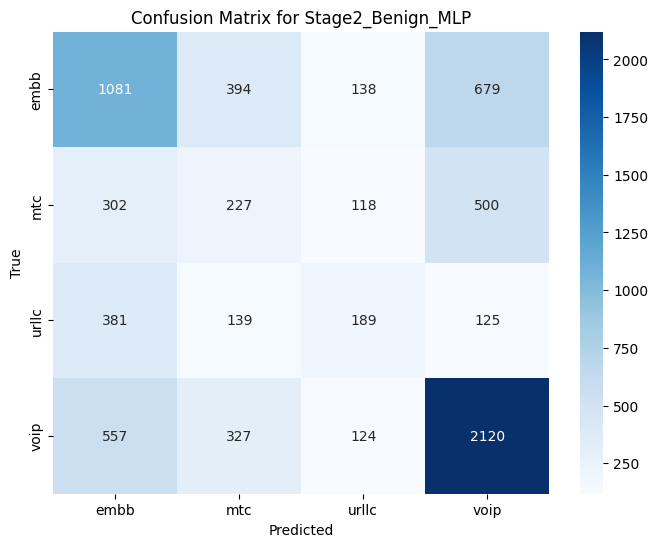

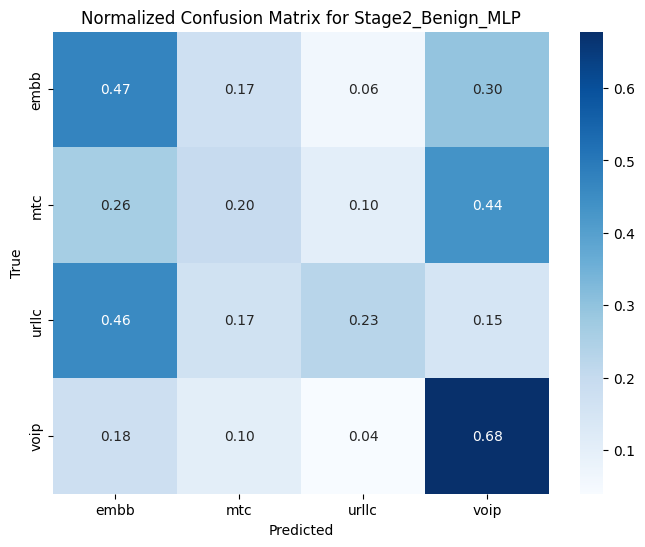

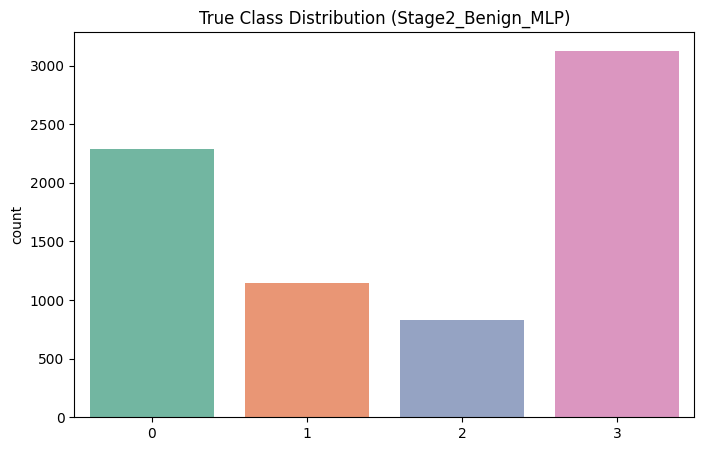

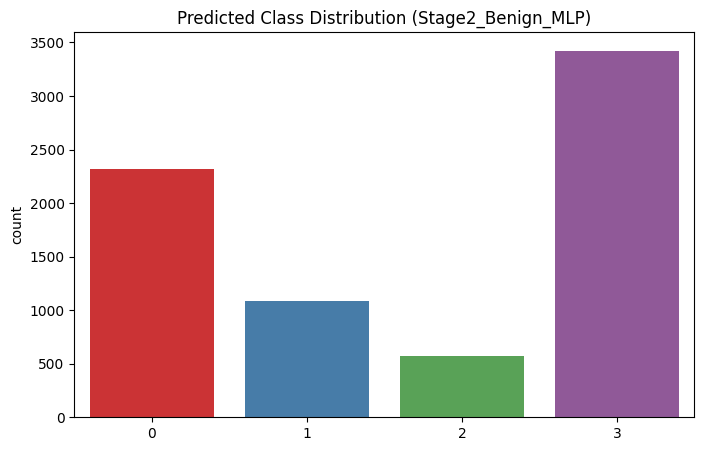

  Accuracy: 0.4887
  F1-Macro: 0.3971
  F1-Weighted: 0.4805

--- Evaluating CNN1D for Stage 2a Benign ---

--- Evaluating Stage2_Benign_CNN1D ---
              precision    recall  f1-score   support

        embb       0.47      0.47      0.47      2292
         mtc       0.30      0.17      0.22      1147
       urllc       0.30      0.32      0.31       834
        voip       0.61      0.69      0.65      3128

    accuracy                           0.50      7401
   macro avg       0.42      0.41      0.41      7401
weighted avg       0.48      0.50      0.49      7401



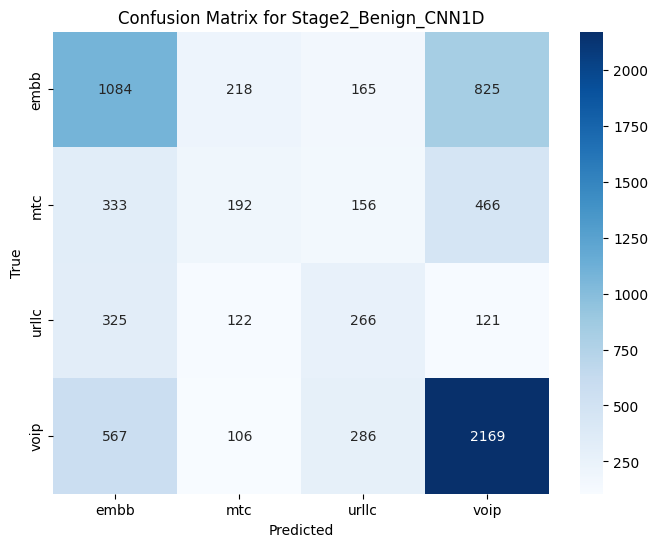

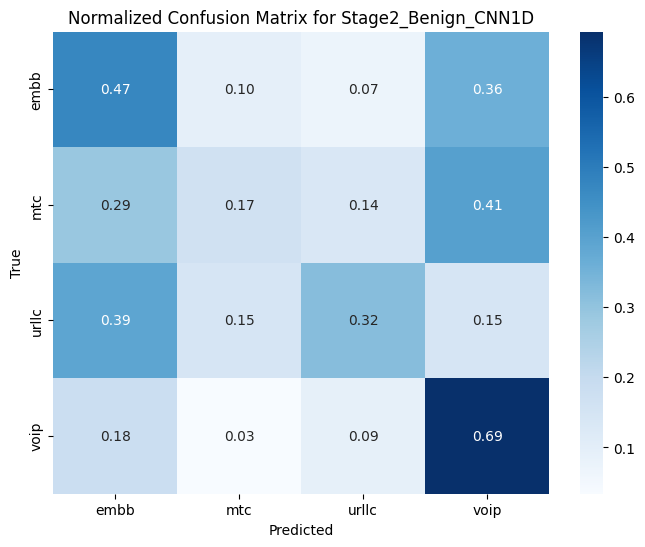

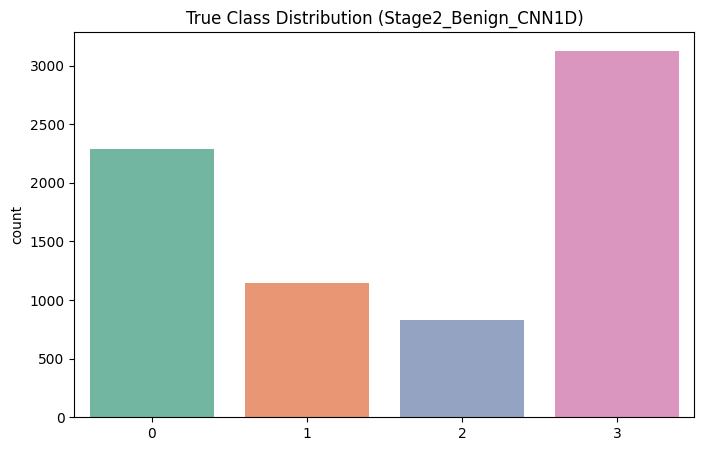

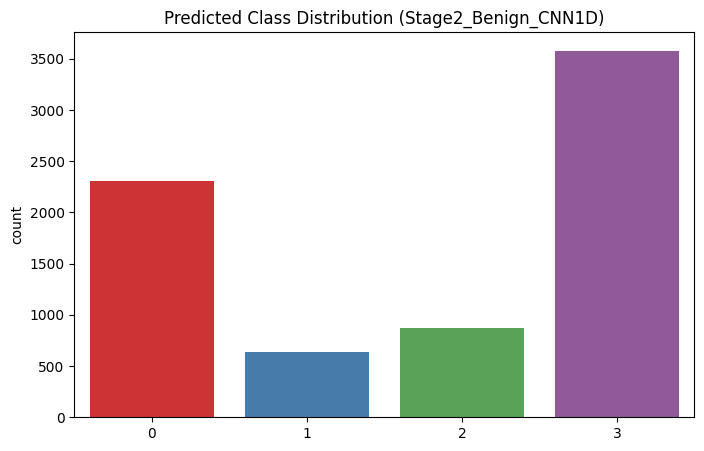

  Accuracy: 0.5014
  F1-Macro: 0.4111
  F1-Weighted: 0.4877

--- Evaluating LSTM for Stage 2a Benign ---

--- Evaluating Stage2_Benign_LSTM ---
              precision    recall  f1-score   support

        embb       0.46      0.45      0.46      2292
         mtc       0.32      0.39      0.35      1147
       urllc       0.17      0.16      0.17       834
        voip       0.70      0.67      0.69      3128

    accuracy                           0.50      7401
   macro avg       0.41      0.42      0.42      7401
weighted avg       0.51      0.50      0.51      7401



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.lstm(


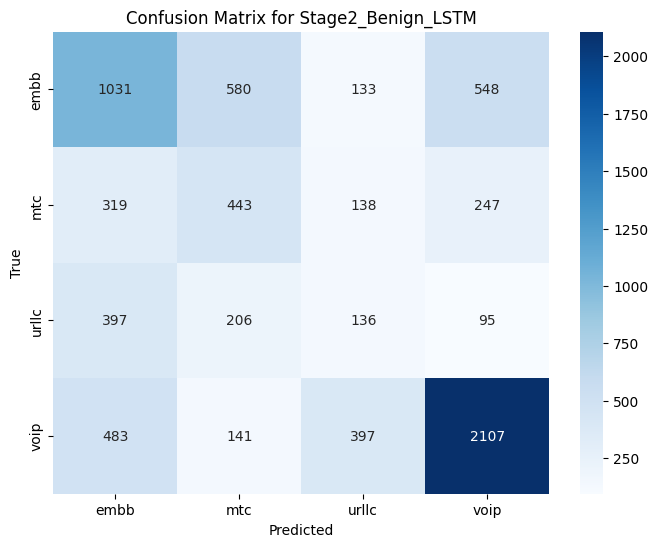

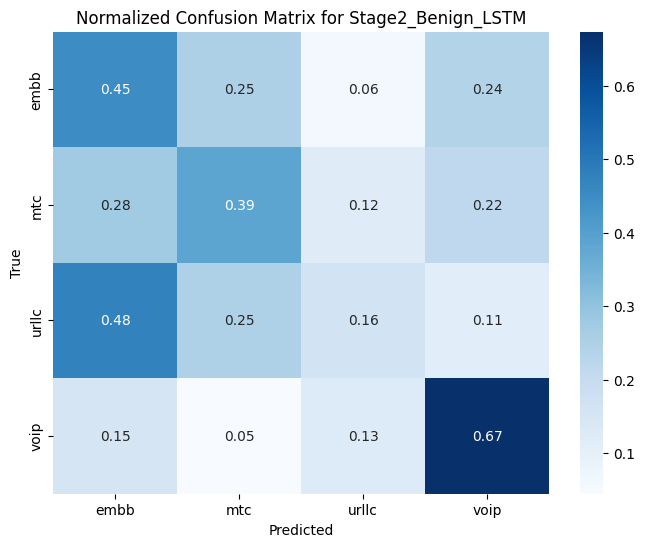

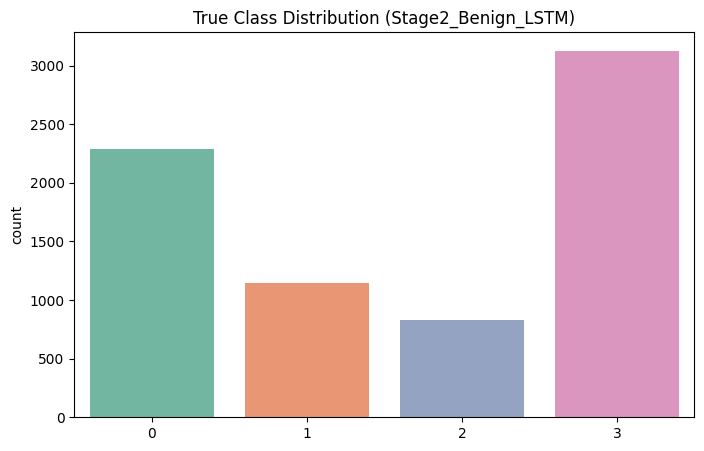

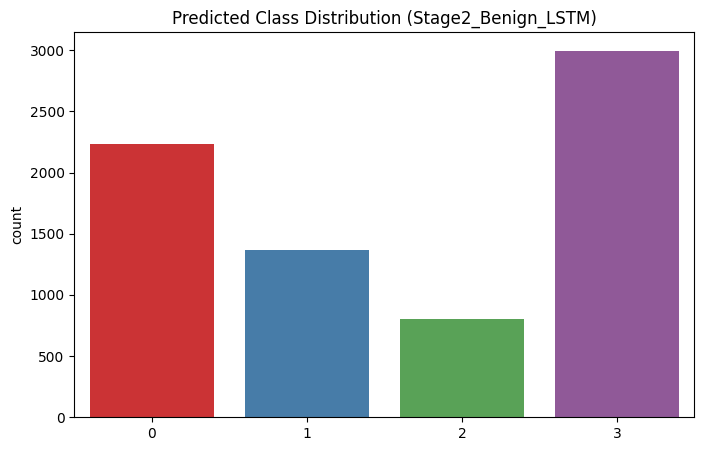

  Accuracy: 0.5022
  F1-Macro: 0.4155
  F1-Weighted: 0.5053

--- Evaluating CNN_LSTM for Stage 2a Benign ---

--- Evaluating Stage2_Benign_CNN_LSTM ---
              precision    recall  f1-score   support

        embb       0.49      0.54      0.51      2292
         mtc       0.41      0.42      0.42      1147
       urllc       0.17      0.15      0.16       834
        voip       0.67      0.63      0.65      3128

    accuracy                           0.52      7401
   macro avg       0.44      0.44      0.44      7401
weighted avg       0.52      0.52      0.52      7401



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.lstm(


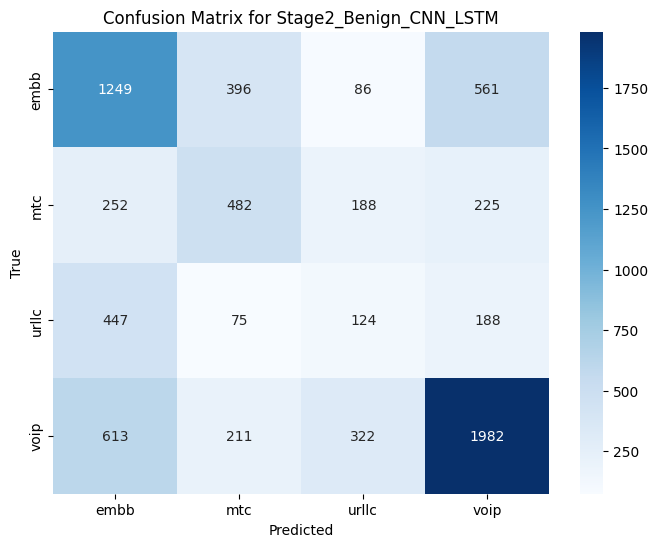

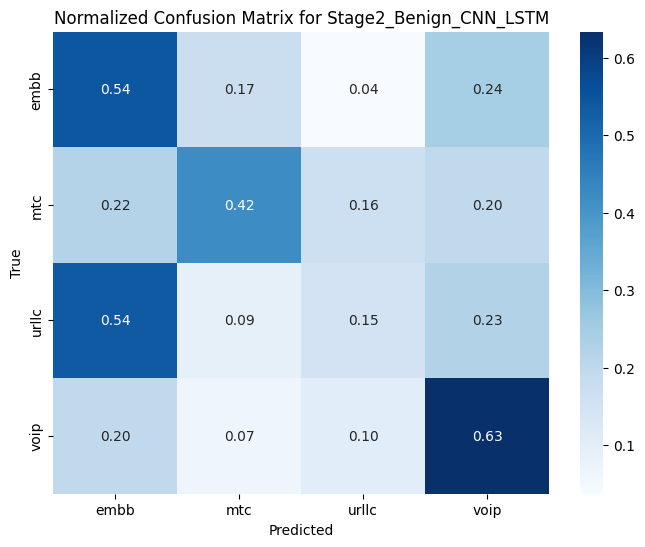

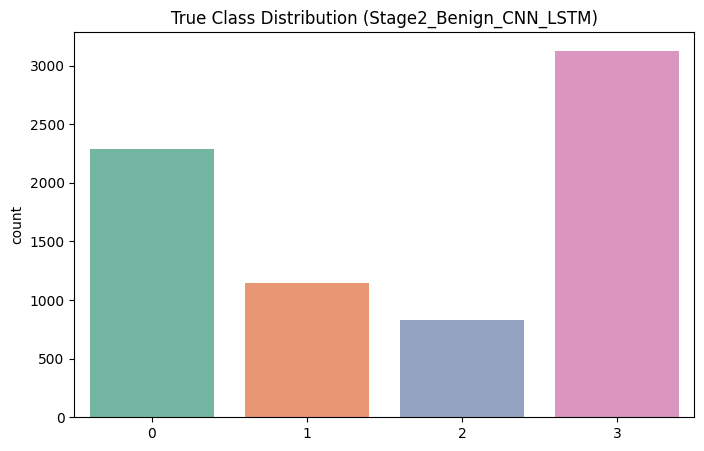

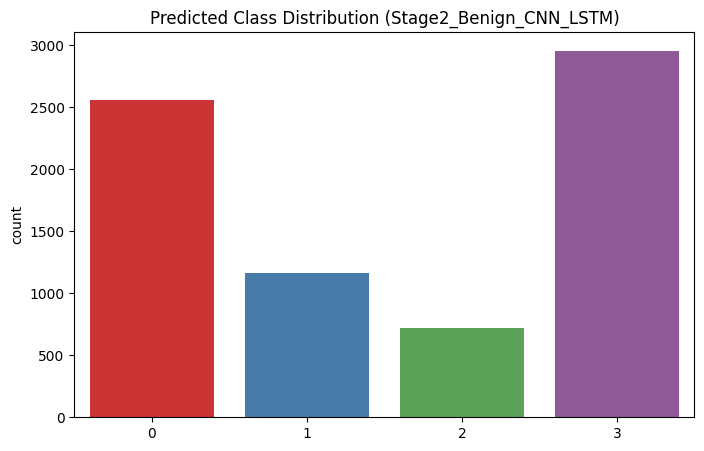

  Accuracy: 0.5184
  F1-Macro: 0.4358
  F1-Weighted: 0.5174

--- Evaluating GRU for Stage 2a Benign ---

--- Evaluating Stage2_Benign_GRU ---
              precision    recall  f1-score   support

        embb       0.41      0.40      0.40      2292
         mtc       0.29      0.32      0.30      1147
       urllc       0.19      0.16      0.17       834
        voip       0.60      0.62      0.61      3128

    accuracy                           0.45      7401
   macro avg       0.37      0.37      0.37      7401
weighted avg       0.45      0.45      0.45      7401



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1393: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.gru(


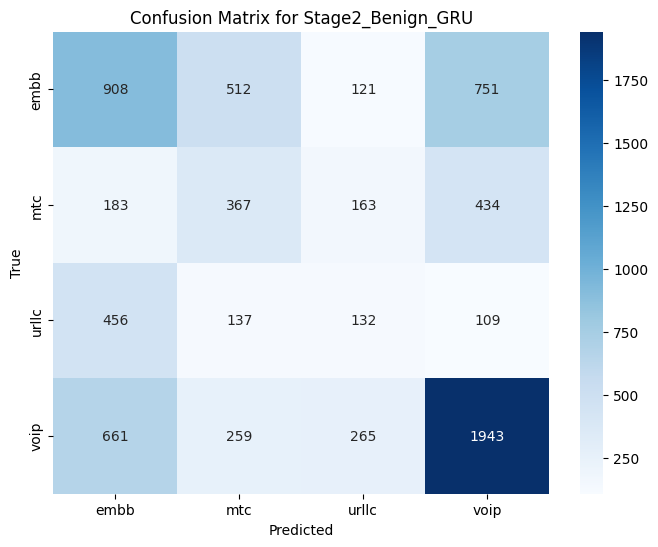

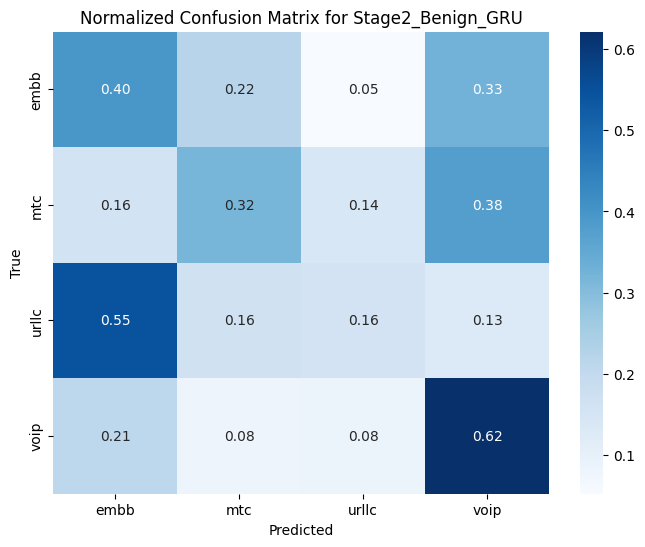

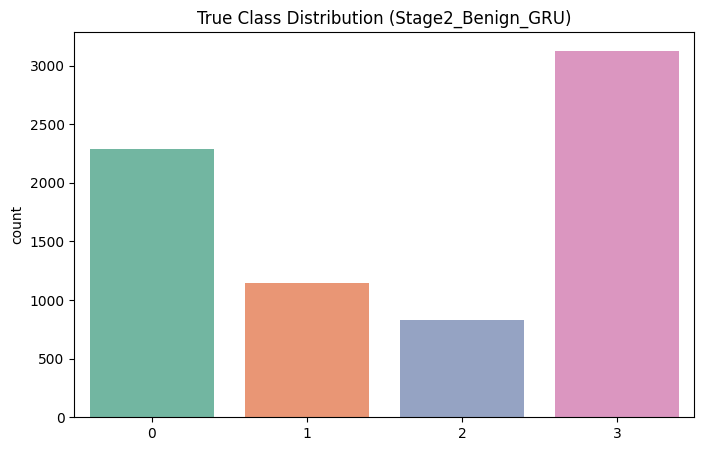

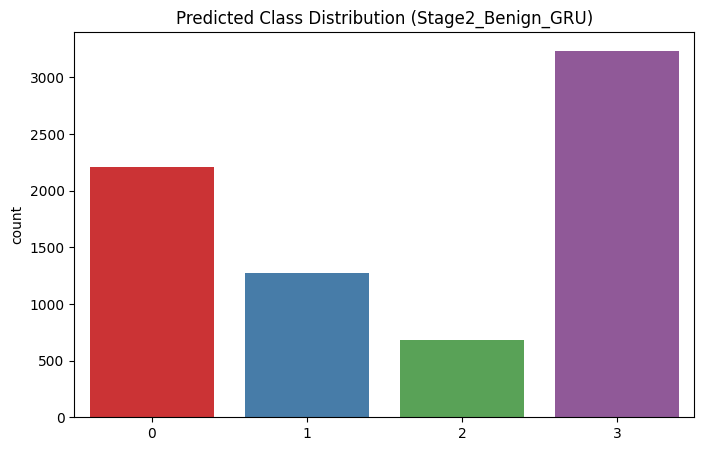

  Accuracy: 0.4526
  F1-Macro: 0.3728
  F1-Weighted: 0.4496

--- Evaluating BiLSTM for Stage 2a Benign ---

--- Evaluating Stage2_Benign_BiLSTM ---
              precision    recall  f1-score   support

        embb       0.45      0.42      0.43      2292
         mtc       0.30      0.28      0.29      1147
       urllc       0.32      0.29      0.30       834
        voip       0.61      0.67      0.64      3128

    accuracy                           0.49      7401
   macro avg       0.42      0.41      0.42      7401
weighted avg       0.48      0.49      0.48      7401



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.lstm(


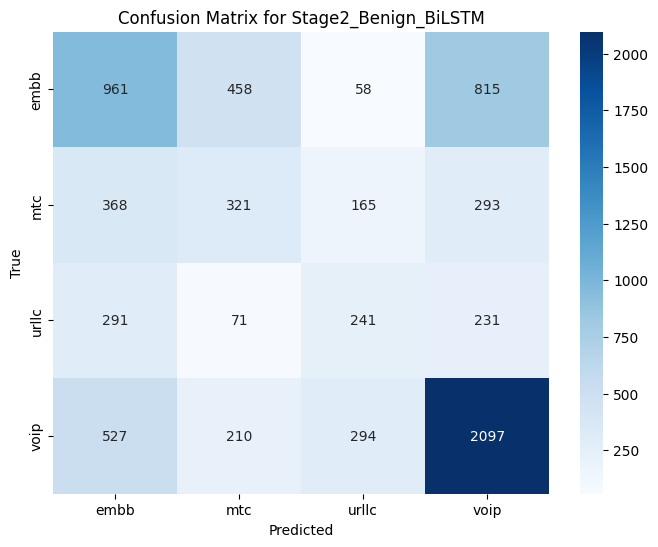

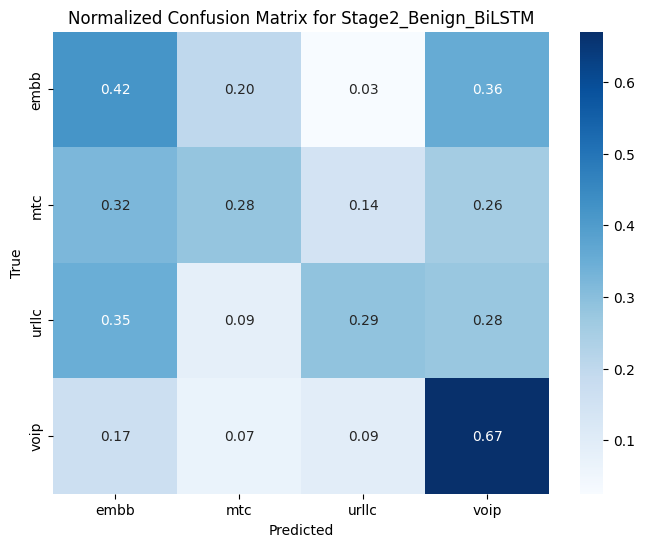

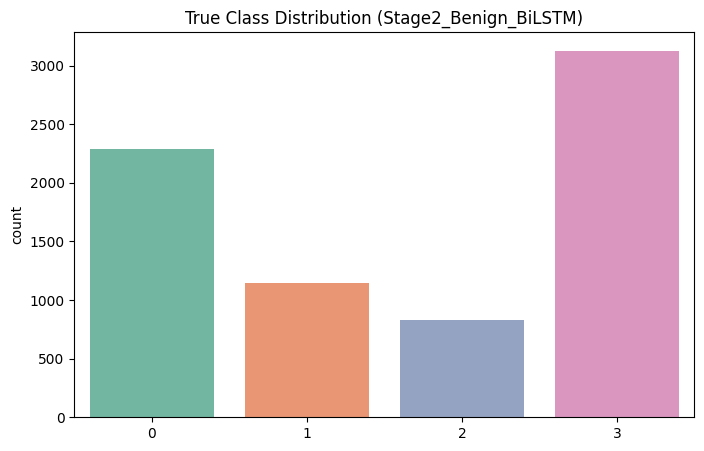

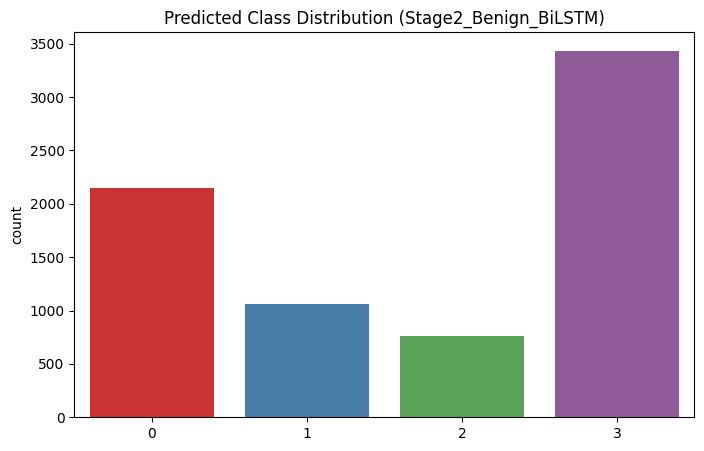

  Accuracy: 0.4891
  F1-Macro: 0.4164
  F1-Weighted: 0.4833

--- Evaluating CNN_GRU for Stage 2a Benign ---

--- Evaluating Stage2_Benign_CNN_GRU ---
              precision    recall  f1-score   support

        embb       0.45      0.48      0.46      2292
         mtc       0.30      0.33      0.32      1147
       urllc       0.32      0.30      0.31       834
        voip       0.68      0.63      0.65      3128

    accuracy                           0.50      7401
   macro avg       0.44      0.44      0.44      7401
weighted avg       0.51      0.50      0.50      7401



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1393: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.gru(


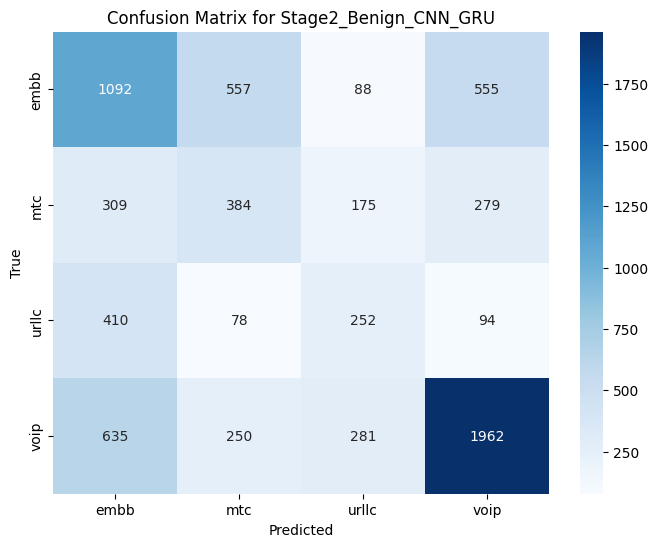

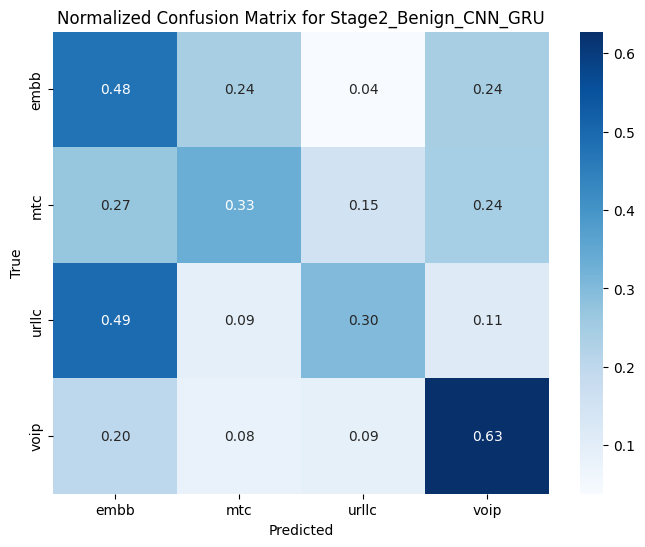

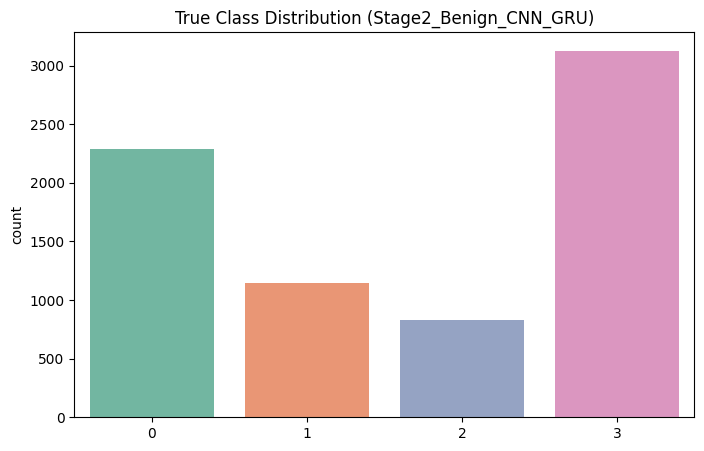

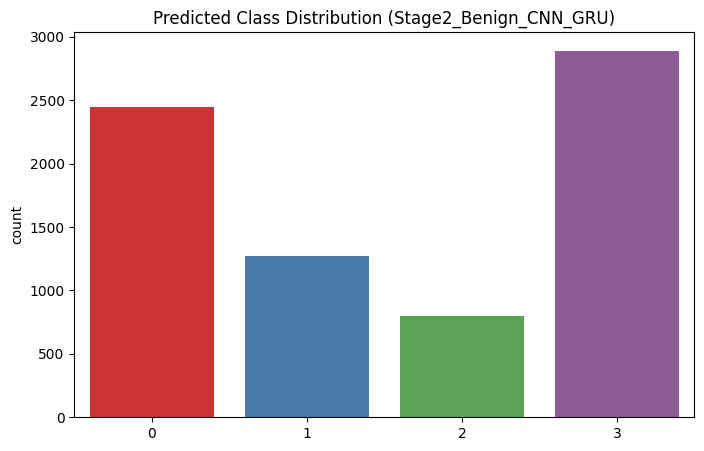

  Accuracy: 0.4986
  F1-Macro: 0.4350
  F1-Weighted: 0.5024

--- Evaluating AttentionLSTM for Stage 2a Benign ---

--- Evaluating Stage2_Benign_AttentionLSTM ---
              precision    recall  f1-score   support

        embb       0.49      0.47      0.48      2292
         mtc       0.30      0.30      0.30      1147
       urllc       0.28      0.38      0.32       834
        voip       0.70      0.64      0.67      3128

    accuracy                           0.51      7401
   macro avg       0.44      0.45      0.44      7401
weighted avg       0.52      0.51      0.51      7401



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.lstm(


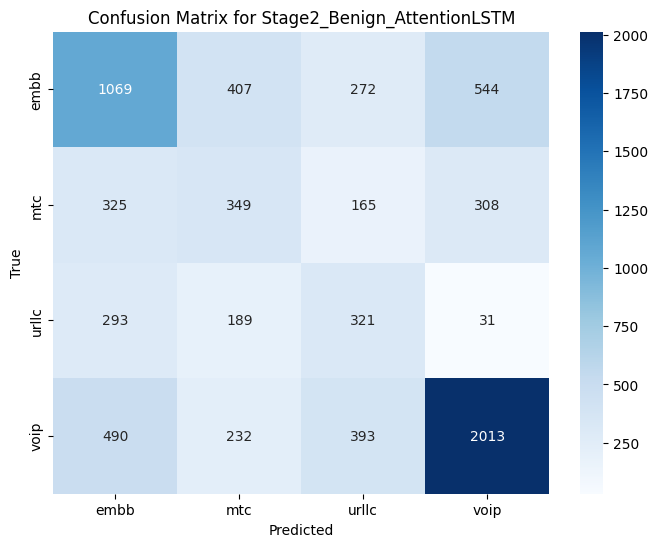

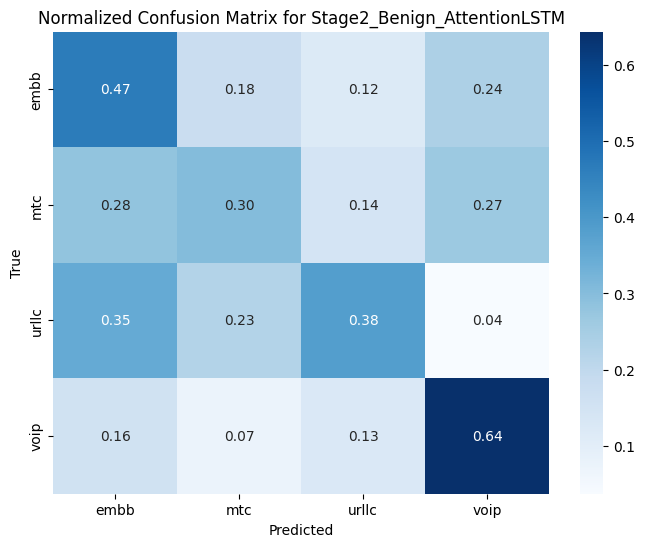

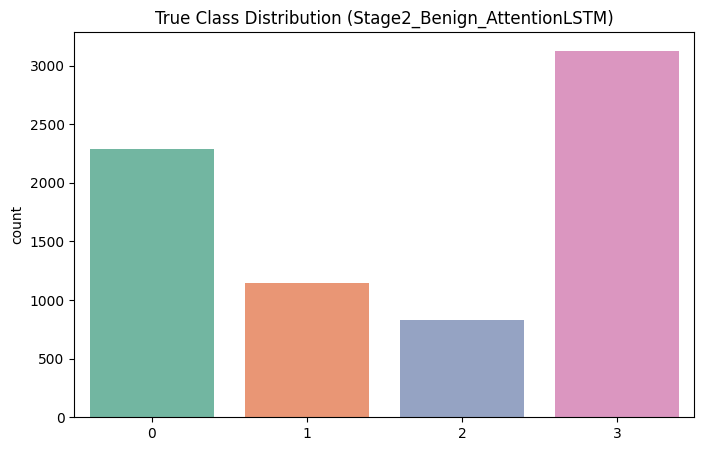

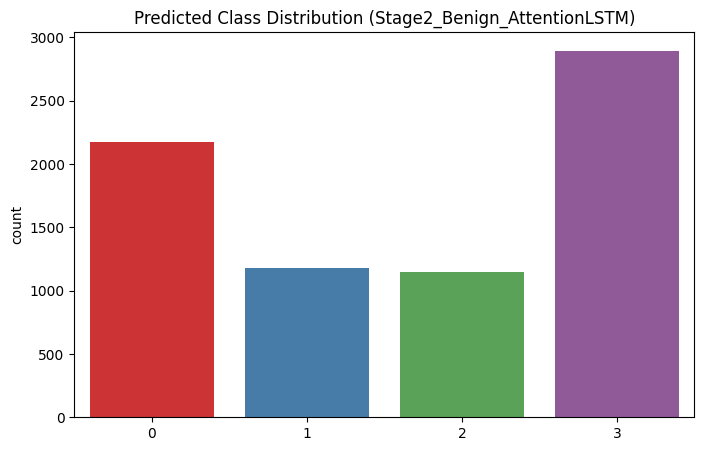

  Accuracy: 0.5070
  F1-Macro: 0.4426
  F1-Weighted: 0.5136

--- Evaluating AttentionGRU for Stage 2a Benign ---

--- Evaluating Stage2_Benign_AttentionGRU ---
              precision    recall  f1-score   support

        embb       0.45      0.43      0.44      2292
         mtc       0.32      0.39      0.35      1147
       urllc       0.27      0.36      0.31       834
        voip       0.70      0.61      0.65      3128

    accuracy                           0.49      7401
   macro avg       0.44      0.45      0.44      7401
weighted avg       0.52      0.49      0.50      7401



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1393: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.gru(


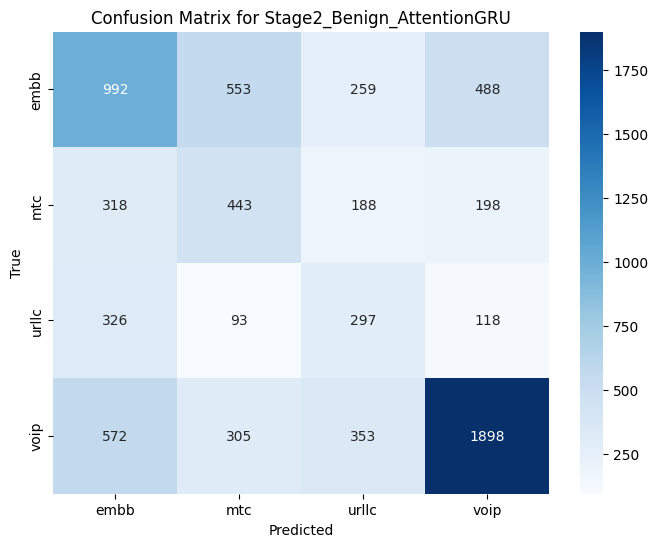

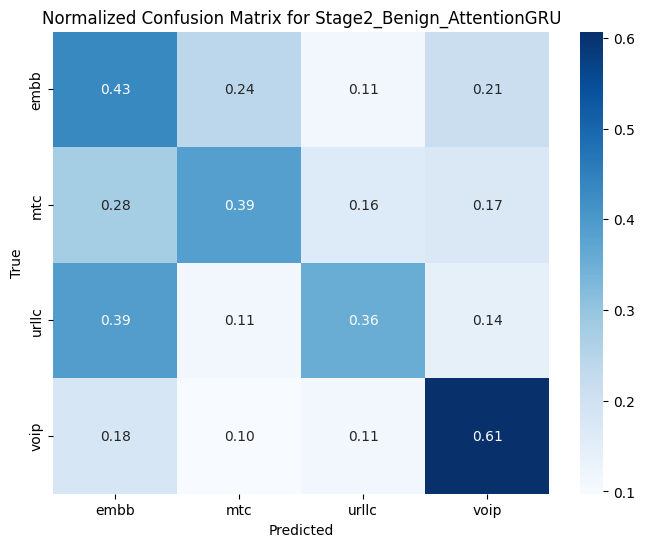

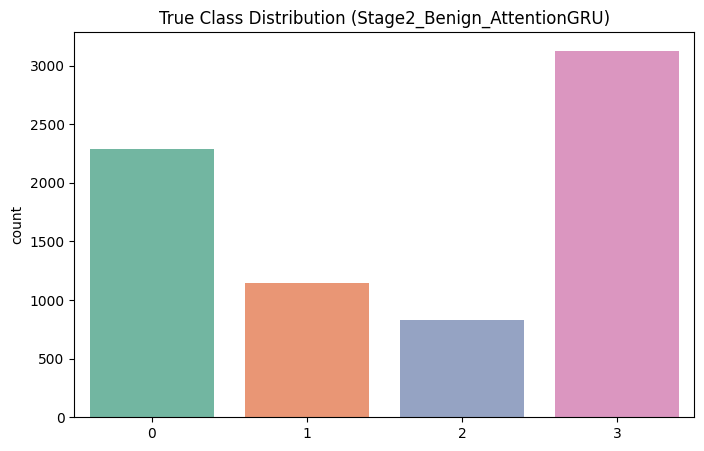

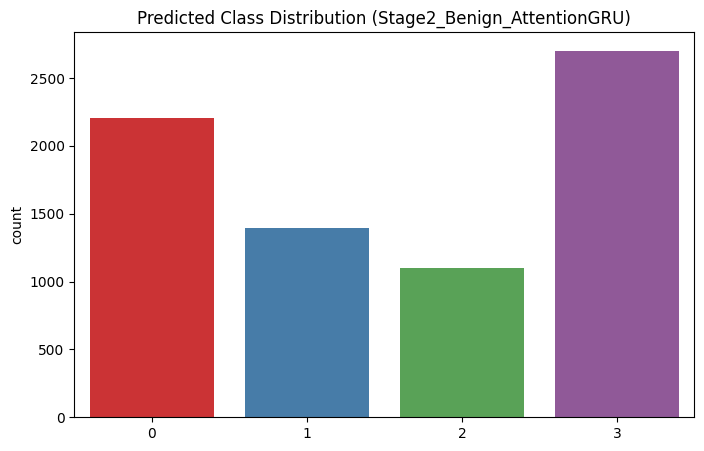

  Accuracy: 0.4905
  F1-Macro: 0.4371
  F1-Weighted: 0.5004

--- Evaluating Transformer for Stage 2a Benign ---

--- Evaluating Stage2_Benign_Transformer ---
              precision    recall  f1-score   support

        embb       0.46      0.37      0.41      2292
         mtc       0.35      0.44      0.39      1147
       urllc       0.31      0.18      0.23       834
        voip       0.67      0.77      0.71      3128

    accuracy                           0.53      7401
   macro avg       0.45      0.44      0.43      7401
weighted avg       0.51      0.53      0.51      7401



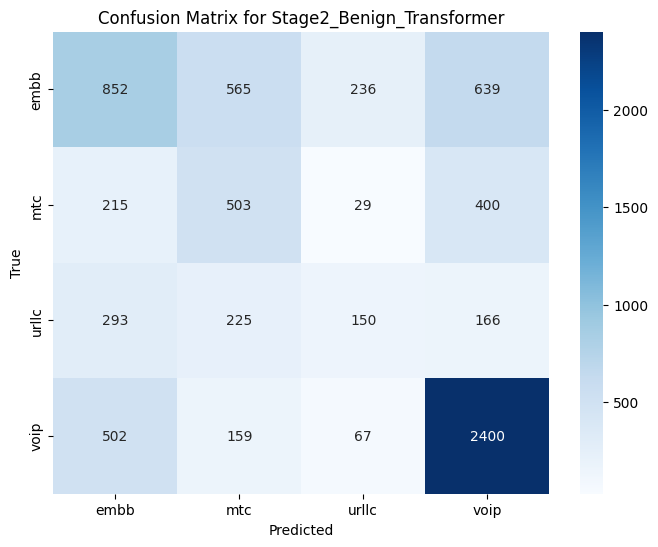

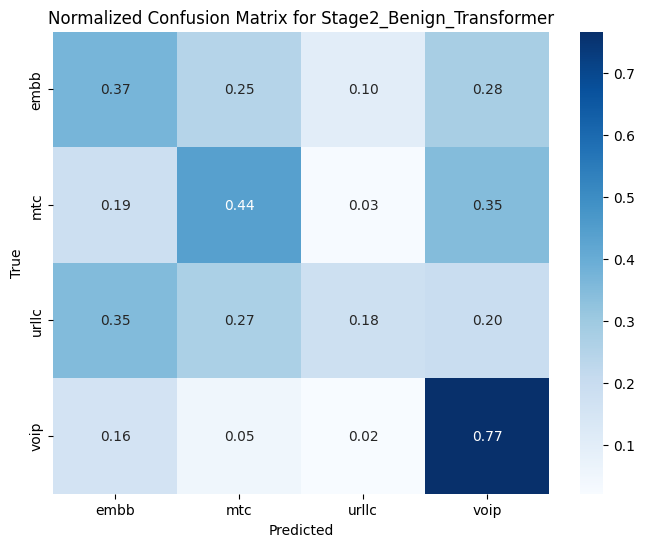

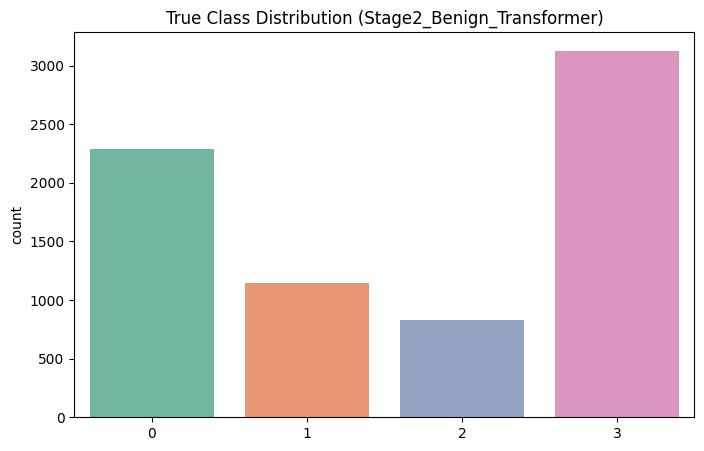

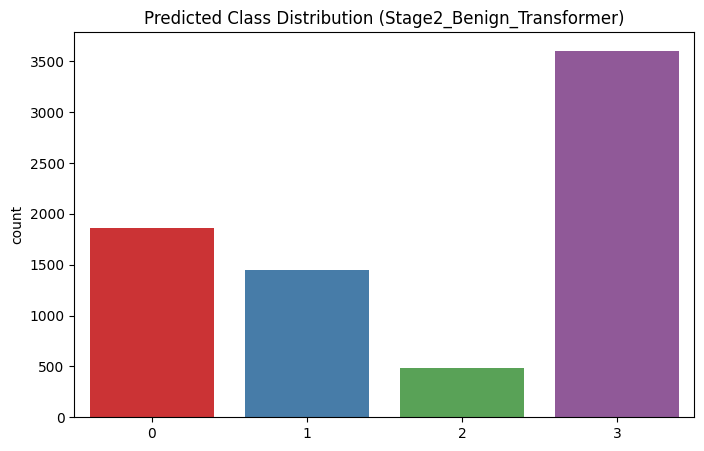

  Accuracy: 0.5276
  F1-Macro: 0.4345
  F1-Weighted: 0.5140

Best Stage 2a Benign model: AttentionLSTM with F1-macro=0.443


In [48]:
 # ------------------- STAGE 2a: MULTI-CLASS BENIGN -------------------
# Use the improved data preparation function
data_ben = prepare_stage2_data_sequences(
    df, selected_features, preprocessor, filter_val=0, seq_len=SEQ_LEN
)

# Load per-model results
results_benign = load_results_per_model(models_to_try,'stage2_benign') or {}
models_to_run = [m for m in models_to_try if m not in results_benign]

print("Stage 2a benign classes:", data_ben['label_encoder'].classes_)
print("Number of classes expected:", len(data_ben['label_encoder'].classes_))

for model_name in models_to_run:
    print(f"\n--- Stage 2a Benign: {model_name} ---")
    model, study = load_artifacts(model_name, "stage2_benign")

    # Get appropriate data format for each model type
    if model_name in ["MLP", "CNN1D", "LSTM", "CNN_LSTM", "GRU", "BiLSTM",
                      "CNN_GRU", "AttentionLSTM", "AttentionGRU", "Transformer"]:
        X_train_ben, X_test_ben, y_train_ben, y_test_ben = data_ben['sequences']
    else:
        X_train_ben, X_test_ben, y_train_ben, y_test_ben = data_ben['flat']
    
    le_benign = data_ben['label_encoder']

    if model is not None and study is not None:
        print(f"Loaded existing {model_name} for Stage 2a Benign.")
    else:
        try:
            pretrained_model = None
            if model_name in [
                "MLP", "CNN1D", "LSTM", "CNN_LSTM",
                "GRU", "BiLSTM", "CNN_GRU",
                "AttentionLSTM", "AttentionGRU", "Transformer"
            ]:
                pretrained_model = pretrain_pytorch_model(
                    model_name=model_name,
                    X=X_train_ben,
                    y=y_train_ben,
                    num_classes=len(le_benign.classes_),
                    seq_len=SEQ_LEN,  # Use SEQ_LEN constant
                    epochs=10
                )
            best_trial, study = run_tuning_and_train(
                model_name, X_train_ben, y_train_ben,
                n_trials=10, num_classes=len(le_benign.classes_), seq_len=SEQ_LEN, resume_stage='2a', pretrained_model=pretrained_model
            )

            if model_name not in [    "MLP",    "CNN1D",    "LSTM",    "CNN_LSTM",    "GRU",    "BiLSTM",    "CNN_GRU",    "AttentionLSTM",    "AttentionGRU",    "Transformer"]:
                if model_name == "XGBoost":
                    model = xgb.XGBClassifier(**best_trial.params, device=DEVICE,
                                              objective="multi:softprob", num_class=len(le_benign.classes_))
                elif model_name == "LightGBM":
                    model = lgb.LGBMClassifier(**best_trial.params)
                elif model_name == "RandomForest":
                    model = cuRF(**best_trial.params)
                elif model_name == "CatBoost":
                    model = CatBoostClassifier(**best_trial.params, verbose=0)
                elif model_name == "SVM":
                    model = SVC(**best_trial.params)
                elif model_name == "KNN":
                    model = KNeighborsClassifier(**best_trial.params)
                elif model_name == "LogisticRegression":
                    model = LogisticRegression(max_iter=500)

                model.fit(X_train_ben, y_train_ben)
            else:
                model = best_trial.user_attrs.get("trained_model")
                if model is None:
                    print(f"Warning: trained_model not found for {model_name}, skipping evaluation.")
                    continue

            save_artifacts(model, selected_features, study, model_name, "stage2_benign")
            print(f"Trained and saved {model_name} for Stage 2a Benign.")
        except Exception as e:
            print(f"Skipping {model_name} due to error: {e}")
            continue

    # Evaluate
    if model_name in [    "MLP",    "CNN1D",    "LSTM",    "CNN_LSTM",    "GRU",    "BiLSTM",    "CNN_GRU",    "AttentionLSTM",    "AttentionGRU",    "Transformer"]:
        model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X_test_ben, dtype=torch.float32).to(DEVICE)
            out = model(X_tensor)
            y_pred = out.argmax(dim=1).cpu().numpy()
    else:
        y_pred = model.predict(X_test_ben)

    metrics_dict = evaluate_classification(model, f"Stage2_Benign_{model_name}",
                                           X_test=X_test_ben, y_test=y_test_ben,
                                           target_names=le_benign.classes_,
                                           y_pred=y_pred)

    model_result = {
        "model": model,
        "optuna_study": study,
        "accuracy": accuracy_score(y_test_ben, y_pred),
        "f1_macro": metrics_dict['macro avg']['f1-score'],
        "f1_weighted": metrics_dict['weighted avg']['f1-score'],
        "classification_report": metrics_dict,
        "confusion_matrix": confusion_matrix(y_test_ben, y_pred)
    }

    save_results_per_model({model_name: model_result}, 'stage2_benign')
    results_benign[model_name] = model_result

# Evaluate ALL models for Stage 2a Benign using evaluate_model_predictions
print(f"\n--- Running evaluate_model_predictions for ALL Stage 2a Benign models ---")
for model_name in models_to_try:
    print(f"\n--- Evaluating {model_name} for Stage 2a Benign ---")
    
    try:
        # Load the model (either from results_benign or from artifacts)
        if model_name in results_benign:
            model = results_benign[model_name]['model']
        else:
            # Try to load from artifacts
            artifacts = load_artifacts(model_name, "stage2_benign")
            if artifacts is None:
                print(f"No model found for {model_name}, skipping.")
                continue
            model, _ = artifacts
            if isinstance(model, tuple):
                model = model[0]
        
        # Get appropriate data format for each model type
        if model_name in ["MLP", "CNN1D", "LSTM", "CNN_LSTM", "GRU", "BiLSTM",
                          "CNN_GRU", "AttentionLSTM", "AttentionGRU", "Transformer"]:
            X_test_ben = data_ben['sequences'][1]  # X_test_seq
            y_test_ben = data_ben['sequences'][3]  # y_test_seq
        else:
            X_test_ben = data_ben['flat'][1]  # X_test_flat
            y_test_ben = data_ben['flat'][3]  # y_test_flat
        # le_malicious = data_mal['label_encoder']
        le_benign = data_ben['label_encoder']
        
        # Run evaluate_model_predictions
        y_pred = evaluate_model_predictions(model, model_name, X_test_ben, y_test_ben)
        evaluate_classification(model, f"Stage2_Benign_{model_name}",
                                           X_test=X_test_ben, y_test=y_test_ben,
                                           target_names=le_benign.classes_,
                                           y_pred=y_pred)
        # Print basic metrics
        accuracy = accuracy_score(y_test_ben, y_pred)
        f1_macro = f1_score(y_test_ben, y_pred, average='macro')
        f1_weighted = f1_score(y_test_ben, y_pred, average='weighted')
        
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  F1-Macro: {f1_macro:.4f}")
        print(f"  F1-Weighted: {f1_weighted:.4f}")
        
    except Exception as e:
        print(f"Error evaluating {model_name}: {type(e).__name__}: {str(e)}")
        continue

best_model_benign = max(results_benign, key=lambda k: results_benign[k]['f1_macro'])
print(f"\nBest Stage 2a Benign model: {best_model_benign} with F1-macro={results_benign[best_model_benign]['f1_macro']:.3f}")






--- Running evaluate_model_predictions for ALL Stage 2b Malicious models ---

--- Evaluating MLP for Stage 2b Malicious ---

--- Evaluating Stage2_Malicious_MLP ---
                                   precision    recall  f1-score   support

     malicious/parallel_tcp_flood       0.51      0.39      0.44      1982
     malicious/parallel_udp_flood       0.23      0.28      0.25       625
      malicious/pulsing_udp_flood       0.15      0.22      0.18       313
     malicious/small_packet_flood       0.38      0.33      0.36       314
              malicious/udp_flood       0.00      0.01      0.01       209
malicious/udp_fragmentation_flood       0.55      0.49      0.51      1774

                         accuracy                           0.38      5217
                        macro avg       0.30      0.29      0.29      5217
                     weighted avg       0.44      0.38      0.41      5217



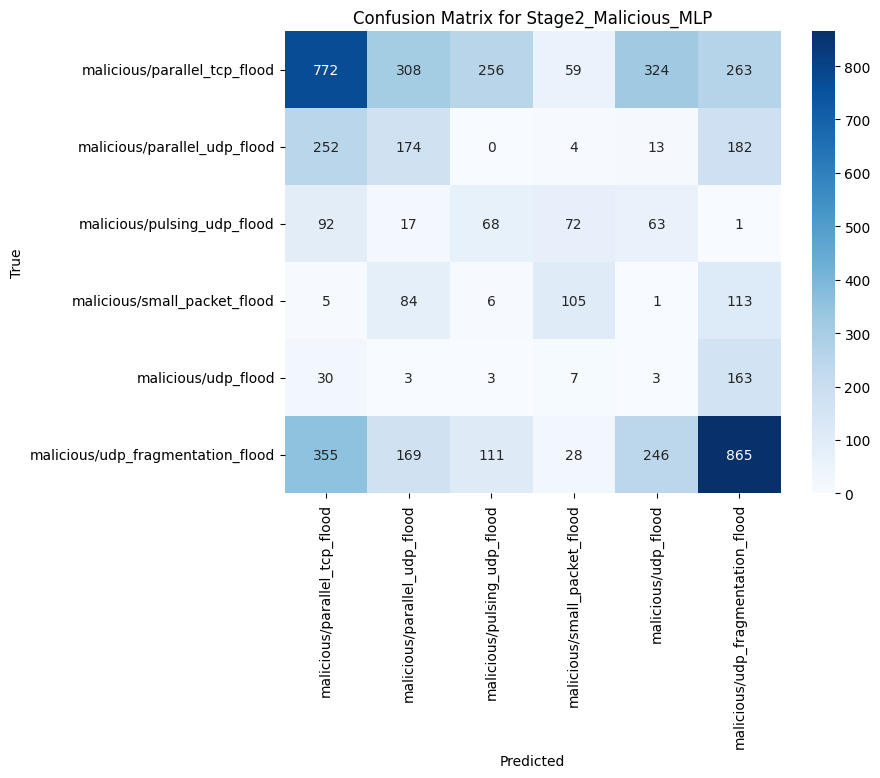

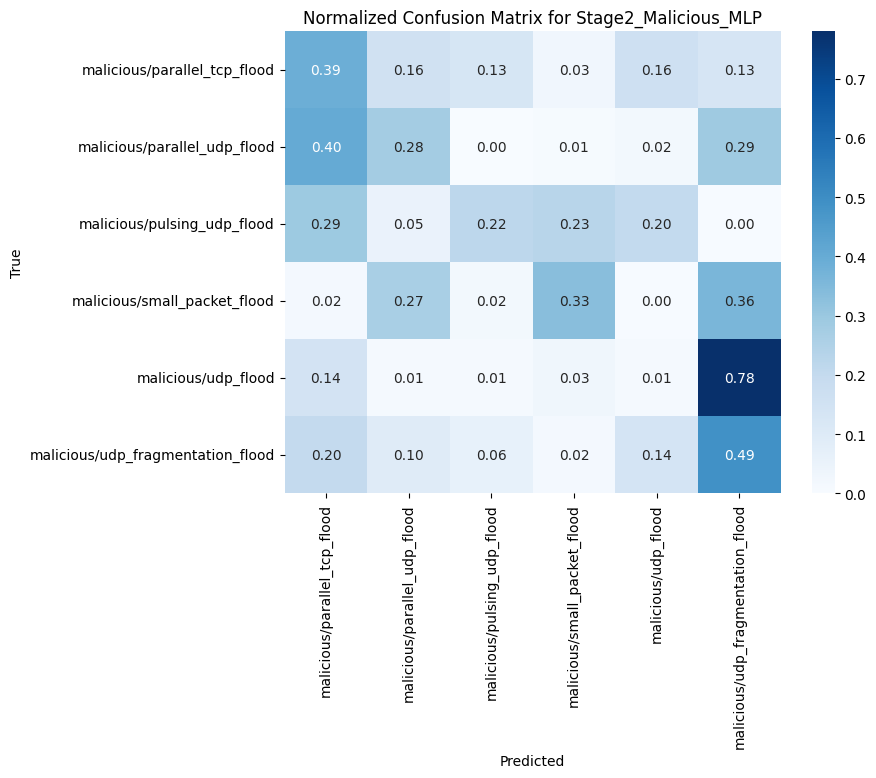

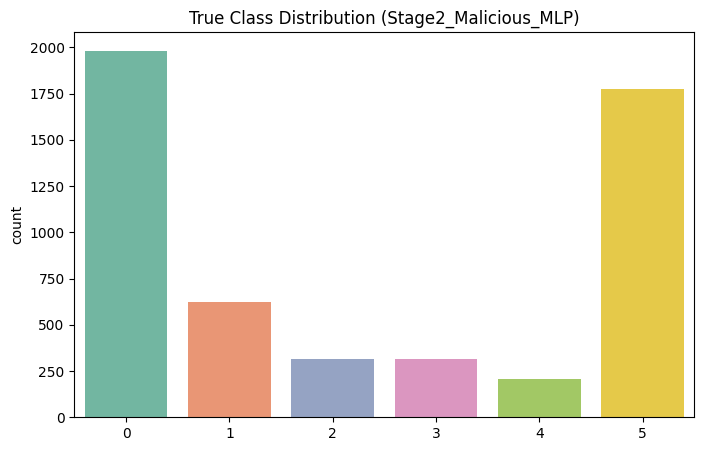

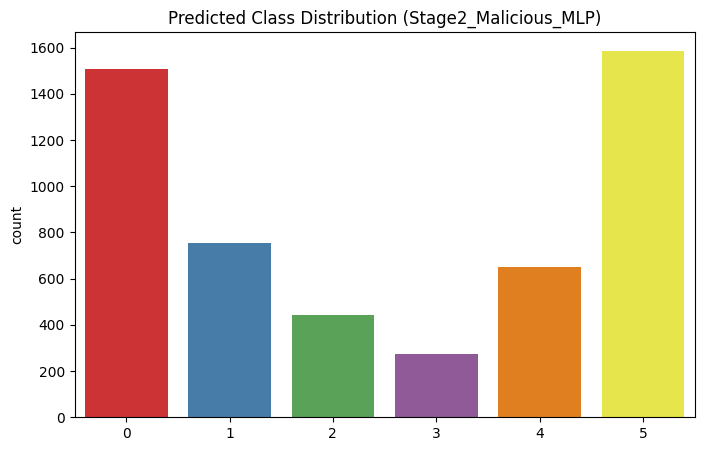

  Accuracy: 0.3809
  F1-Macro: 0.2921
  F1-Weighted: 0.4059

--- Evaluating CNN1D for Stage 2b Malicious ---

--- Evaluating Stage2_Malicious_CNN1D ---
                                   precision    recall  f1-score   support

     malicious/parallel_tcp_flood       0.52      0.56      0.54      1982
     malicious/parallel_udp_flood       0.04      0.02      0.03       625
      malicious/pulsing_udp_flood       0.00      0.00      0.00       313
     malicious/small_packet_flood       0.64      0.33      0.44       314
              malicious/udp_flood       0.00      0.00      0.00       209
malicious/udp_fragmentation_flood       0.55      0.58      0.57      1774

                         accuracy                           0.43      5217
                        macro avg       0.29      0.25      0.26      5217
                     weighted avg       0.43      0.43      0.43      5217



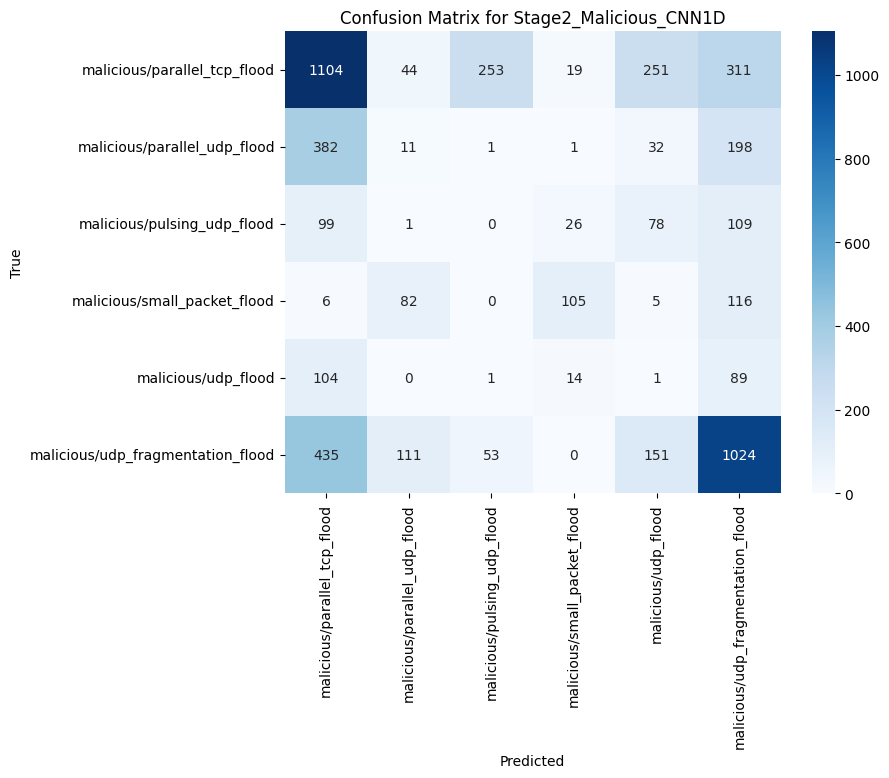

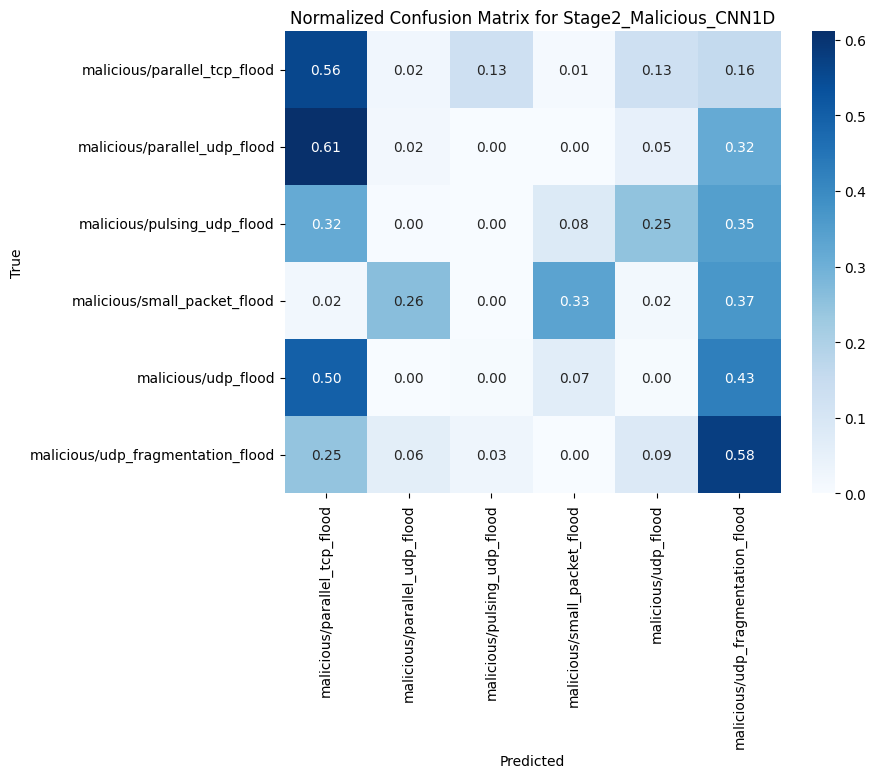

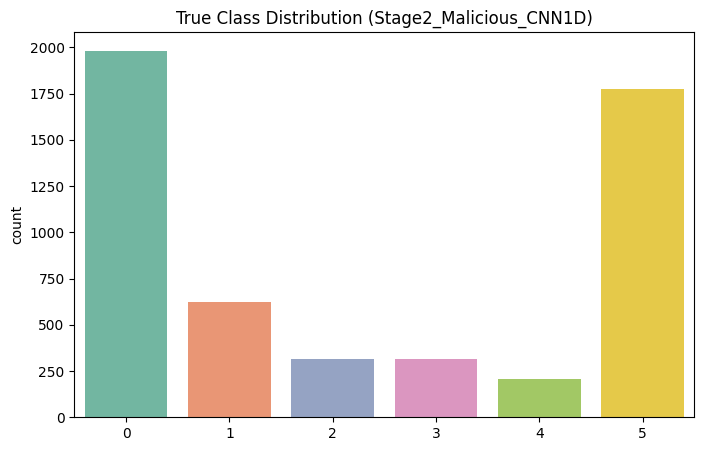

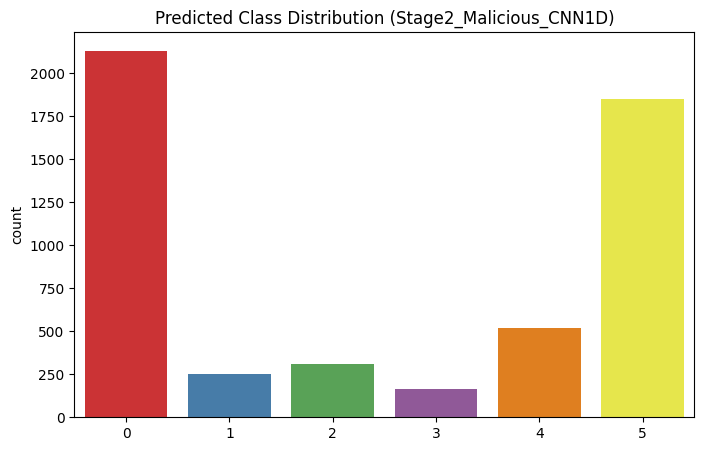

  Accuracy: 0.4303
  F1-Macro: 0.2615
  F1-Weighted: 0.4258

--- Evaluating LSTM for Stage 2b Malicious ---

--- Evaluating Stage2_Malicious_LSTM ---
                                   precision    recall  f1-score   support

     malicious/parallel_tcp_flood       0.56      0.44      0.49      1982
     malicious/parallel_udp_flood       0.08      0.05      0.06       625
      malicious/pulsing_udp_flood       0.22      0.41      0.28       313
     malicious/small_packet_flood       0.38      0.31      0.34       314
              malicious/udp_flood       0.00      0.00      0.00       209
malicious/udp_fragmentation_flood       0.45      0.45      0.45      1774

                         accuracy                           0.37      5217
                        macro avg       0.28      0.28      0.27      5217
                     weighted avg       0.41      0.37      0.38      5217



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.lstm(


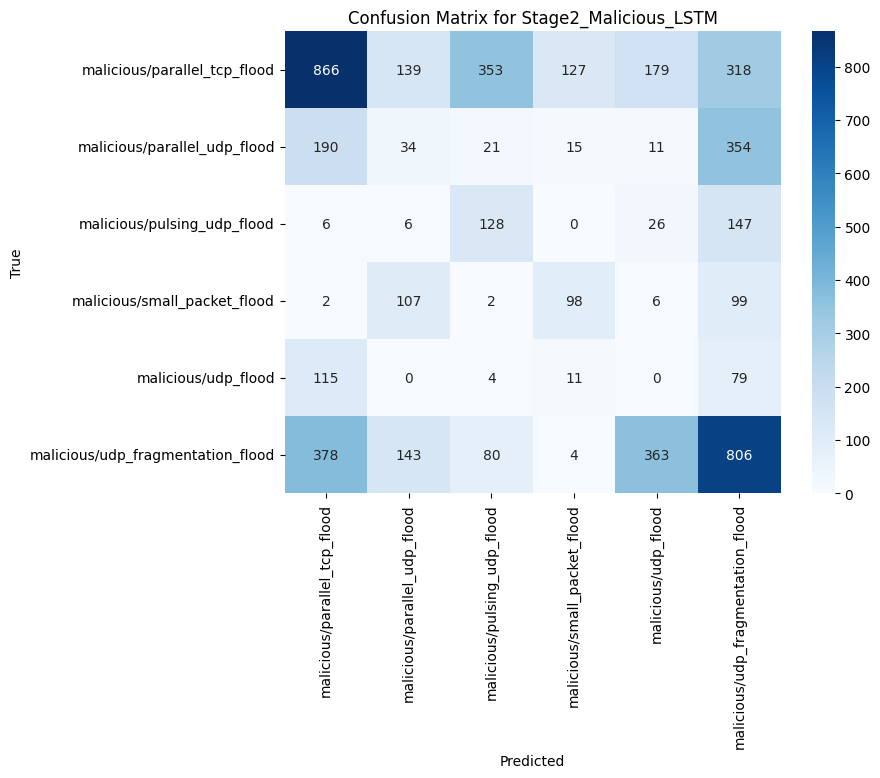

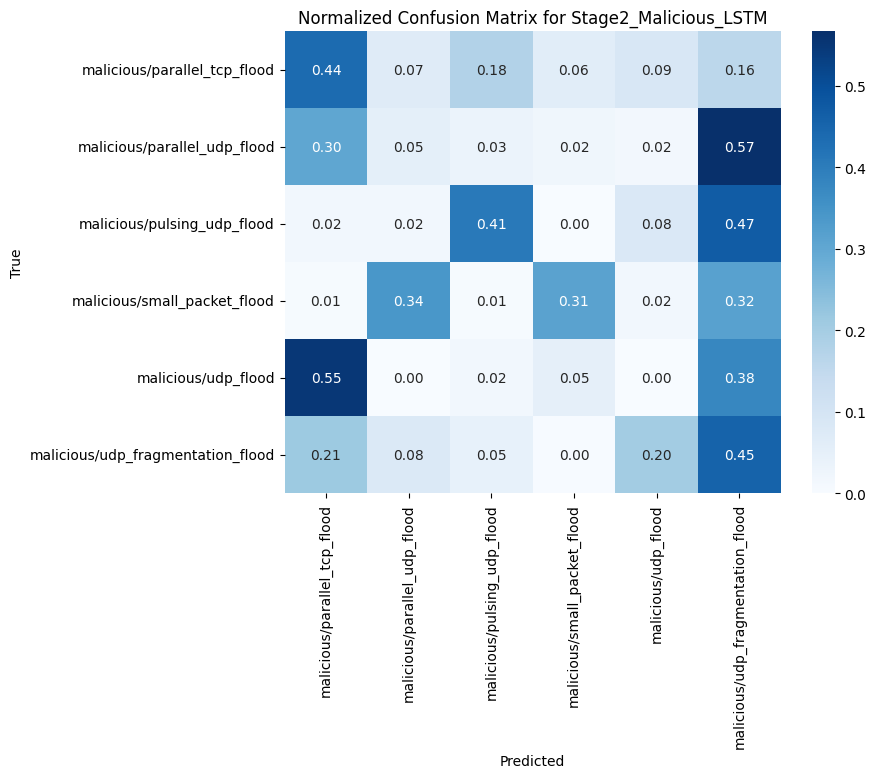

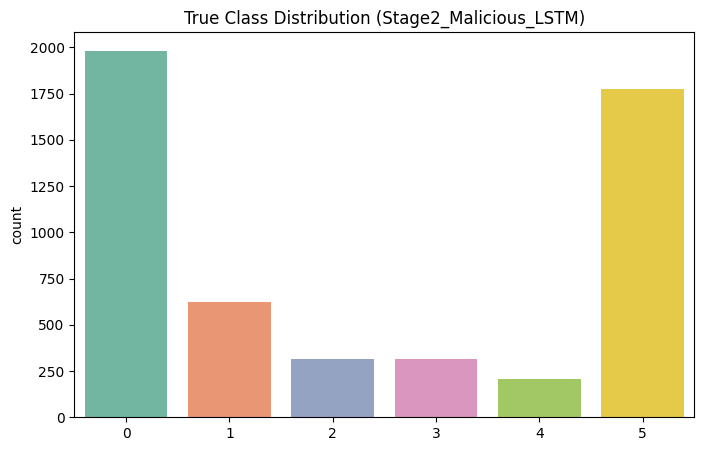

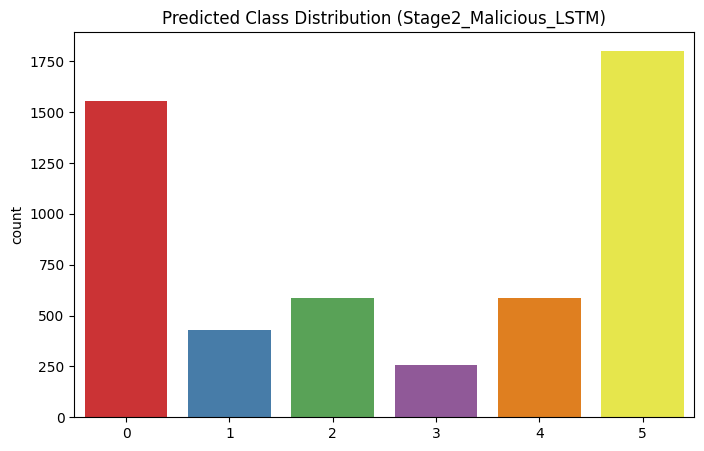

  Accuracy: 0.3703
  F1-Macro: 0.2722
  F1-Weighted: 0.3847

--- Evaluating CNN_LSTM for Stage 2b Malicious ---

--- Evaluating Stage2_Malicious_CNN_LSTM ---
                                   precision    recall  f1-score   support

     malicious/parallel_tcp_flood       0.48      0.34      0.40      1982
     malicious/parallel_udp_flood       0.18      0.23      0.20       625
      malicious/pulsing_udp_flood       0.27      0.59      0.37       313
     malicious/small_packet_flood       0.43      0.32      0.37       314
              malicious/udp_flood       0.02      0.03      0.02       209
malicious/udp_fragmentation_flood       0.49      0.46      0.47      1774

                         accuracy                           0.37      5217
                        macro avg       0.31      0.33      0.31      5217
                     weighted avg       0.41      0.37      0.38      5217



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.lstm(


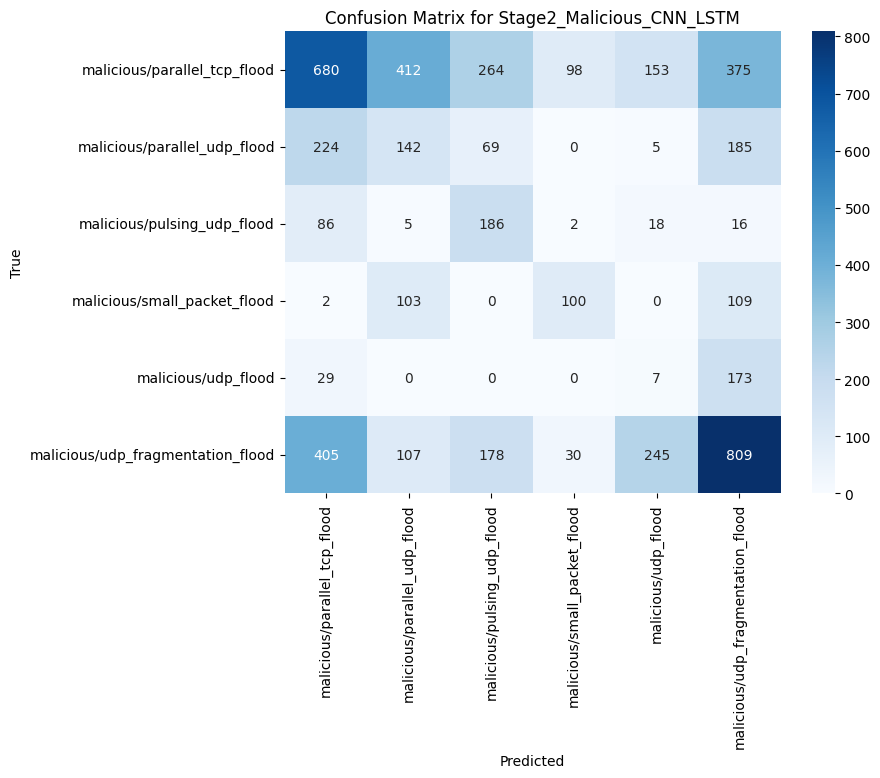

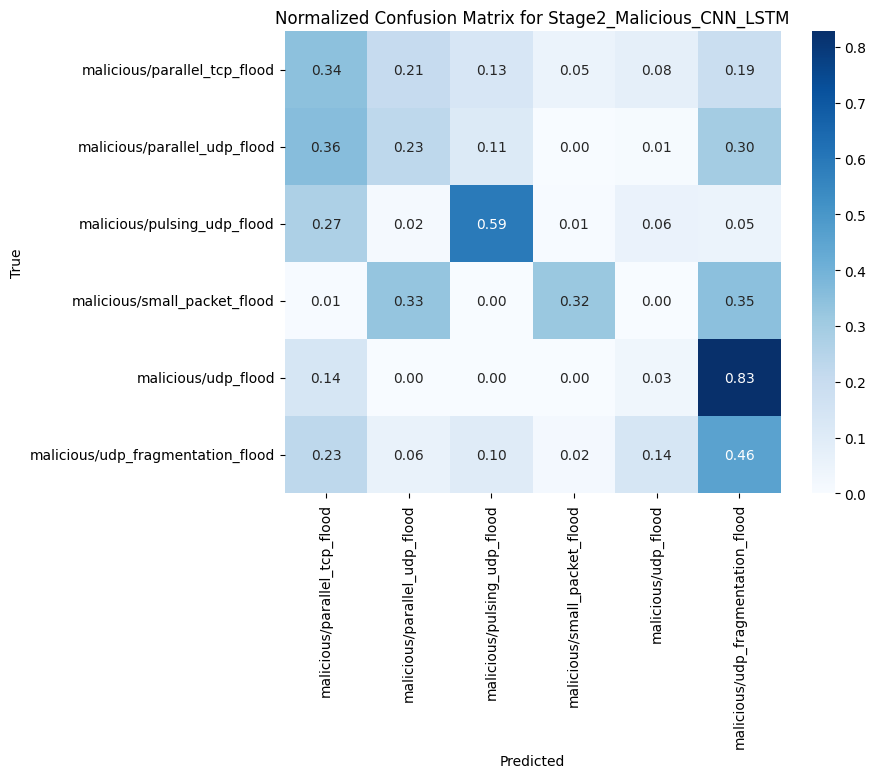

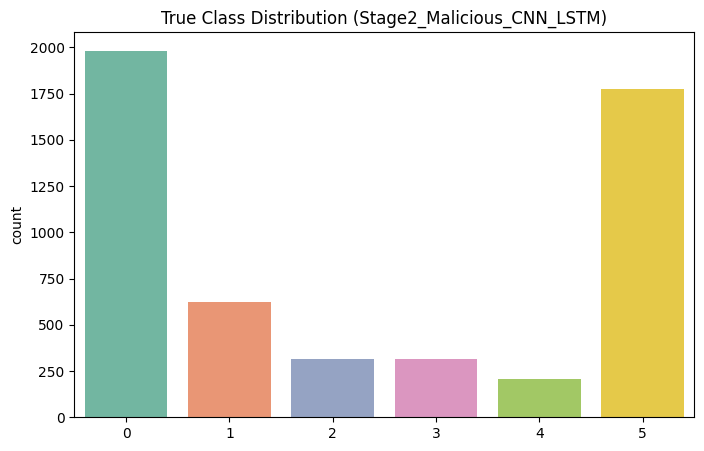

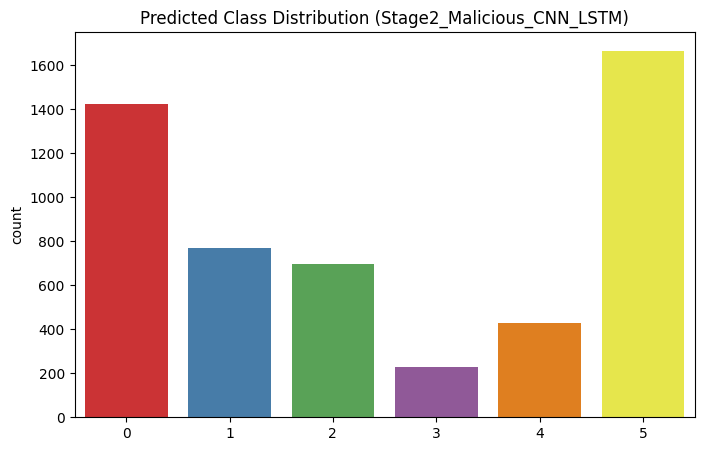

  Accuracy: 0.3688
  F1-Macro: 0.3052
  F1-Weighted: 0.3810

--- Evaluating GRU for Stage 2b Malicious ---

--- Evaluating Stage2_Malicious_GRU ---
                                   precision    recall  f1-score   support

     malicious/parallel_tcp_flood       0.65      0.50      0.57      1982
     malicious/parallel_udp_flood       0.18      0.13      0.15       625
      malicious/pulsing_udp_flood       0.17      0.35      0.23       313
     malicious/small_packet_flood       0.28      0.33      0.31       314
              malicious/udp_flood       0.00      0.00      0.00       209
malicious/udp_fragmentation_flood       0.55      0.50      0.52      1774

                         accuracy                           0.42      5217
                        macro avg       0.30      0.30      0.30      5217
                     weighted avg       0.48      0.42      0.44      5217



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1393: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.gru(


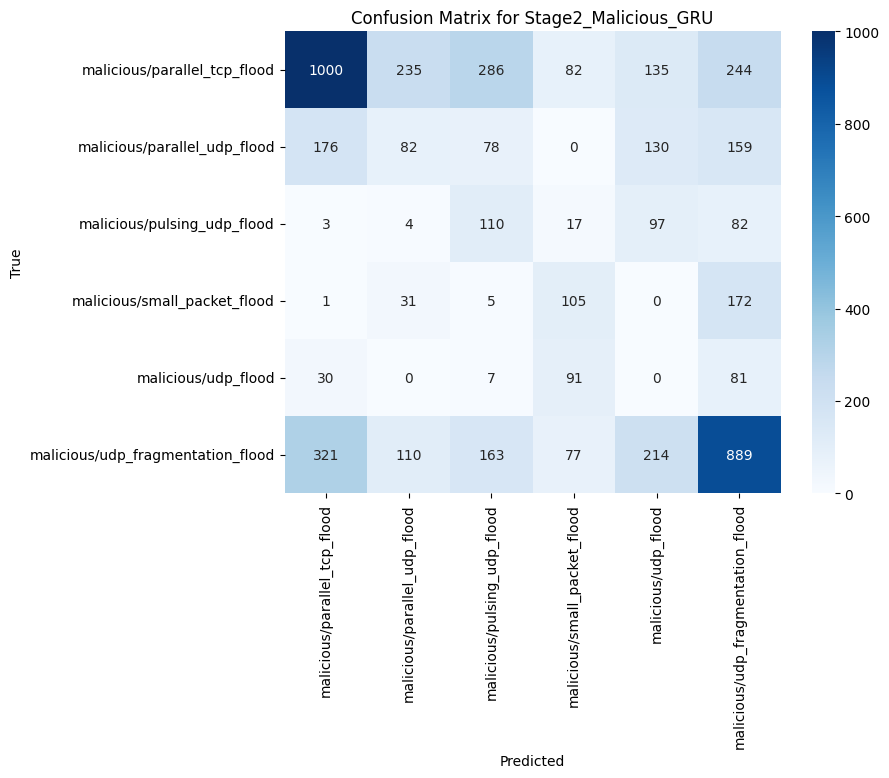

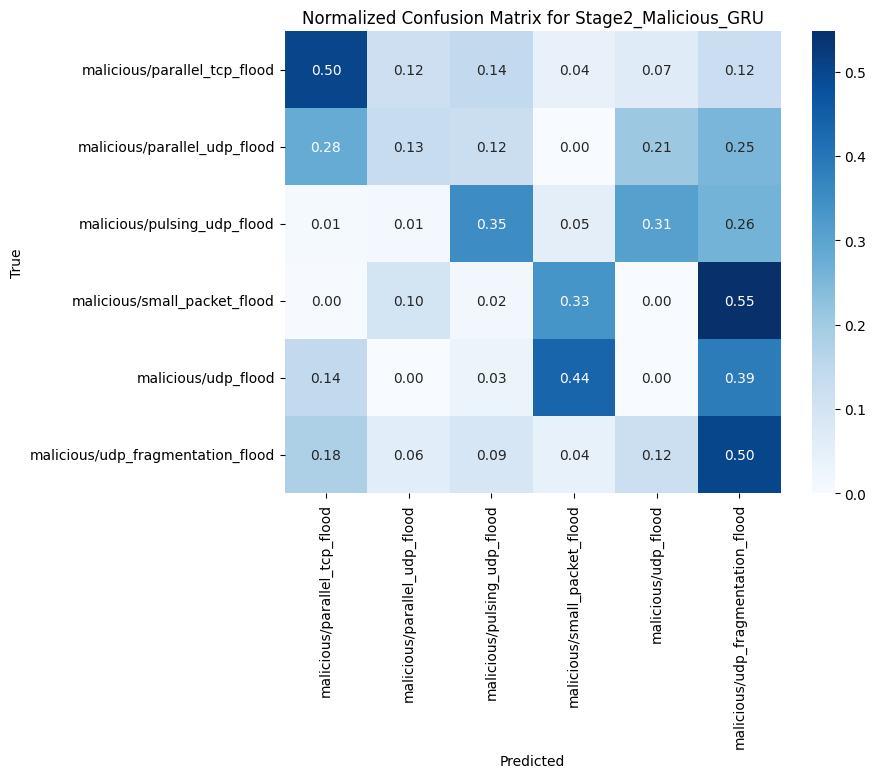

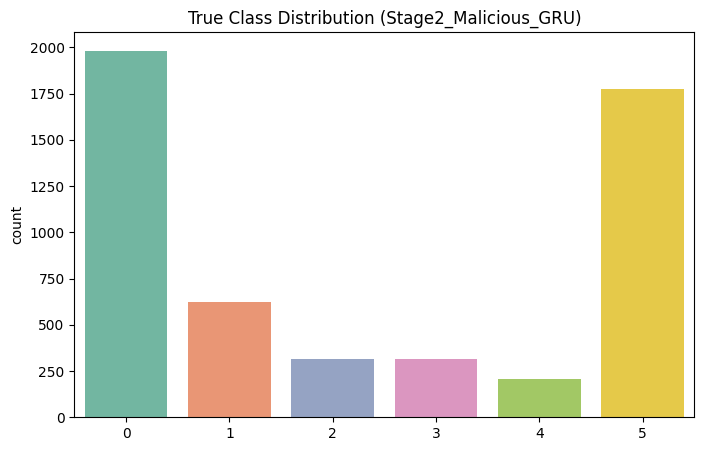

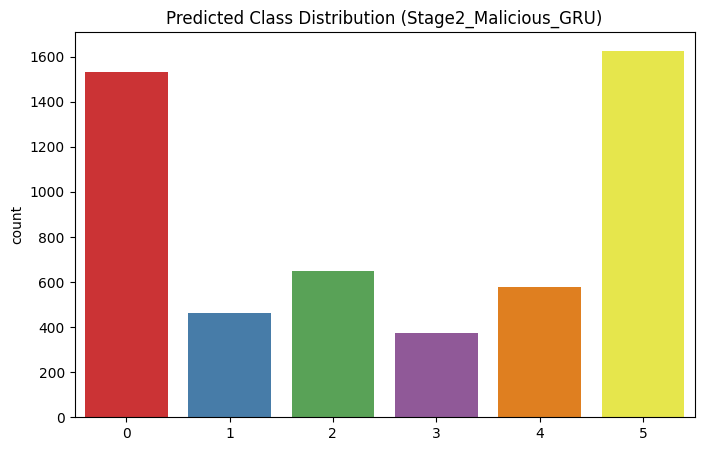

  Accuracy: 0.4190
  F1-Macro: 0.2963
  F1-Weighted: 0.4443

--- Evaluating BiLSTM for Stage 2b Malicious ---

--- Evaluating Stage2_Malicious_BiLSTM ---
                                   precision    recall  f1-score   support

     malicious/parallel_tcp_flood       0.53      0.36      0.43      1982
     malicious/parallel_udp_flood       0.19      0.24      0.21       625
      malicious/pulsing_udp_flood       0.12      0.14      0.13       313
     malicious/small_packet_flood       0.19      0.33      0.24       314
              malicious/udp_flood       0.00      0.00      0.00       209
malicious/udp_fragmentation_flood       0.43      0.43      0.43      1774

                         accuracy                           0.34      5217
                        macro avg       0.24      0.25      0.24      5217
                     weighted avg       0.39      0.34      0.36      5217



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.lstm(


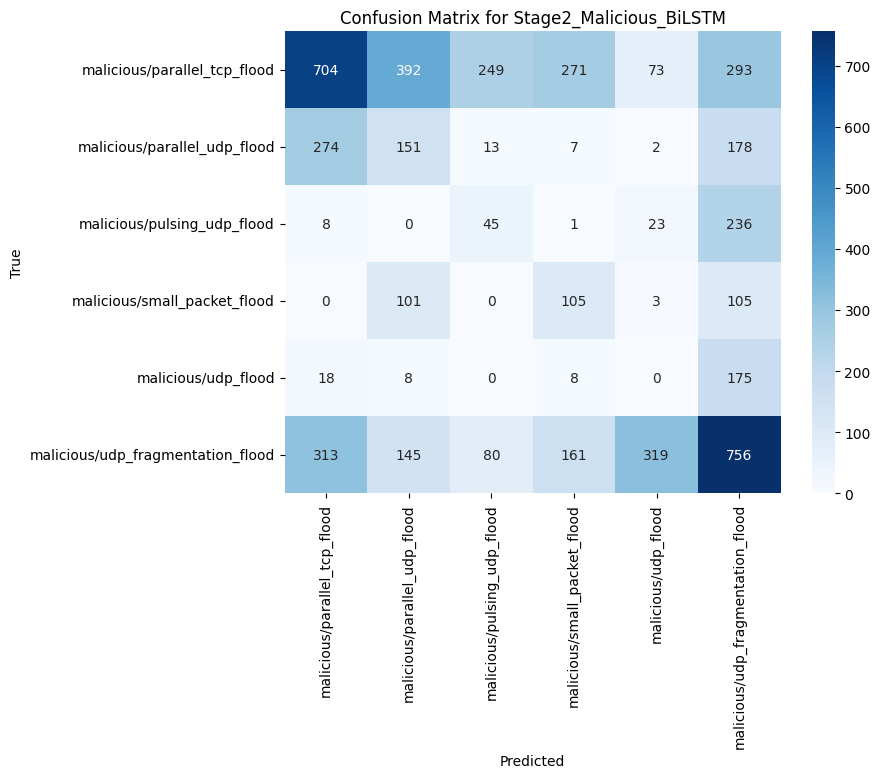

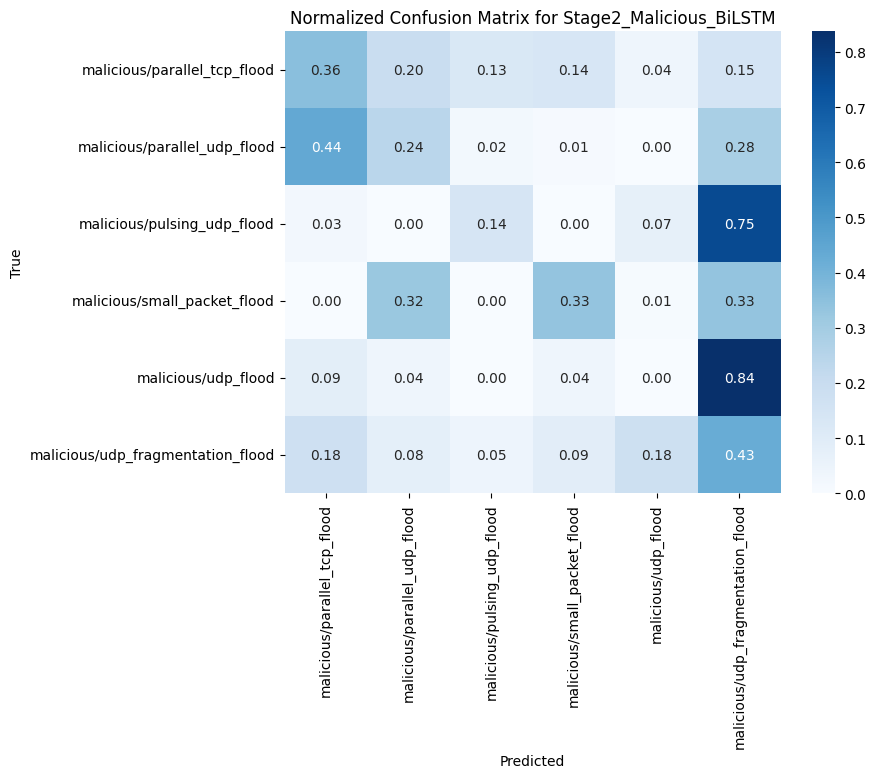

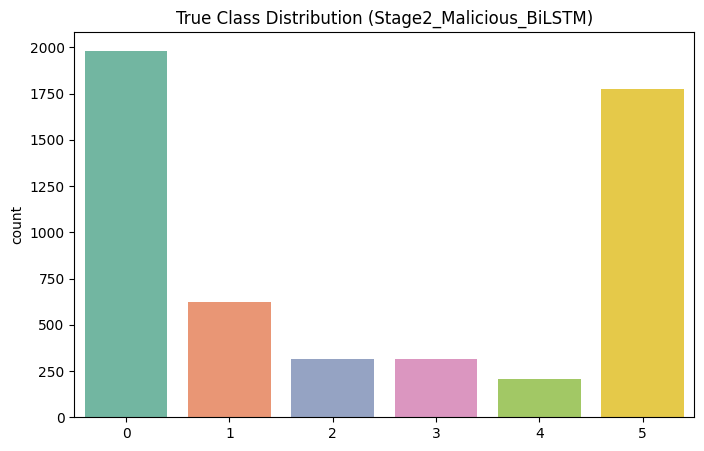

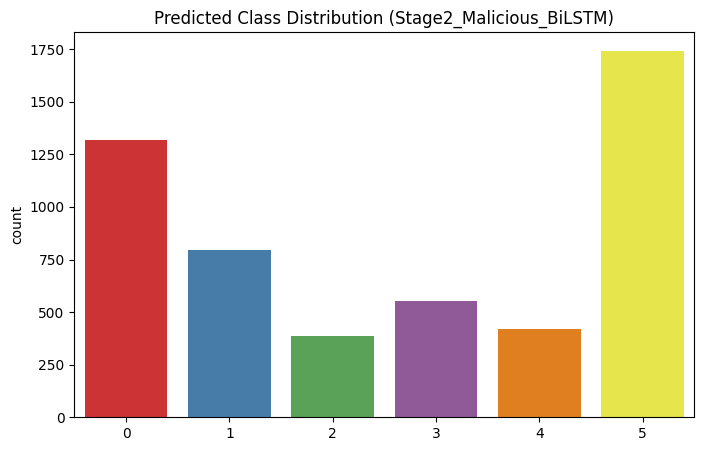

  Accuracy: 0.3376
  F1-Macro: 0.2400
  F1-Weighted: 0.3561

--- Evaluating CNN_GRU for Stage 2b Malicious ---

--- Evaluating Stage2_Malicious_CNN_GRU ---
                                   precision    recall  f1-score   support

     malicious/parallel_tcp_flood       0.52      0.34      0.41      1982
     malicious/parallel_udp_flood       0.14      0.21      0.17       625
      malicious/pulsing_udp_flood       0.33      0.65      0.44       313
     malicious/small_packet_flood       0.27      0.31      0.29       314
              malicious/udp_flood       0.00      0.01      0.01       209
malicious/udp_fragmentation_flood       0.53      0.43      0.47      1774

                         accuracy                           0.36      5217
                        macro avg       0.30      0.33      0.30      5217
                     weighted avg       0.43      0.36      0.38      5217



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1393: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.gru(


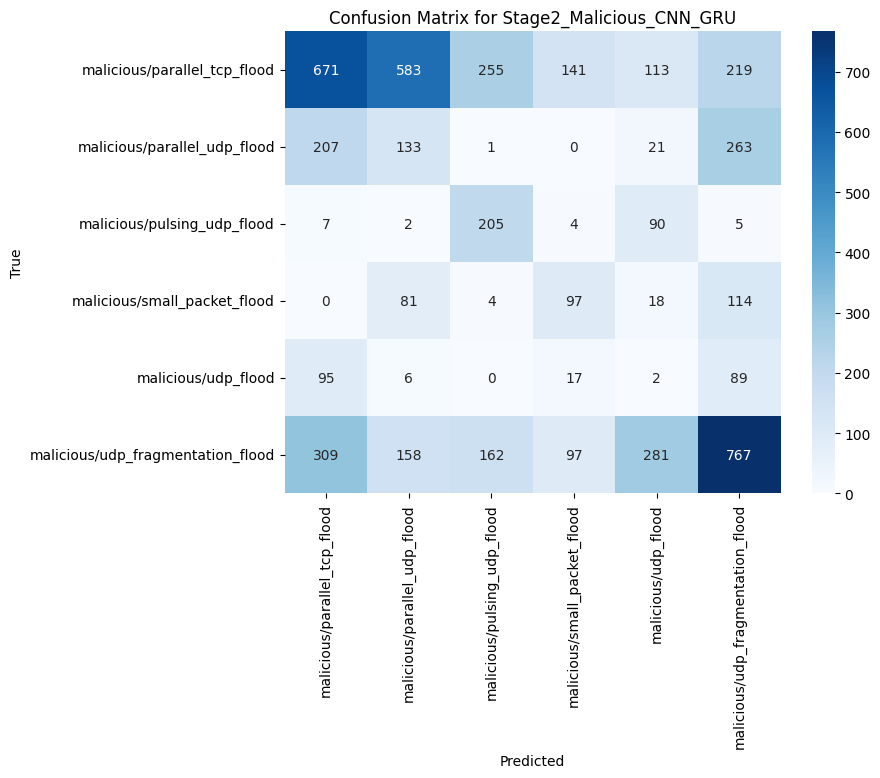

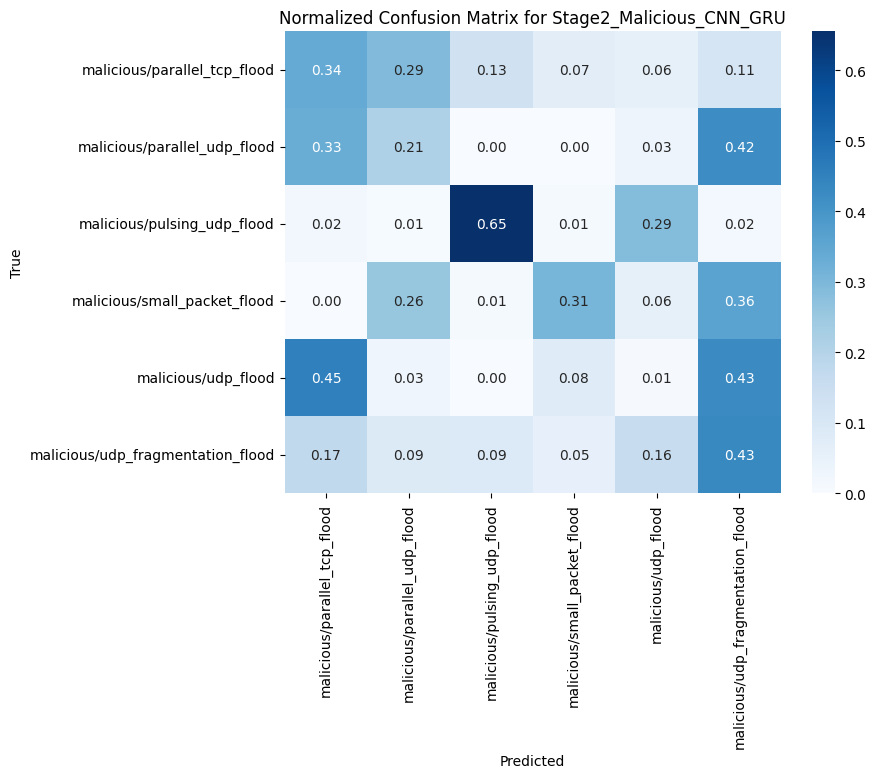

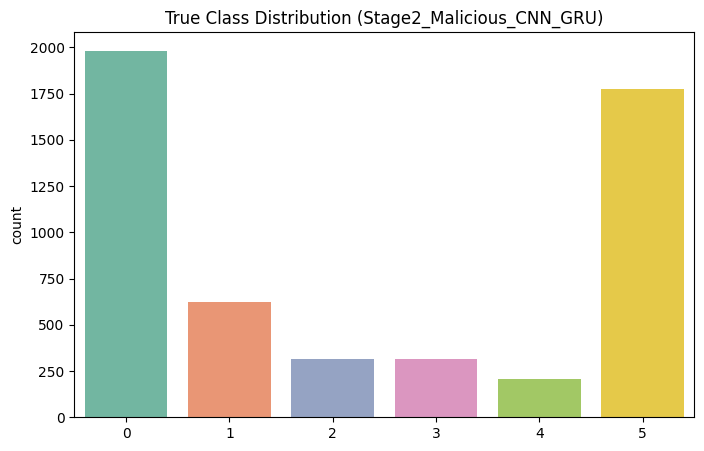

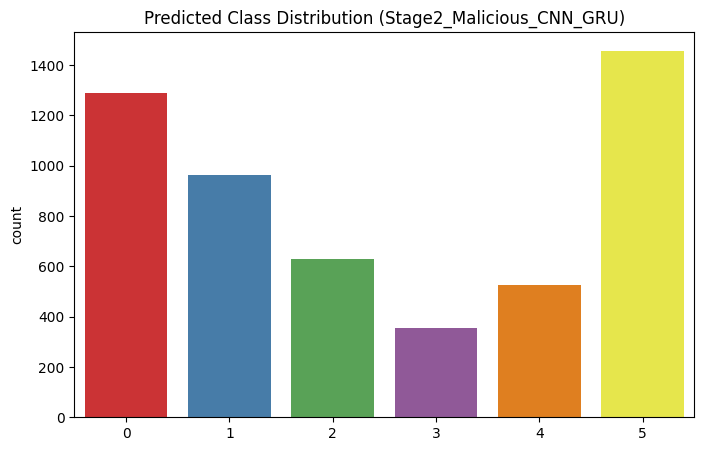

  Accuracy: 0.3594
  F1-Macro: 0.2973
  F1-Weighted: 0.3812

--- Evaluating AttentionLSTM for Stage 2b Malicious ---

--- Evaluating Stage2_Malicious_AttentionLSTM ---
                                   precision    recall  f1-score   support

     malicious/parallel_tcp_flood       0.55      0.35      0.43      1982
     malicious/parallel_udp_flood       0.15      0.22      0.18       625
      malicious/pulsing_udp_flood       0.13      0.27      0.17       313
     malicious/small_packet_flood       0.17      0.30      0.22       314
              malicious/udp_flood       0.00      0.00      0.00       209
malicious/udp_fragmentation_flood       0.57      0.41      0.48      1774

                         accuracy                           0.33      5217
                        macro avg       0.26      0.26      0.25      5217
                     weighted avg       0.44      0.33      0.37      5217



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.lstm(


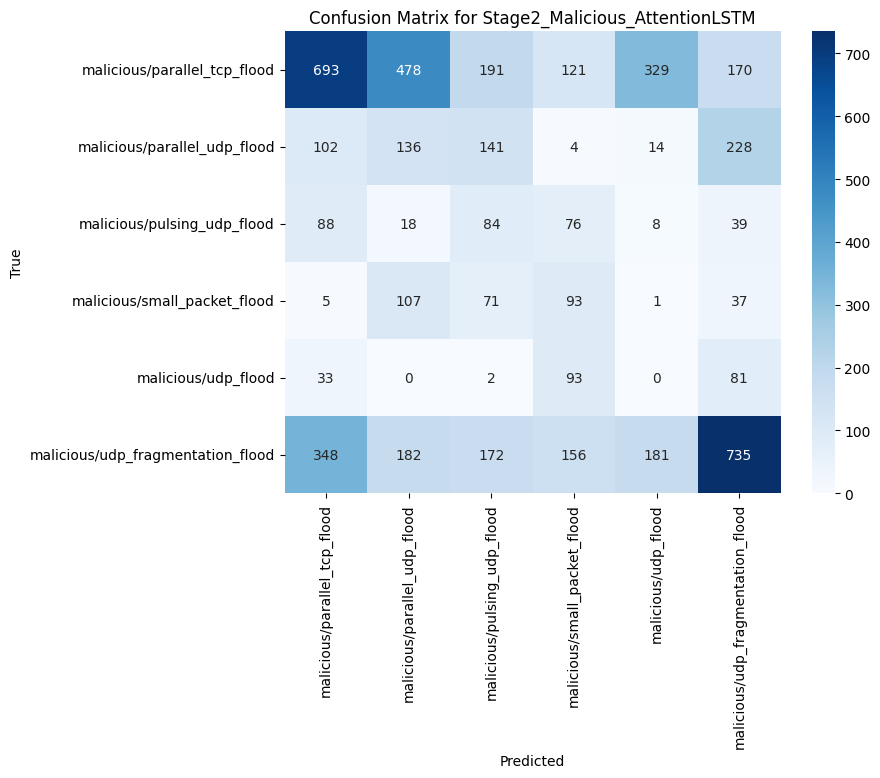

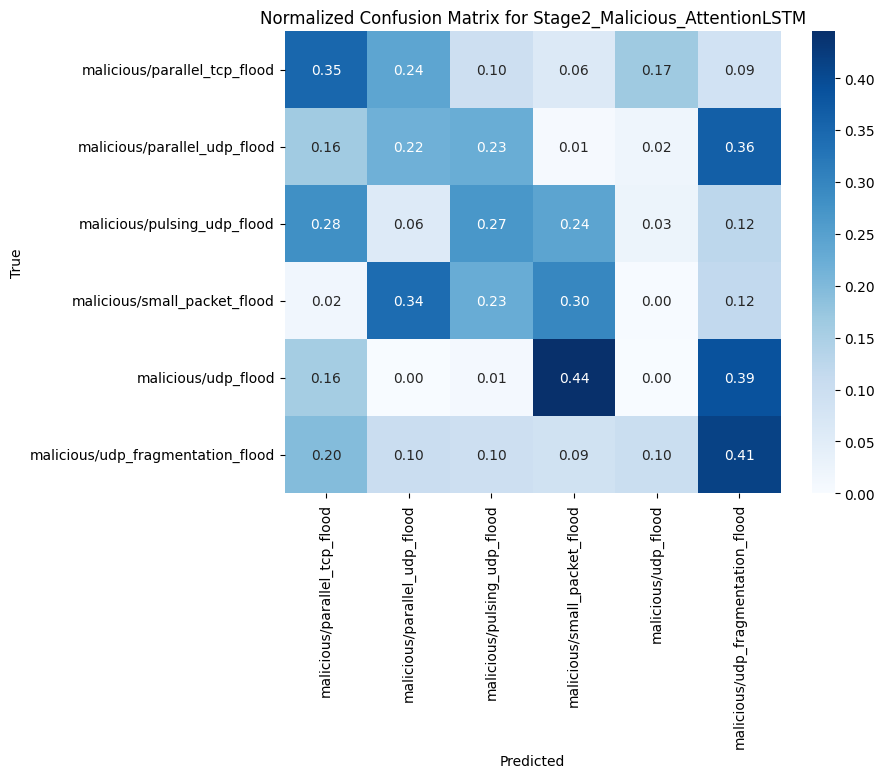

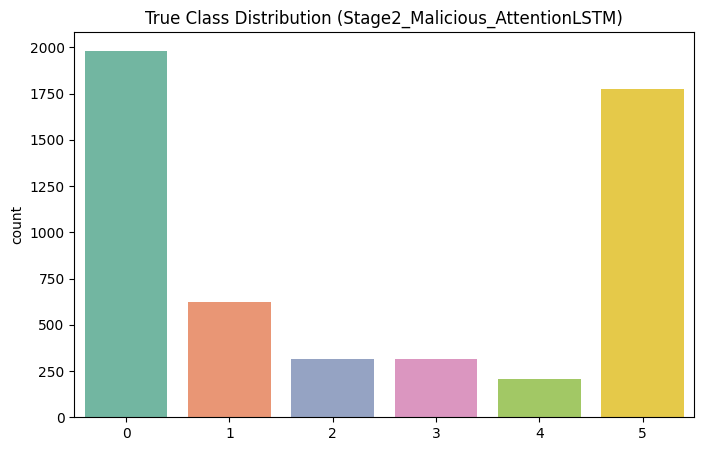

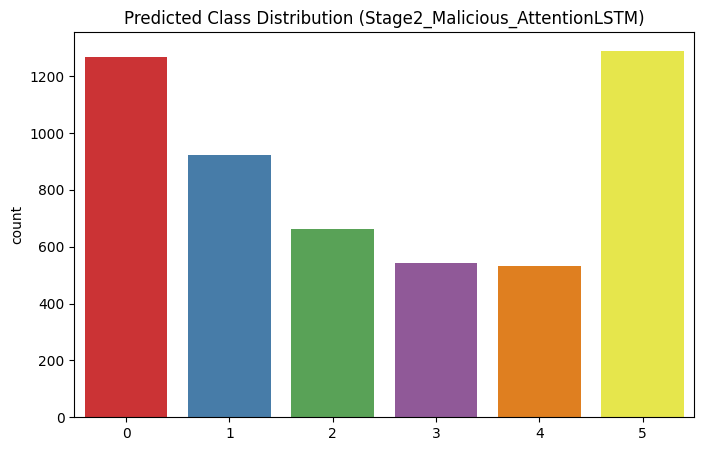

  Accuracy: 0.3337
  F1-Macro: 0.2453
  F1-Weighted: 0.3696

--- Evaluating AttentionGRU for Stage 2b Malicious ---

--- Evaluating Stage2_Malicious_AttentionGRU ---
                                   precision    recall  f1-score   support

     malicious/parallel_tcp_flood       0.63      0.44      0.52      1982
     malicious/parallel_udp_flood       0.15      0.21      0.18       625
      malicious/pulsing_udp_flood       0.06      0.12      0.08       313
     malicious/small_packet_flood       0.19      0.33      0.25       314
              malicious/udp_flood       0.00      0.00      0.00       209
malicious/udp_fragmentation_flood       0.53      0.43      0.48      1774

                         accuracy                           0.37      5217
                        macro avg       0.26      0.26      0.25      5217
                     weighted avg       0.45      0.37      0.40      5217



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1393: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1412.)
  result = _VF.gru(


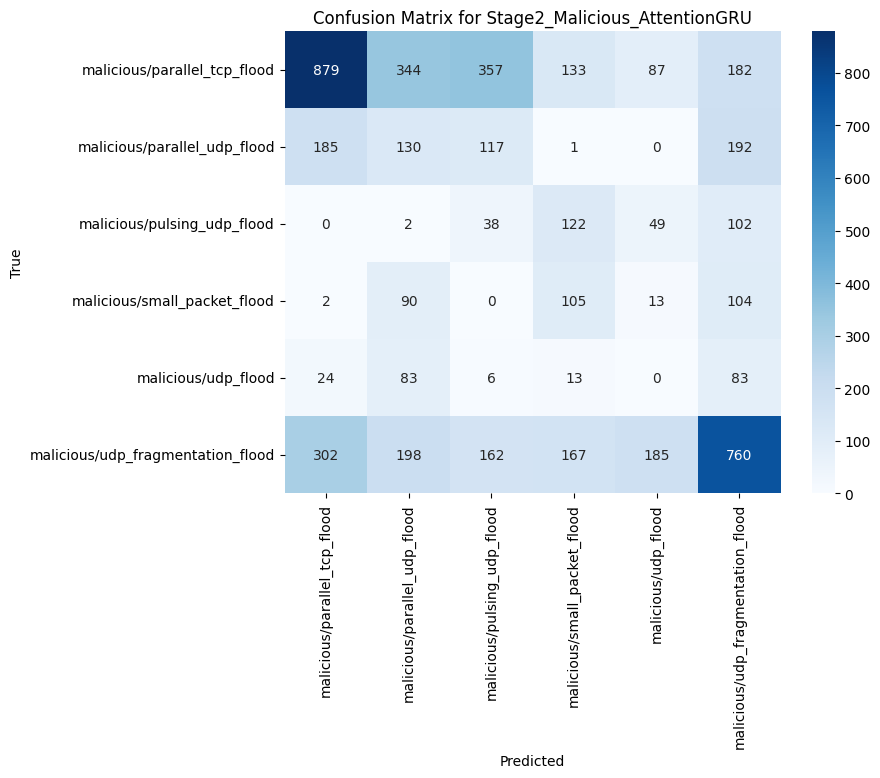

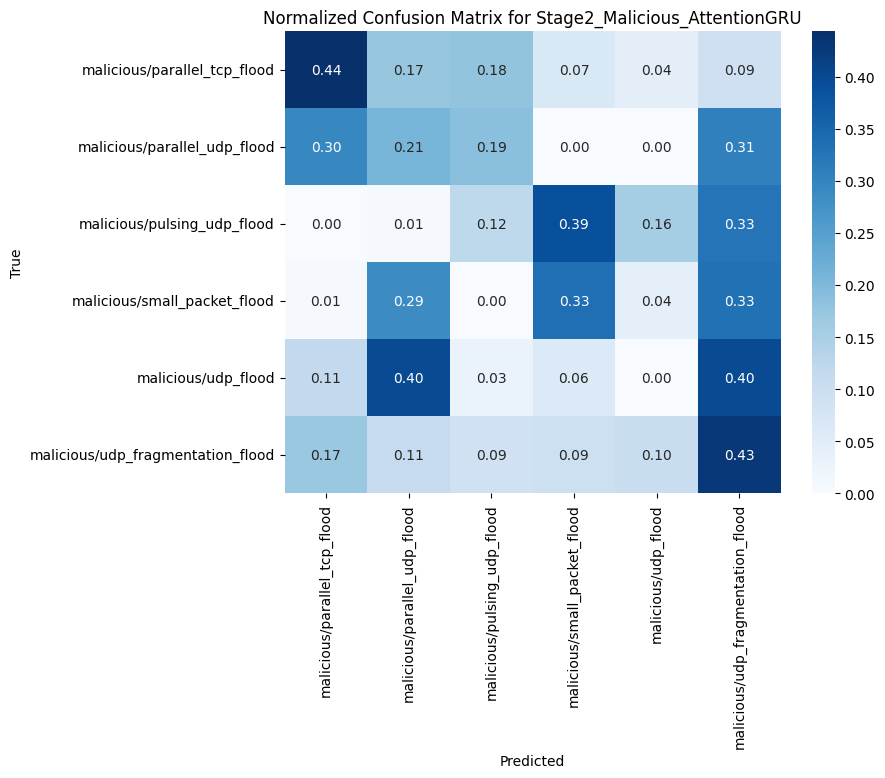

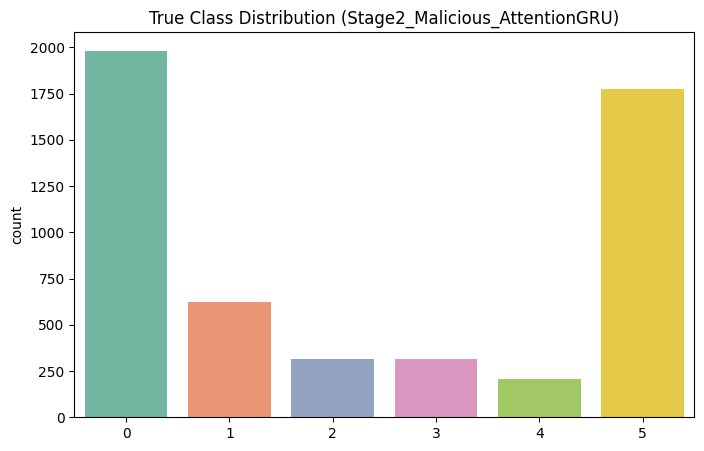

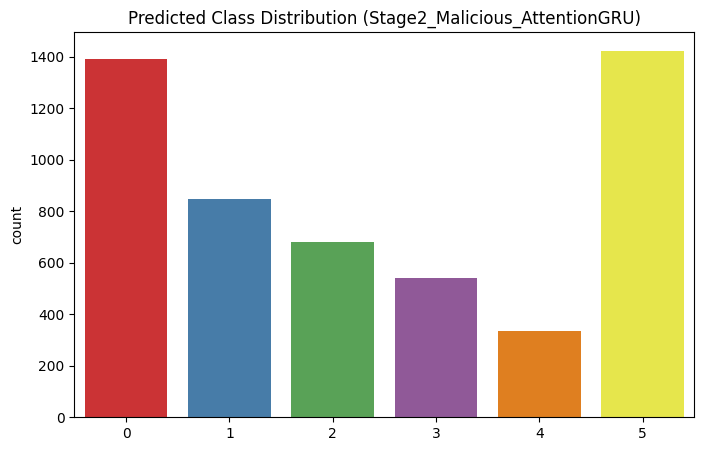

  Accuracy: 0.3665
  F1-Macro: 0.2492
  F1-Weighted: 0.4002

--- Evaluating Transformer for Stage 2b Malicious ---

--- Evaluating Stage2_Malicious_Transformer ---
                                   precision    recall  f1-score   support

     malicious/parallel_tcp_flood       0.67      0.49      0.57      1982
     malicious/parallel_udp_flood       0.35      0.37      0.36       625
      malicious/pulsing_udp_flood       0.07      0.08      0.07       313
     malicious/small_packet_flood       0.02      0.02      0.02       314
              malicious/udp_flood       0.00      0.00      0.00       209
malicious/udp_fragmentation_flood       0.44      0.44      0.44      1774

                         accuracy                           0.39      5217
                        macro avg       0.26      0.23      0.24      5217
                     weighted avg       0.45      0.39      0.41      5217



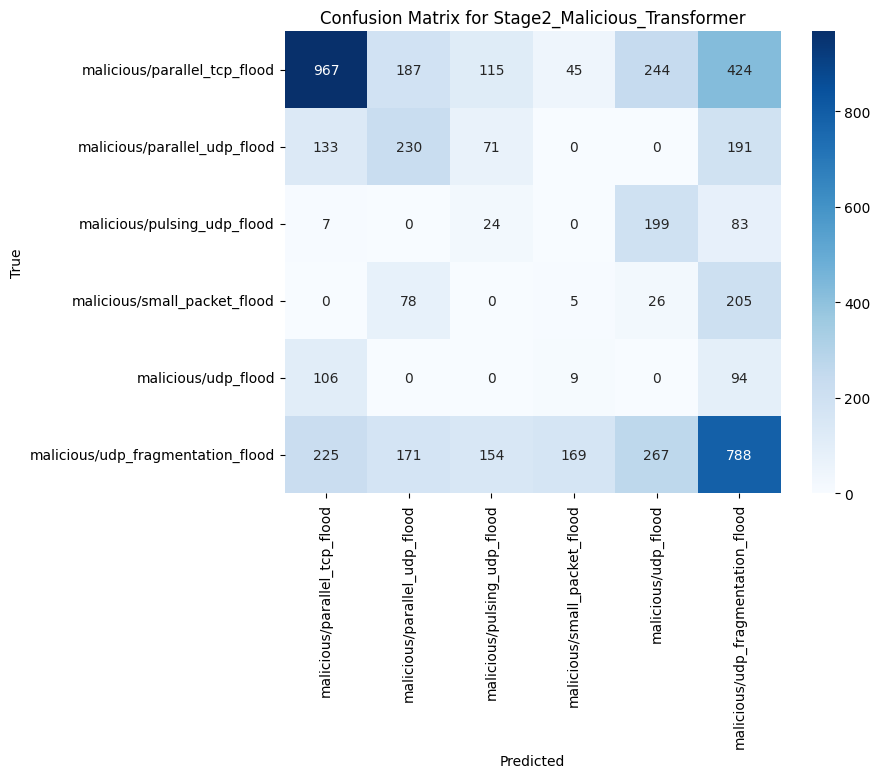

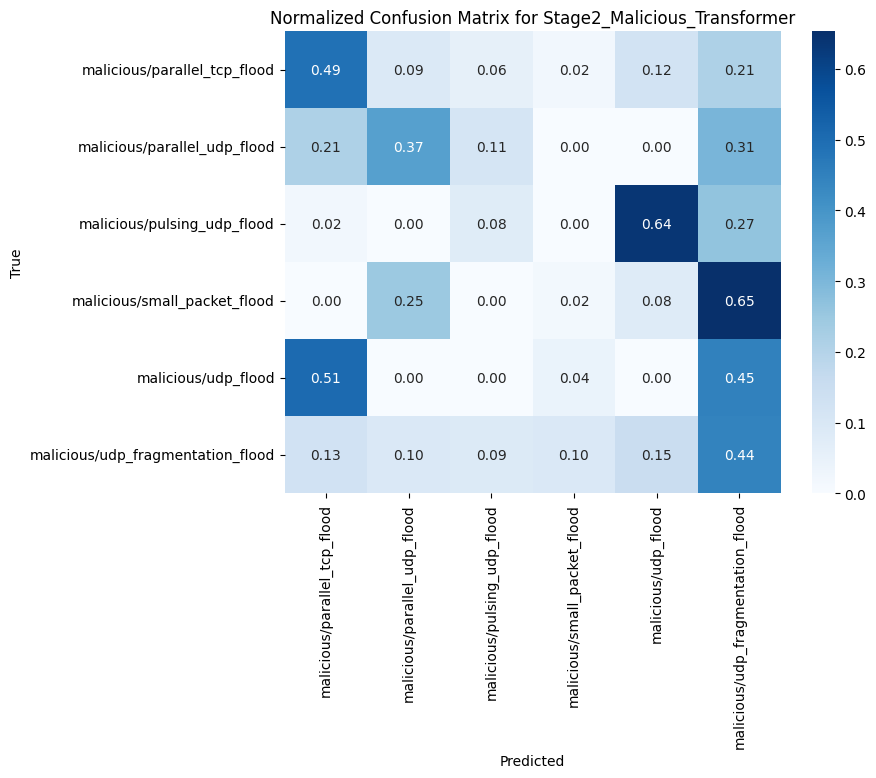

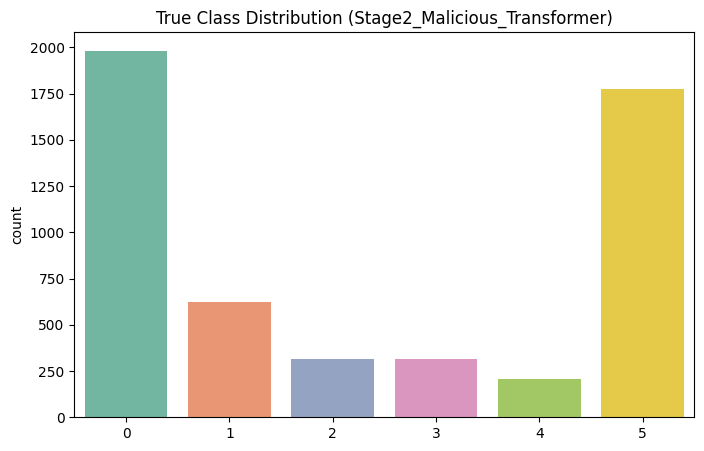

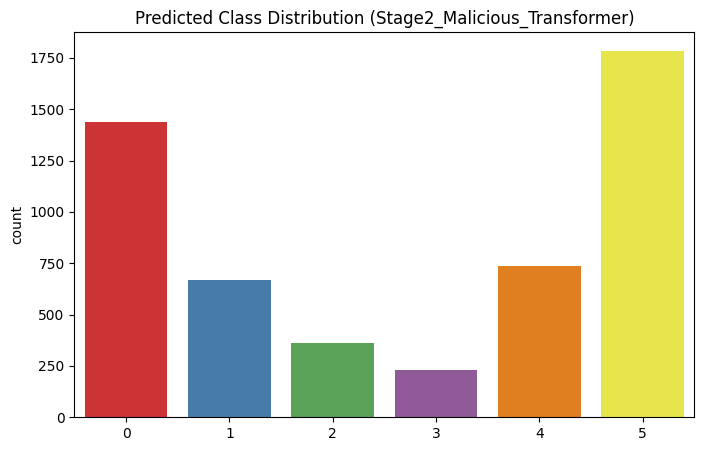

  Accuracy: 0.3860
  F1-Macro: 0.2423
  F1-Weighted: 0.4135

Best Stage 2b Malicious model: CNN_LSTM with F1-macro=0.305


In [46]:
# ------------------- STAGE 2b: MULTI-CLASS MALICIOUS -------------------
# Use the improved data preparation function
data_mal = prepare_stage2_data_sequences(
    df, selected_features, preprocessor, filter_val=1, seq_len=SEQ_LEN
)

results_malicious = load_results_per_model(models_to_try,'stage2_malicious') or {}
models_to_run = [m for m in models_to_try if m not in results_malicious]

for model_name in models_to_run:
    print(f"\n--- Stage 2b Malicious: {model_name} ---")
    model, study = load_artifacts(model_name, "stage2_malicious")

    # Get appropriate data format for each model type
    if model_name in ["MLP", "CNN1D", "LSTM", "CNN_LSTM", "GRU", "BiLSTM",
                      "CNN_GRU", "AttentionLSTM", "AttentionGRU", "Transformer"]:
        X_train_mal, X_test_mal, y_train_mal, y_test_mal = data_mal['sequences']
    else:
        X_train_mal, X_test_mal, y_train_mal, y_test_mal = data_mal['flat']
    
    le_malicious = data_mal['label_encoder']
    y_train_mal = np.asarray(y_train_mal)
    y_test_mal = np.asarray(y_test_mal)

    if model is not None and study is not None:
        print(f"Loaded existing {model_name} for Stage 2b Malicious.")
    else:
        try:
            pretrained_model = None
            if model_name in [
                "MLP", "CNN1D", "LSTM", "CNN_LSTM",
                "GRU", "BiLSTM", "CNN_GRU",
                "AttentionLSTM", "AttentionGRU", "Transformer"
            ]:
                pretrained_model = pretrain_pytorch_model(
                    model_name=model_name,
                    X=X_train_mal,
                    y=y_train_mal,
                    num_classes=len(le_malicious.classes_),
                    seq_len=SEQ_LEN,  # Use SEQ_LEN constant
                    epochs=10  # small warmup, not full training
                )
            best_trial, study = run_tuning_and_train(
                model_name, X_train_mal, y_train_mal,
                n_trials=10, num_classes=len(le_malicious.classes_), seq_len=SEQ_LEN, resume_stage='2b',pretrained_model=pretrained_model
            )

            if model_name not in [    "MLP",    "CNN1D",    "LSTM",    "CNN_LSTM",    "GRU",    "BiLSTM",    "CNN_GRU",    "AttentionLSTM",    "AttentionGRU",    "Transformer"]:
                if model_name == "XGBoost":
                    model = xgb.XGBClassifier(**best_trial.params, device=DEVICE,
                                              objective="multi:softprob", num_class=len(le_malicious.classes_))
                elif model_name == "LightGBM":
                    model = lgb.LGBMClassifier(**best_trial.params)
                elif model_name == "RandomForest":
                    model = cuRF(**best_trial.params)
                elif model_name == "CatBoost":
                    model = CatBoostClassifier(**best_trial.params, verbose=0)
                elif model_name == "SVM":
                    model = SVC(**best_trial.params)
                elif model_name == "KNN":
                    model = KNeighborsClassifier(**best_trial.params)
                elif model_name == "LogisticRegression":
                    model = LogisticRegression(max_iter=500)

                model.fit(X_train_mal, y_train_mal)
            else:
                model = best_trial.user_attrs.get("trained_model")
                if model is None:
                    print(f"Warning: trained_model not found for {model_name}, skipping evaluation.")
                    continue

            save_artifacts(model,selected_features, study, model_name, "stage2_malicious")
            print(f"Trained and saved {model_name} for Stage 2b Malicious.")
        except Exception as e:
            print(f"Skipping {model_name} due to error: {e}")
            continue

    # Evaluate
    if model_name in [    "MLP",    "CNN1D",    "LSTM",    "CNN_LSTM",    "GRU",    "BiLSTM",    "CNN_GRU",    "AttentionLSTM",    "AttentionGRU",    "Transformer"]:
        model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X_test_mal, dtype=torch.float32).to(DEVICE)
            out = model(X_tensor)
            y_pred = out.argmax(dim=1).cpu().numpy()
    else:
        y_pred = model.predict(X_test_mal)

    metrics_dict = evaluate_classification(model, f"Stage2_Malicious_{model_name}",
                                           X_test=X_test_mal, y_test=y_test_mal,
                                           target_names=le_malicious.classes_,
                                           y_pred=y_pred)

    model_result = {
        "model": model,
        "optuna_study": study,
        "accuracy": accuracy_score(y_test_mal, y_pred),
        "f1_macro": metrics_dict['macro avg']['f1-score'],
        "f1_weighted": metrics_dict['weighted avg']['f1-score'],
        "classification_report": metrics_dict,
        "confusion_matrix": confusion_matrix(y_test_mal, y_pred)
    }

    save_results_per_model({model_name: model_result}, 'stage2_malicious')
    results_malicious[model_name] = model_result

# Evaluate ALL models for Stage 2b Malicious using evaluate_model_predictions
print(f"\n--- Running evaluate_model_predictions for ALL Stage 2b Malicious models ---")
for model_name in models_to_try:
    print(f"\n--- Evaluating {model_name} for Stage 2b Malicious ---")
    
    try:
        # Load the model (either from results_malicious or from artifacts)
        if model_name in results_malicious:
            model = results_malicious[model_name]['model']
        else:
            # Try to load from artifacts
            artifacts = load_artifacts(model_name, "stage2_malicious")
            if artifacts is None:
                print(f"No model found for {model_name}, skipping.")
                continue
            model, _ = artifacts
            if isinstance(model, tuple):
                model = model[0]
        
        # Get appropriate data format for each model type
        if model_name in ["MLP", "CNN1D", "LSTM", "CNN_LSTM", "GRU", "BiLSTM",
                          "CNN_GRU", "AttentionLSTM", "AttentionGRU", "Transformer"]:
            X_test_mal = data_mal['sequences'][1]  # X_test_seq
            y_test_mal = data_mal['sequences'][3]  # y_test_seq
        else:
            X_test_mal = data_mal['flat'][1]  # X_test_flat
            y_test_mal = data_mal['flat'][3]  # y_test_flat
        le_malicious = data_mal['label_encoder']
        
        # Run evaluate_model_predictions
        y_pred = evaluate_model_predictions(model, model_name, X_test_mal, y_test_mal)
        evaluate_classification(model, f"Stage2_Malicious_{model_name}",
                                           X_test=X_test_mal, y_test=y_test_mal,
                                           target_names=le_malicious.classes_,
                                           y_pred=y_pred)

        # Print basic metrics
        accuracy = accuracy_score(y_test_mal, y_pred)
        f1_macro = f1_score(y_test_mal, y_pred, average='macro')
        f1_weighted = f1_score(y_test_mal, y_pred, average='weighted')
        
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  F1-Macro: {f1_macro:.4f}")
        print(f"  F1-Weighted: {f1_weighted:.4f}")
        
    except Exception as e:
        print(f"Error evaluating {model_name}: {type(e).__name__}: {str(e)}")
        continue

best_model_malicious = max(results_malicious, key=lambda k: results_malicious[k]['f1_macro'])
print(f"\nBest Stage 2b Malicious model: {best_model_malicious} with F1-macro={results_malicious[best_model_malicious]['f1_macro']:.3f}")



--- Stage 3: Cascading Evaluation ---
Using 30 out of 30 selected features

--- Evaluating Stage3_Cascading ---
                                   precision    recall  f1-score   support

                             embb       0.31      0.27      0.29      2710
     malicious/parallel_tcp_flood       0.58      0.53      0.55      2341
     malicious/parallel_udp_flood       0.44      0.37      0.40       618
      malicious/pulsing_udp_flood       0.71      0.82      0.76       617
     malicious/small_packet_flood       0.66      0.60      0.63       618
              malicious/udp_flood       0.61      0.57      0.59       742
malicious/udp_fragmentation_flood       0.66      0.61      0.63      1482
                              mtc       0.21      0.23      0.22      1356
                            urllc       0.17      0.25      0.20       986
                             voip       0.48      0.49      0.48      3698

                         accuracy                           

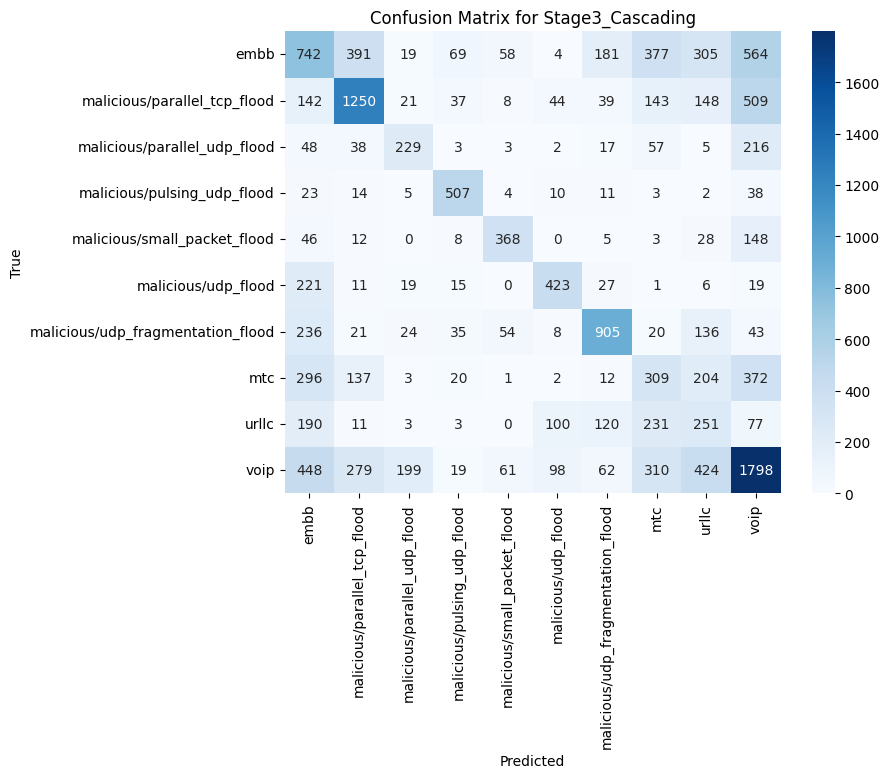

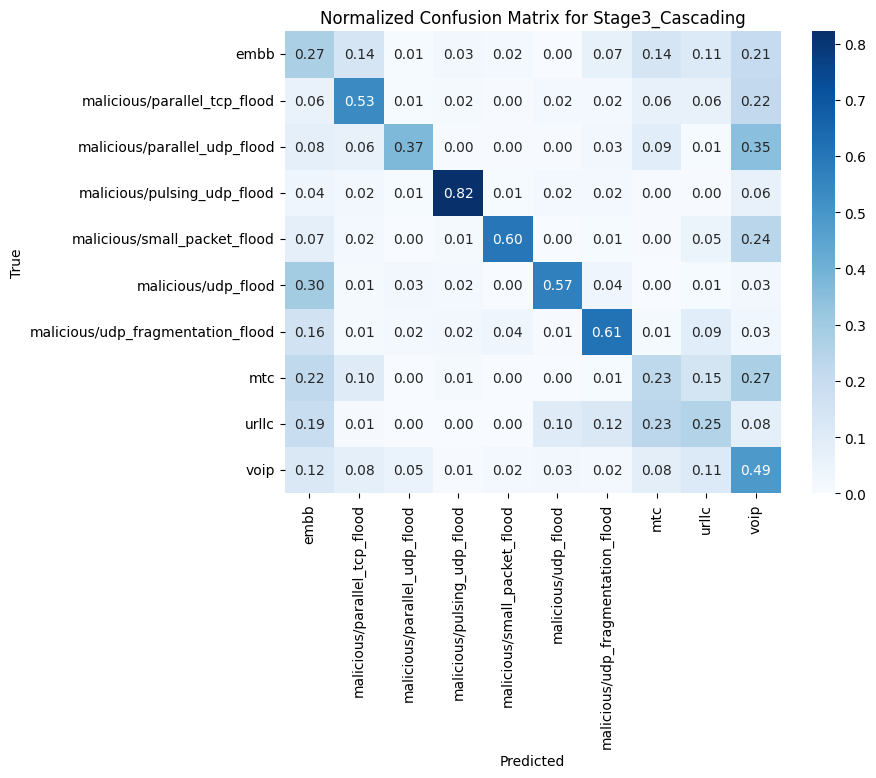

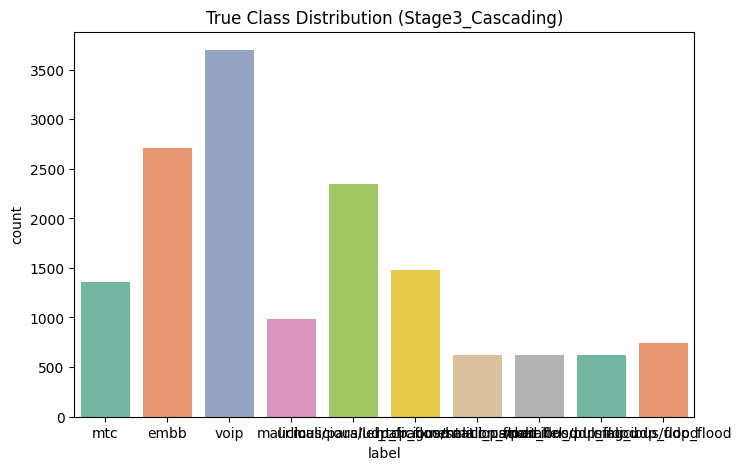

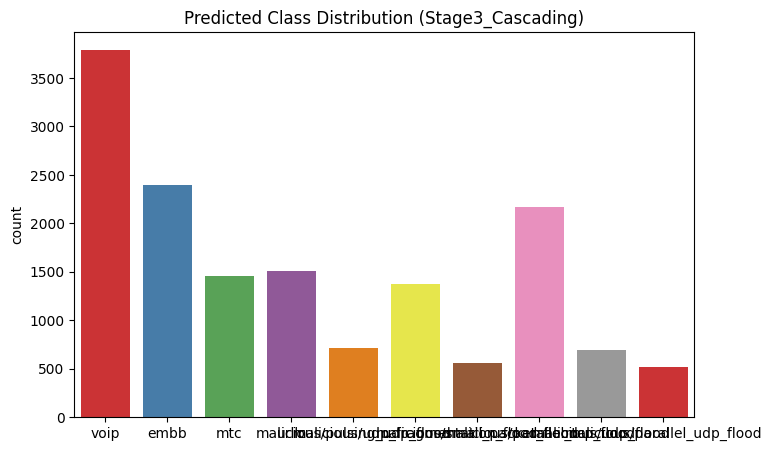

✅ Saved cascading model: cascading_s1
✅ Saved cascading model: cascading_s2_benign
✅ Saved cascading model: cascading_s2_malicious
Saved final cascading models.


In [47]:
# --- STAGE 3: CASCADING EVALUATION ---
print("\n--- Stage 3: Cascading Evaluation ---")


# Load the best models from Stage 1 & Stage 2 with proper error handling
def load_model_safely(model_name, stage):
    artifacts = load_artifacts(model_name, stage)
    if artifacts is None:
        return None
    model, _ = artifacts
    if isinstance(model, tuple):
        return model[0]
    return model


s1_model = load_model_safely(best_model_name, "stage1_binary")
s2_ben_model = load_model_safely(best_model_benign, "stage2_benign")
s2_mal_model = load_model_safely(best_model_malicious, "stage2_malicious")

if s1_model is None or s2_ben_model is None or s2_mal_model is None:
    print("Error: Could not load one or more required models for cascading evaluation")
else:

    def safe_flatten(model):
        if hasattr(model, "modules"):
            for module in model.modules():
                if isinstance(module, (torch.nn.GRU, torch.nn.LSTM)):
                    try:
                        module.flatten_parameters()
                    except Exception:
                        # Sometimes not possible on CPU or scripted models
                        pass

    # After loading your models
    safe_flatten(s1_model)
    safe_flatten(s2_ben_model)
    safe_flatten(s2_mal_model)

    # We need to get the test indices from the original data preparation
    # Let's recreate the test split to get the proper indices
    df_bin = df.copy()
    df_bin["target"] = df_bin["malicious"]
    df_bin["Timestamp"] = pd.to_datetime(df_bin["Timestamp"], errors="coerce")
    df_bin["Timestamp_epoch"] = df_bin["Timestamp"].astype("int64") // 10**9

    # Split to get test indices (same as in prepare_stage1_data)
    train_df, test_df = split_by_training_run(df_bin, test_size=0.2)
    test_indices = test_df.index
    if "Timestamp_epoch" not in test_df.columns and "Timestamp" in test_df.columns:
        test_df["Timestamp"] = pd.to_datetime(test_df["Timestamp"], errors="coerce")
        test_df["Timestamp_epoch"] = test_df["Timestamp"].astype("int64") // 10**9

    # Get the true labels for test set
    y_test_full_labels = test_df["label"]

    # Filter selected_features to only include features that exist in the original df
    available_features = [f for f in selected_features if f in test_df.columns]
    print(
        f"Using {len(available_features)} out of {len(selected_features)} selected features"
    )

    # For cascading, we need to predict each sample individually rather than using the sequence-based predictions
    # Collect cascading predictions
    final_pred_list = []

    for idx in test_indices:
        # Use available features and get the sample from test_df (which has all needed columns)
        X_sample = preprocessor.transform(test_df.loc[[idx], available_features])
        
        # For PyTorch models that expect sequence data, we need to reshape the input
        # Convert flat sample to sequence format [1, seq_len, features] by repeating the sample
        if best_model_name in ["MLP", "CNN1D", "LSTM", "CNN_LSTM", "GRU", "BiLSTM",
                               "CNN_GRU", "AttentionLSTM", "AttentionGRU", "Transformer"]:
            # Create a sequence by repeating the sample SEQ_LEN times for Stage 1 prediction
            X_sample_seq_s1 = np.repeat(X_sample, SEQ_LEN, axis=0).reshape(1, SEQ_LEN, -1)
            binary_pred = evaluate_model_predictions(s1_model, best_model_name, X_sample_seq_s1, None)[0]
        else:
            binary_pred = evaluate_model_predictions(s1_model, best_model_name, X_sample, None)[0]
        
        # Prepare data for Stage 2 models
        if best_model_benign in ["MLP", "CNN1D", "LSTM", "CNN_LSTM", "GRU", "BiLSTM",
                                 "CNN_GRU", "AttentionLSTM", "AttentionGRU", "Transformer"] or \
           best_model_malicious in ["MLP", "CNN1D", "LSTM", "CNN_LSTM", "GRU", "BiLSTM",
                                   "CNN_GRU", "AttentionLSTM", "AttentionGRU", "Transformer"]:
            # Create a sequence by repeating the sample SEQ_LEN times
            X_sample_seq = np.repeat(X_sample, SEQ_LEN, axis=0).reshape(1, SEQ_LEN, -1)
        else:
            X_sample_seq = X_sample

        if binary_pred == 0:  # benign
            if best_model_benign in ["MLP", "CNN1D", "LSTM", "CNN_LSTM", "GRU", "BiLSTM",
                                     "CNN_GRU", "AttentionLSTM", "AttentionGRU", "Transformer"]:
                pred_enc = evaluate_model_predictions(
                    s2_ben_model, best_model_benign, X_sample_seq, None
                )
            else:
                pred_enc = evaluate_model_predictions(
                    s2_ben_model, best_model_benign, X_sample, None
                )
            pred_label = data_ben["label_encoder"].inverse_transform(pred_enc)[0]
        else:  # malicious
            if best_model_malicious in ["MLP", "CNN1D", "LSTM", "CNN_LSTM", "GRU", "BiLSTM",
                                       "CNN_GRU", "AttentionLSTM", "AttentionGRU", "Transformer"]:
                pred_enc = evaluate_model_predictions(
                    s2_mal_model, best_model_malicious, X_sample_seq, None
                )
            else:
                pred_enc = evaluate_model_predictions(
                    s2_mal_model, best_model_malicious, X_sample, None
                )
            pred_label = data_mal["label_encoder"].inverse_transform(pred_enc)[0]

        final_pred_list.append(pred_label)

    # Convert to Series for evaluation
    final_preds = pd.Series(final_pred_list, index=test_indices)

    # Evaluate cascading predictions
    evaluate_classification(
        None,
        "Stage3_Cascading",
        y_test=y_test_full_labels,
        y_pred=final_preds,
        target_names=np.unique(final_preds),
    )

    # Save cascading models
    save_cascading_model(s1_model, selected_features, "cascading_s1")
    save_cascading_model(s2_ben_model, selected_features, "cascading_s2_benign")
    save_cascading_model(s2_mal_model, selected_features, "cascading_s2_malicious")
    print("Saved final cascading models.")

# ML Model Pipeline Visualization Prompt

## Comprehensive Graph Creation Prompt for O-RAN Network Security ML Pipeline

### **System Architecture Overview**
Create visualizations for a **3-stage cascaded machine learning pipeline** designed for O-RAN network security:

1. **Stage 1**: Binary classification (benign vs malicious traffic)
2. **Stage 2a**: Benign traffic sub-classification (eMBB, URLLC, mMTC, VoIP services)  
3. **Stage 2b**: Malicious attack type classification (UDP flood, TCP flood, fragmentation, etc.)

---

### **🎯 Key Visualizations Needed**

#### **1. Pipeline Architecture Flowchart**
- **Data flow diagram** showing: Raw telemetry → Feature engineering → Sequence creation → Multi-stage classification
- **Model branching logic** with decision points
- **Input/output dimensions** at each stage
- **Processing time annotations** for real-time inference requirements

#### **2. Model Performance Dashboard**
```python
# Performance metrics to visualize:
models = ["XGBoost", "LightGBM", "CatBoost", "RandomForest", 
          "CNN-LSTM", "LSTM", "BiLSTM", "GRU", "CNN-GRU", 
          "AttentionLSTM", "AttentionGRU", "Transformer", "MLP"]

metrics = ["accuracy", "f1_macro", "f1_weighted", "inference_time_ms"]
stages = ["Stage1_Binary", "Stage2_Benign", "Stage2_Malicious"]
```

- **Grouped bar charts** comparing accuracy across all models and stages
- **Radar charts** showing multi-metric performance per model
- **Heatmap** of F1-scores across models × stages
- **Scatter plot**: Accuracy vs Inference Time (performance-efficiency trade-off)

#### **3. Temporal Sequence Analysis**
- **Time-series plots** of 20-timestep windows showing:
  - Normal eMBB traffic patterns
  - URLLC low-latency characteristics  
  - mMTC sporadic IoT patterns
  - VoIP regular voice traffic
  - Various attack signatures (UDP flood, TCP flood, fragmentation)
- **Feature evolution** over sequence length
- **Attention weights visualization** for attention-based models

#### **4. Feature Engineering Pipeline**
- **Feature importance rankings** from Random Forest and XGBoost models
- **Top 30 network telemetry features** (PRB utilization, throughput ratios, delay variance, etc.)
- **Correlation matrix** of engineered features
- **Before/after standardization** distributions

#### **5. Confusion Matrix Gallery**
- **Normalized confusion matrices** for each model type:
  - Tree-based models (XGBoost, LightGBM, CatBoost, RandomForest)
  - Deep learning models (LSTM variants, CNN-LSTM, Transformers)
- **Class-wise precision/recall** breakdown
- **Error analysis** showing common misclassifications

#### **6. Training Dynamics**
- **Optuna hyperparameter optimization** progress plots
- **Cross-validation score** distributions (StratifiedKFold)
- **Learning curves** for deep learning models
- **Convergence analysis** across different model families

#### **7. Real-time Performance Analysis**
- **Inference latency** distributions per model
- **Memory usage** during training and inference
- **Scalability curves**: Performance vs number of UEs
- **Batch processing efficiency** analysis

---

### **📊 Technical Specifications**

#### **Data Characteristics**
- **Sequence length**: 20 timesteps
- **Feature count**: 127 engineered features from O-RAN telemetry
- **Dataset size**: 216,000 samples from 150 experimental runs
- **Class distribution**: 62% benign, 38% malicious
- **Temporal granularity**: 1-second intervals

#### **Model Categories**
1. **Tree-based**: XGBoost, LightGBM, CatBoost, RandomForest
2. **Neural Networks**: MLP, CNN1D, LSTM, BiLSTM, GRU
3. **Advanced Architectures**: CNN-LSTM, CNN-GRU, AttentionLSTM, AttentionGRU, Transformer

#### **Evaluation Framework**
- **Cross-validation**: StratifiedKFold (3 splits)
- **Metrics**: Accuracy, F1-macro, F1-weighted, Precision, Recall
- **Hardware**: GPU-accelerated training with CUDA support
- **Optimization**: Optuna with 10-20 trials per model

---

### **🎨 Visualization Style Guidelines**

- **Color scheme**: Use distinct colors for model families (blue for tree-based, green for LSTM variants, red for attention models)
- **Interactive elements**: Plotly/Bokeh for zooming and hover details
- **Subplots**: Organize related metrics in unified dashboards
- **Annotations**: Include key insights and performance thresholds
- **Export formats**: High-resolution PNG/PDF for thesis inclusion

---

### **💡 Key Insights to Highlight**

1. **Model trade-offs**: Tree-based models for interpretability vs deep learning for temporal patterns
2. **Stage-specific performance**: Which models excel at binary vs multi-class classification
3. **Real-time feasibility**: Models meeting <100ms inference requirements
4. **Feature significance**: Most discriminative network telemetry metrics
5. **Attack detection patterns**: Temporal signatures that distinguish attack types

This visualization suite should demonstrate the comprehensive evaluation of your O-RAN security ML pipeline and support deployment decisions for production environments.